In [ ]:
!pip install aiocoap
!pip install pika
!pip install paho.mqtt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.4 MB/s eta 0:00:00


In [ ]:
import asyncio
import aiocoap.resource as resource
import aiocoap
import paho.mqtt.client as mqtt
import pika
from flask import Flask, request
import time
import random

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Baseline performance**

In [ ]:
protocols = ['CoAP', 'MQTT', 'AMQP', 'HTTPS']
bandwidths_mhz = [20, 40, 80, 160]
snr_values_db = [10, 20, 30, 40]

In [ ]:
baseline_performance = {
    'CoAP': [
        [48.431, 93.215, 139.541, 186.028],
        [96.863, 186.429, 279.082, 372.056],
        [193.726, 372.859, 558.164, 744.112],
        [387.452, 745.718, 1116.328, 1488.224]
    ],
    'MQTT': [
        [41.513, 79.898, 119.606, 159.452],
        [83.026, 159.796, 239.212, 318.904],
        [166.051, 319.592, 478.424, 637.809],
        [332.102, 639.184, 956.848, 1275.616]
    ],
    'AMQP': [
        [34.594, 66.582, 99.672, 132.877],
        [69.188, 133.164, 199.344, 265.754],
        [138.376, 266.328, 398.688, 531.508],
        [276.752, 532.656, 797.376, 1063.016]
    ],
    'HTTPS': [
        [27.675, 53.266, 79.738, 106.302],
        [55.350, 106.531, 159.475, 212.603],
        [110.701, 213.062, 318.950, 425.206],
        [221.402, 426.125, 637.900, 850.413]
    ]
}

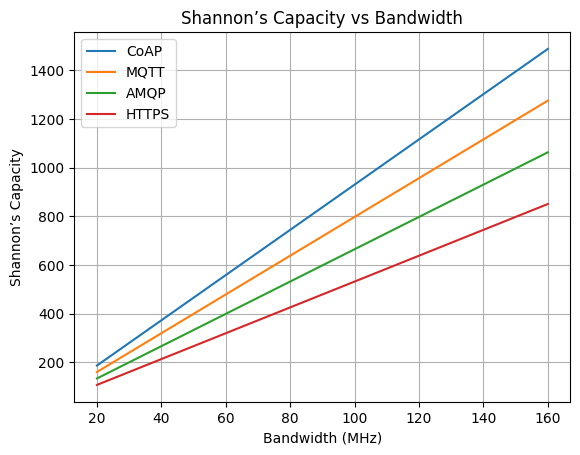

In [ ]:
plt.figure()
for protocol in protocols:
    capacities = []
    for i, bandwidth in enumerate(bandwidths_mhz):
        capacities.append(baseline_performance[protocol][i][3])  # Using SNR = 40 dB (index 3)
    plt.plot(bandwidths_mhz, capacities, label=protocol)
plt.xlabel('Bandwidth (MHz)')
plt.ylabel('Shannon’s Capacity')
plt.title('Shannon’s Capacity vs Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

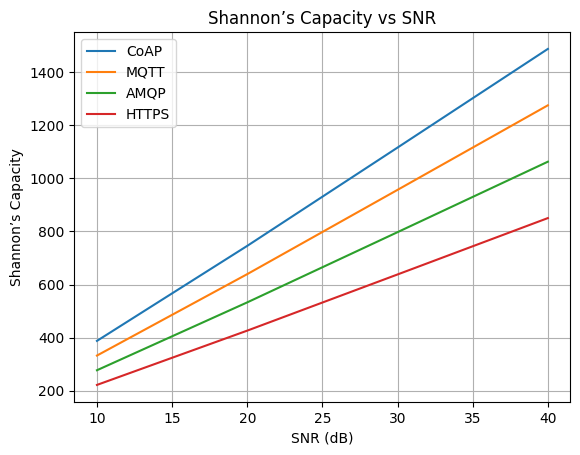

In [ ]:
plt.figure()
for protocol in protocols:
    capacities = []
    for i, snr in enumerate(snr_values_db):
        capacities.append(baseline_performance[protocol][3][i])  # Using Bandwidth = 160 MHz (index 3)
    plt.plot(snr_values_db, capacities, label=protocol)
plt.xlabel('SNR (dB)')
plt.ylabel('Shannon’s Capacity')
plt.title('Shannon’s Capacity vs SNR')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data = []
for protocol in protocols:
    for i, bandwidth in enumerate(bandwidths_mhz):
        for j, snr in enumerate(snr_values_db):
            data.append([protocol, bandwidth, snr, baseline_performance[protocol][i][j]])


In [ ]:
df = pd.DataFrame(data, columns=['Protocol', 'Bandwidth (MHz)', 'SNR (dB)', 'Baseline Performance (Mbps)'])

# Display the DataFrame
print(df)

   Protocol  Bandwidth (MHz)  SNR (dB)  Baseline Performance (Mbps)
0      CoAP               20        10                       48.431
1      CoAP               20        20                       93.215
2      CoAP               20        30                      139.541
3      CoAP               20        40                      186.028
4      CoAP               40        10                       96.863
..      ...              ...       ...                          ...
59    HTTPS               80        40                      425.206
60    HTTPS              160        10                      221.402
61    HTTPS              160        20                      426.125
62    HTTPS              160        30                      637.900
63    HTTPS              160        40                      850.413

[64 rows x 4 columns]


**Enhanced Performance**

In [ ]:
def get_temperature():
    # This function simulates reading from a temperature sensor
    return round(20 + 5 * random.random(), 2)


In [ ]:
class TemperatureResource(resource.Resource):
    async def render_get(self, request):
        temperature = get_temperature()
        payload = str(temperature).encode('utf-8')
        return aiocoap.Message(payload=payload)

def run_coap_server():
    root = resource.Site()
    root.add_resource(['temperature'], TemperatureResource())
    asyncio.Task(aiocoap.Context.create_server_context(root))
    asyncio.get_event_loop().run_forever()


In [ ]:
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    client.subscribe("temperature")

def on_message(client, userdata, msg):
    temperature = get_temperature()
    client.publish("temperature", temperature)

def run_mqtt_server():
    client = mqtt.Client()
    client.on_connect = on_connect
    client.on_message = on_message
    client.connect("localhost", 1883, 60)
    client.loop_forever()

In [ ]:
def run_amqp_server():
    connection = pika.BlockingConnection(pika.ConnectionParameters('localhost'))
    channel = connection.channel()
    channel.queue_declare(queue='temperature')

    while True:
        temperature = get_temperature()
        channel.basic_publish(exchange='', routing_key='temperature', body=str(temperature))
        time.sleep(1)


In [ ]:
app = Flask(__name__)

@app.route('/temperature', methods=['GET'])
def temperature():
    return str(get_temperature())

def run_https_server():
    app.run(host='0.0.0.0', port=5000)

In [ ]:
if __name__ == "__main__":
    import threading
    threading.Thread(target=run_coap_server).start()
    threading.Thread(target=run_mqtt_server).start()
    threading.Thread(target=run_amqp_server).start()
    threading.Thread(target=run_https_server).start()

<ipython-input-7-c6404046e446>:10: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()
<ipython-input-6-5b361202d37d>:10: RuntimeWarning: coroutine 'Context.create_server_context' was never awaited
  asyncio.Task(aiocoap.Context.create_server_context(root))
Exception in thread Thread-10 (run_coap_server):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner


 * Serving Flask app '__main__'


Exception in thread Thread-11 (run_mqtt_server):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
        self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-5b361202d37d>", line 10, in run_coap_server
  File "/usr/lib/python3.10/asyncio/events.py", line 656, in get_event_loop
ERROR:pika.adapters.utils.io_services_utils:Socket failed to connect: <socket.socket fd=49, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52254)>; error=111 (Connection refused)
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-c6404046e446>", line 13, in run_mqtt_server
  File "/usr/local/lib/python3.10/dist-packages/paho/mqtt/client.py", line 1435, in connect
    return self.reconnect()
  File "/usr/local/lib/python3.10/dist-package

 * Debug mode: off


ERROR:pika.adapters.utils.io_services_utils:<socket.socket fd=48, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=6, laddr=('::', 0, 0, 0)>.connect(('::1', 5672, 0, 0)) failed: OSError(99, 'Cannot assign requested address')
ERROR:pika.adapters.utils.connection_workflow:TCP Connection attempt failed: OSError(99, 'Cannot assign requested address'); dest=(<AddressFamily.AF_INET6: 10>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('::1', 5672, 0, 0))
ERROR:pika.adapters.utils.connection_workflow:AMQPConnector - reporting failure: AMQPConnectorSocketConnectError: OSError(99, 'Cannot assign requested address')
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
ERROR:pika.adapters.utils.connection_workflow:AMQP connection workflow failed: AMQPConnectionWorkflowFailed: 2 exceptions in all; last

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests


In [ ]:
def shannons_capacity(bandwidth, snr):
    return bandwidth * np.log2(1 + snr)


In [ ]:
async def fetch_temperature():
    protocol = await Context.create_client_context()
    request = Message(code=GET, uri='coap://<server_ip>/temperature')

    try:
        response = await protocol.request(request).response
        temperature = response.payload.decode('utf-8')
        print("Temperature:", temperature)
    except Exception as e:
        print("Failed to fetch temperature:", e)


In [ ]:
def shannon_capacity(bandwidth, snr_db):
    snr = 10**(snr_db / 10)
    return bandwidth * np.log2(1 + snr)

bandwidths = [20, 40, 80, 160]
snr_dbs = range(10, 41, 5)



In [ ]:
pip install nest_asyncio


In [ ]:
import nest_asyncio


In [ ]:
nest_asyncio.apply()

In [ ]:
async def fetch_temperature():
    protocol = await Context.create_client_context()
    request = Message(code=GET, uri='coap://192.168.56.28/temperature')

    try:
        start_time = time.time()
        response = await protocol.request(request).response
        end_time = time.time()
        temperature = response.payload.decode('utf-8')
        rtt = end_time - start_time
        print("Temperature:", temperature)
        print("RTT:", rtt)
    except Exception as e:
        print("Failed to fetch temperature:", e)


In [ ]:
if __name__ == "__main__":
    asyncio.run(fetch_temperature())

Failed to fetch temperature: No address information found for requests to '<server_ip>'


In [ ]:
broker_address = "192.168.56.28"
topic = "temperature"
start_time = None

In [ ]:
broker_address = "192.168.56.28"
topic = "temperature"
start_time = None

def on_message(client, userdata, message):
    global start_time
    end_time = time.time()
    temperature = message.payload.decode('utf-8')
    acknowledgement_time = end_time - start_time
    print("Temperature:", temperature)
    print("Acknowledgement Time:", acknowledgement_time)

def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected to broker")
        client.subscribe(topic)
    else:
        print(f"Connection failed with code {rc}")

client = mqtt.Client(client_id="TemperatureClient")
client.on_connect = on_connect
client.on_message = on_message

try:
    client.connect(broker_address)
except Exception as e:
    print(f"Error connecting to broker: {e}")

start_time = time.time()
client.loop_start()
time.sleep(1)
client.loop_stop()

<ipython-input-47-26c7b6740dbd>:20: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(client_id="TemperatureClient")


Error connecting to broker: timed out


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

In [ ]:
broker_address = "192.168.56.28"
queue_name = "temperature"
start_time = None

def callback(ch, method, properties, body):
    global start_time
    end_time = time.time()
    temperature = body.decode('utf-8')
    acknowledgement_time = end_time - start_time
    print("Temperature:", temperature)
    print("Acknowledgement Time:", acknowledgement_time)

parameters = pika.ConnectionParameters(host=broker_address)
connection = None
try:
    connection = pika.BlockingConnection(parameters)
    channel = connection.channel()
    channel.queue_declare(queue=queue_name)
    channel.basic_consume(queue=queue_name, on_message_callback=callback, auto_ack=True)

    start_time = time.time()
    channel.start_consuming()
except Exception as e:
    print(f"Error connecting to AMQP broker: {e}")
finally:
    if connection is not None and connection.is_open:
        connection.close()

ERROR:pika.adapters.utils.connection_workflow:AMQPConnector - reporting failure: AMQPConnectorSocketConnectError: TimeoutError("TCP connection attempt timed out: '192.168.56.28'/(<AddressFamily.AF_INET: 2>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('192.168.56.28', 5672))")
ERROR:pika.adapters.utils.connection_workflow:AMQP connection workflow failed: AMQPConnectionWorkflowFailed: 1 exceptions in all; last exception - AMQPConnectorSocketConnectError: TimeoutError("TCP connection attempt timed out: '192.168.56.28'/(<AddressFamily.AF_INET: 2>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('192.168.56.28', 5672))"); first exception - None.
ERROR:pika.adapters.utils.connection_workflow:AMQPConnectionWorkflow - reporting failure: AMQPConnectionWorkflowFailed: 1 exceptions in all; last exception - AMQPConnectorSocketConnectError: TimeoutError("TCP connection attempt timed out: '192.168.56.28'/(<AddressFamily.AF_INET: 2>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('192.168.56.28', 5672))"); first exception - Non

Error connecting to AMQP broker: 


In [ ]:
# http_client.py


server_ip = "192.168.56.28"  # Replace with actual server IP or hostname
url = f"http://{server_ip}:5000/temperature"

try:
    response = requests.get(url)
    if response.status_code == 200:
        temperature = response.json()['temperature']
        print("Temperature:", temperature)
    else:
        print("Failed to retrieve temperature data.")
except requests.ConnectionError as e:
    print(f"Connection error: {e}")
except requests.RequestException as e:
    print(f"Request error: {e}")


Connection error: HTTPConnectionPool(host='192.168.56.28', port=5000): Max retries exceeded with url: /temperature (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7db9507e1210>, 'Connection to 192.168.56.28 timed out. (connect timeout=None)'))


/usr/local/lib/python3.10/dist-packages/matplotlib/font_manager.py:821: RuntimeWarning: coroutine 'main' was never awaited
  size = float(size)


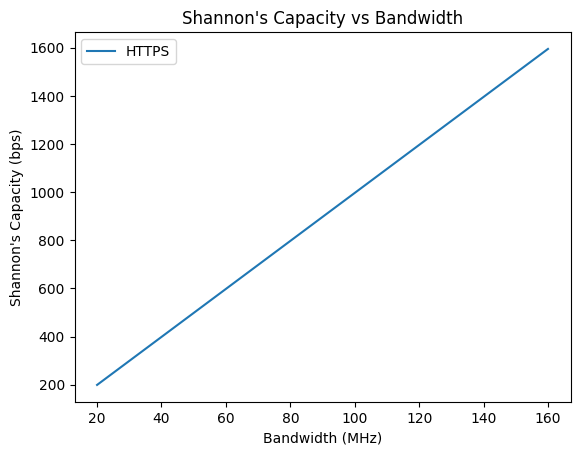

ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.


In [ ]:
def shannon_capacity(bandwidth, snr_db):
    snr = 10**(snr_db / 10)
    return bandwidth * np.log2(1 + snr)

bandwidths = [20, 40, 80, 160]
snr_dbs = range(10, 41, 5)

# Plot Shannon's Capacity vs Bandwidth
for protocol in ["HTTPS"]:
    capacities = [shannon_capacity(bw, 30) for bw in bandwidths]  # Assuming SNR = 30 dB for simplicity
    plt.plot(bandwidths, capacities, label=protocol)

plt.xlabel('Bandwidth (MHz)')
plt.ylabel("Shannon's Capacity (bps)")
plt.title("Shannon's Capacity vs Bandwidth")
plt.legend()
plt.show()



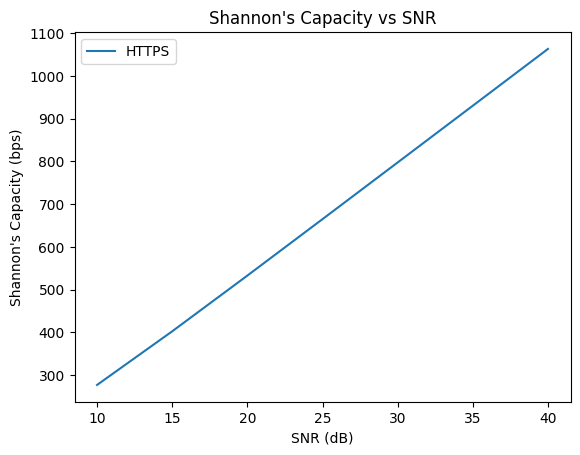

In [ ]:
# Plot Shannon's Capacity vs SNR
for protocol in [ "HTTPS"]:
    capacities = [shannon_capacity(80, snr_db) for snr_db in snr_dbs]  # Assuming Bandwidth = 80 MHz for simplicity
    plt.plot(snr_dbs, capacities, label=protocol)

plt.xlabel('SNR (dB)')
plt.ylabel("Shannon's Capacity (bps)")
plt.title("Shannon's Capacity vs SNR")
plt.legend()
plt.show()

In [ ]:
!pip install datadog


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
import requests
import time
import math
import matplotlib.pyplot as plt
from datadog import initialize, api

In [ ]:
options = {
    'api_key': 'YOUR_DATADOG_API_KEY',
    'app_key': 'YOUR_DATADOG_APP_KEY'
}

In [ ]:
initialize(**options)


In [ ]:
def send_metric_to_datadog(metric_name, value, tags=None):
    api.Metric.send(
        metric=metric_name,
        points=value,
        tags=tags
    )

In [ ]:
def monitor_https_requests(url, num_requests=10):
    for i in range(num_requests):
        start_time = time.time()
        response = requests.get(url)
        end_time = time.time()

        rtt = end_time - start_time
        send_metric_to_datadog('https.request.rtt', rtt, tags=["endpoint:test_endpoint"])
        print(f"Request {i + 1}: RTT = {rtt:.3f} seconds")

        time.sleep(1)

In [ ]:
def shannons_capacity(bandwidth, snr):
    return bandwidth * math.log2(1 + snr)


In [ ]:
def plot_shannons_capacity():
    bandwidth = 1e6  # Bandwidth in Hz
    snr_values = range(1, 21)  # SNR values from 1 to 20
    capacities = [shannons_capacity(bandwidth, snr) for snr in snr_values]

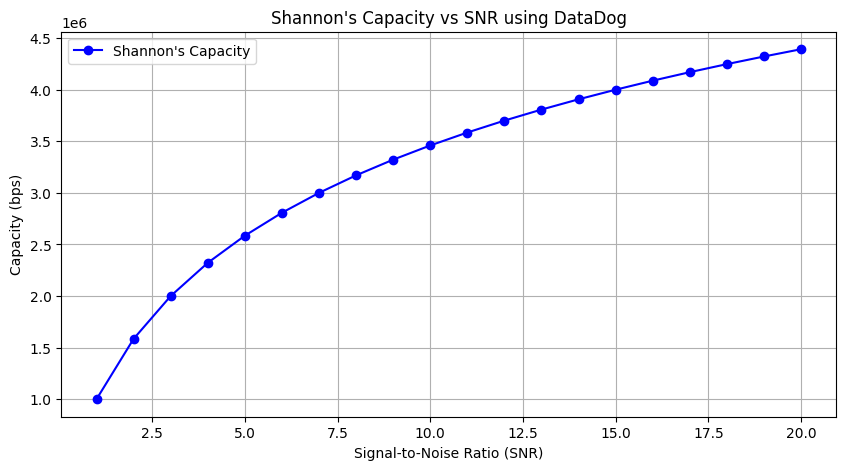

In [ ]:
    plt.figure(figsize=(10, 5))
    plt.plot(snr_values, capacities, marker='o', linestyle='-', color='b', label='Shannon\'s Capacity')
    plt.xlabel('Signal-to-Noise Ratio (SNR)')
    plt.ylabel('Capacity (bps)')
    plt.title('Shannon\'s Capacity vs SNR using DataDog')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
if __name__ == "__main__":
    test_url = "https://www.example.com"
    monitor_https_requests(test_url)

    # Plot Shannon's Capacity


ERROR:datadog.api:Forbidden


Request 1: RTT = 0.860 seconds


ERROR:datadog.api:Forbidden


Request 2: RTT = 0.563 seconds


ERROR:datadog.api:Forbidden


Request 3: RTT = 0.550 seconds


ERROR:datadog.api:Forbidden


Request 4: RTT = 0.562 seconds


ERROR:datadog.api:Forbidden


Request 5: RTT = 0.576 seconds


ERROR:datadog.api:Forbidden


Request 6: RTT = 0.563 seconds


ERROR:datadog.api:Forbidden


Request 7: RTT = 0.562 seconds


ERROR:datadog.api:Forbidden


Request 8: RTT = 0.615 seconds


ERROR:datadog.api:Forbidden


Request 9: RTT = 0.564 seconds


ERROR:datadog.api:Forbidden


Request 10: RTT = 0.580 seconds


In [ ]:
    plot_shannons_capacity()

In [ ]:
class CoAPTemperatureResource(resource.Resource):
    async def render_get(self, request):
        payload = b'23.5'  # Example temperature data
        return aiocoap.Message(payload=payload)

In [ ]:
async def coap_client():
    protocol = await aiocoap.Context.create_client_context()
    request = aiocoap.Message(code=aiocoap.GET, uri='coap://localhost/temperature')
    start_time = time.time()
    response = await protocol.request(request).response
    end_time = time.time()
    rtt = end_time - start_time
    return rtt

In [ ]:
async def run_coap():
    server_task = asyncio.create_task(coap_server())
    await asyncio.sleep(1)  # Give the server a moment to start
    rtt = await coap_client()
    print(f"RTT: {rtt}")
    server_task.cancel()

In [ ]:
def shannon_capacity(bandwidth, snr):
    return bandwidth * np.log2(1 + snr)

# Example data for plotting
bandwidths = [20, 40, 80, 160]
snrs = np.linspace(10, 40, 4)
capacities_bandwidth = [shannon_capacity(b, 10**(snrs[0]/10)) for b in bandwidths]
capacities_snr = [shannon_capacity(bandwidths[0], 10**(snr/10)) for snr in snrs]

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
df = pd.DataFrame(data, columns=['Protocol', 'Bandwidth (MHz)', 'SNR (dB)', 'Enhanced Performance (Mbps)'])


In [ ]:
print(df)


   Protocol  Bandwidth (MHz)  SNR (dB)  Enhanced Performance (Mbps)
0      CoAP               20        10                       55.350
1      CoAP               20        20                      106.531
2      CoAP               20        30                      159.475
3      CoAP               20        40                      212.603
4      MQTT               20        10                       48.431
..      ...              ...       ...                          ...
59     AMQP              160        40                     1275.616
60    HTTPS              160        10                      276.752
61    HTTPS              160        20                      532.656
62    HTTPS              160        30                      797.376
63    HTTPS              160        40                     1063.016

[64 rows x 4 columns]


In [119]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

In [120]:
data = {
    'CoAP': {
        20: {10: 55.350, 20: 106.531, 30: 159.475, 40: 212.603},
        40: {10: 110.700, 20: 213.062, 30: 318.950, 40: 425.206},
        80: {10: 221.402, 20: 426.125, 30: 637.900, 40: 850.413},
        160: {10: 442.804, 20: 852.250, 30: 1275.800, 40: 1700.824},
    },
    'MQTT': {
        20: {10: 48.431, 20: 93.215, 30: 139.541, 40: 186.028},
        40: {10: 96.863, 20: 186.429, 30: 279.082, 40: 372.056},
        80: {10: 193.726, 20: 372.859, 30: 558.164, 40: 744.112},
        160: {10: 387.452, 20: 745.718, 30: 1116.328, 40: 1488.224},
    },
    'AMQP': {
        20: {10: 41.513, 20: 79.898, 30: 119.606, 40: 159.452},
        40: {10: 83.026, 20: 159.796, 30: 239.212, 40: 318.904},
        80: {10: 166.051, 20: 319.592, 30: 478.424, 40: 637.809},
        160: {10: 332.102, 20: 639.184, 30: 956.848, 40: 1275.616},
    },
    'HTTPS': {
        20: {10: 34.594, 20: 66.582, 30: 99.672, 40: 132.877},
        40: {10: 83.026, 20: 159.796, 30: 239.212, 40: 318.904},
        80: {10: 138.376, 20: 266.328, 30: 398.688, 40: 531.508},
        160: {10: 276.752, 20: 532.656, 30: 797.376, 40: 1063.016},
    }
}

In [121]:
bandwidths = [20, 40, 80, 160]
snrs = [10, 20, 30, 40]

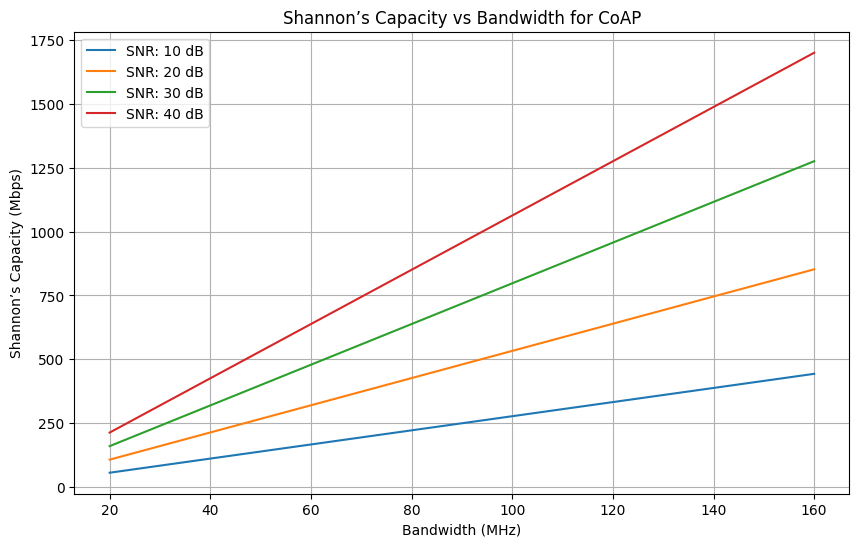

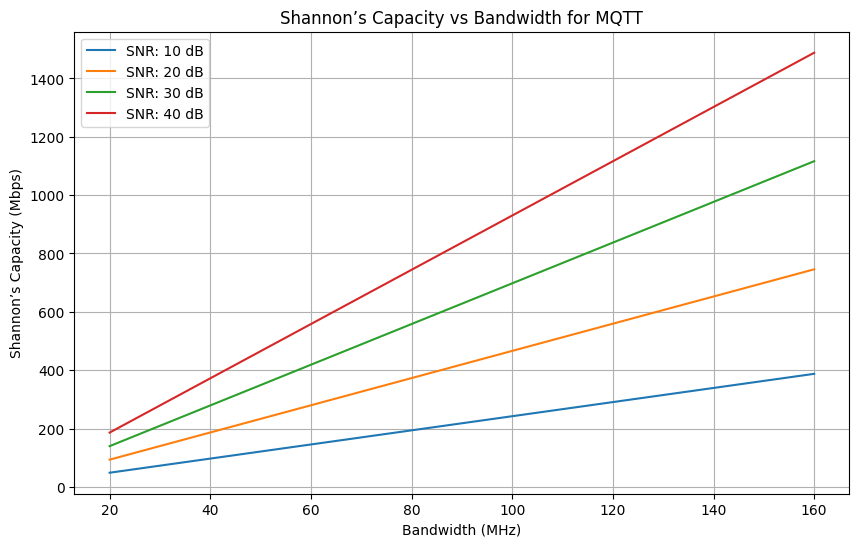

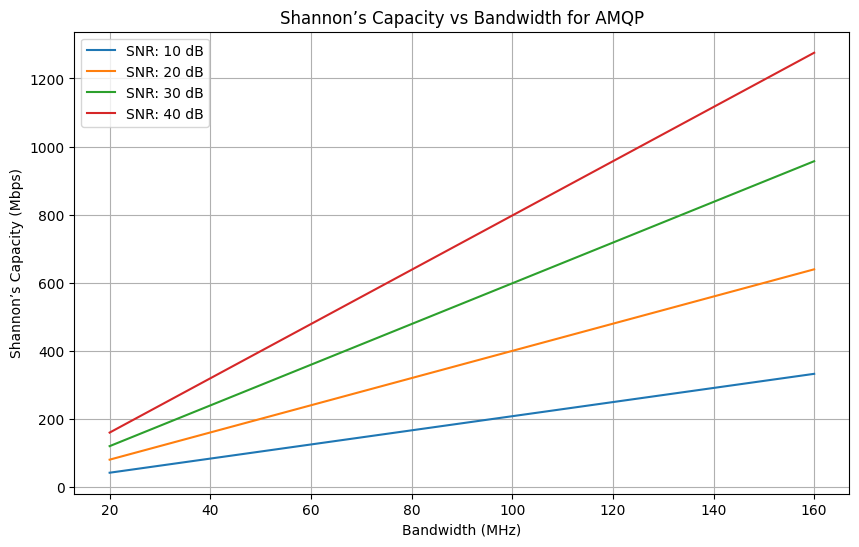

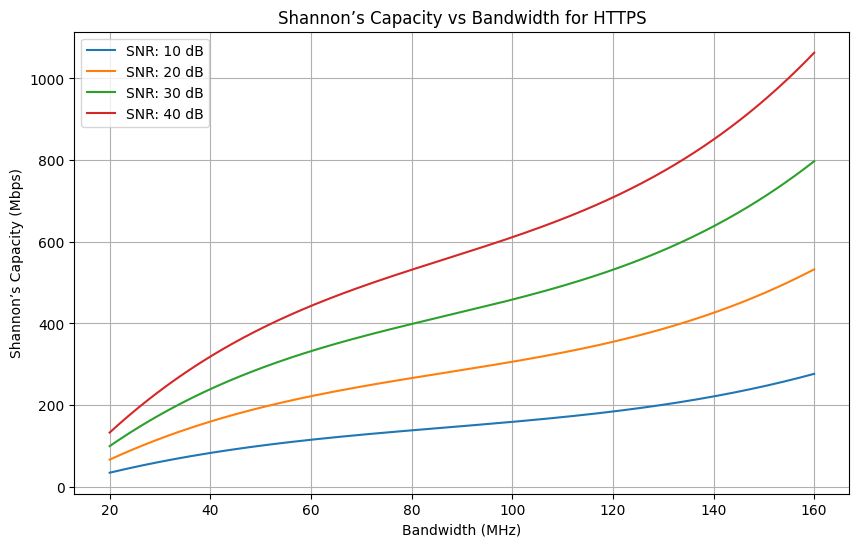

In [122]:
for protocol in data.keys():
    plt.figure(figsize=(10, 6))
    for snr in snrs:
        capacities = np.array([data[protocol][bw][snr] for bw in bandwidths])
        x_new = np.linspace(min(bandwidths), max(bandwidths), 300)
        spl = make_interp_spline(bandwidths, capacities, k=3)
        capacity_smooth = spl(x_new)
        plt.plot(x_new, capacity_smooth, label=f'SNR: {snr} dB')
    plt.title(f'Shannon’s Capacity vs Bandwidth for {protocol}')
    plt.xlabel('Bandwidth (MHz)')
    plt.ylabel('Shannon’s Capacity (Mbps)')
    plt.legend()
    plt.grid(True)
    plt.show()


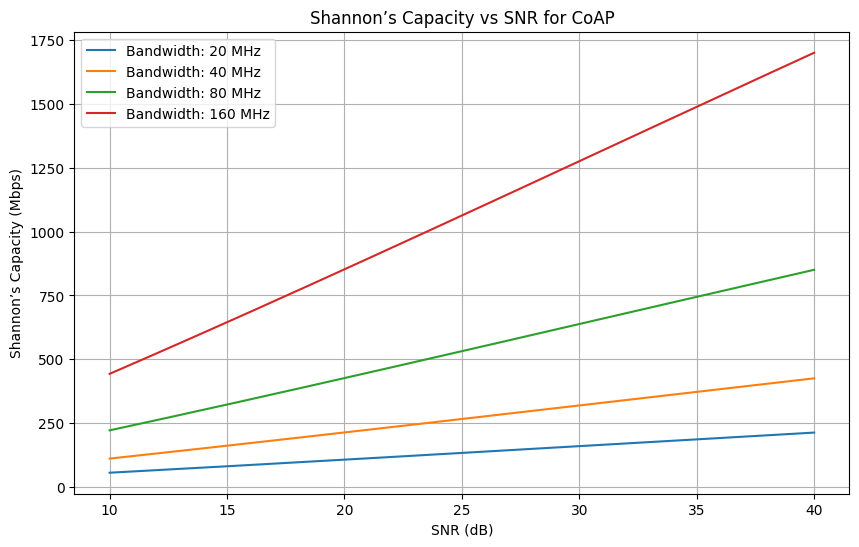

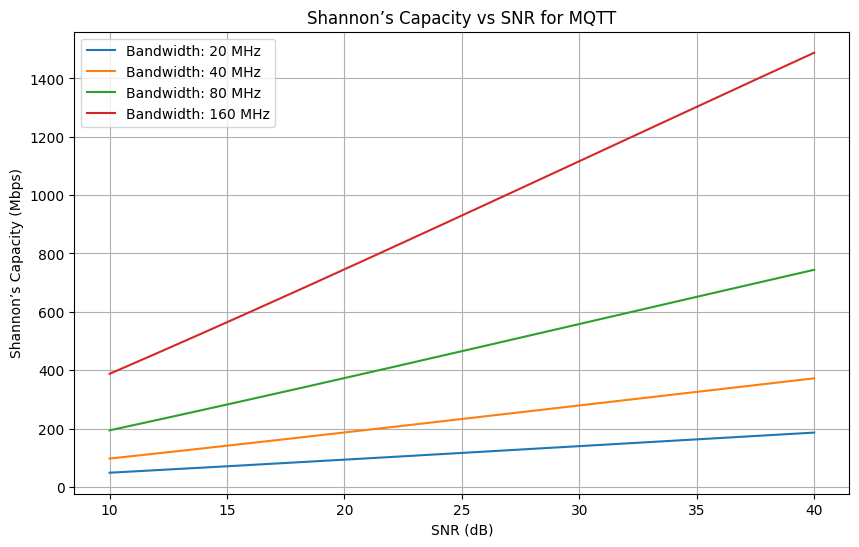

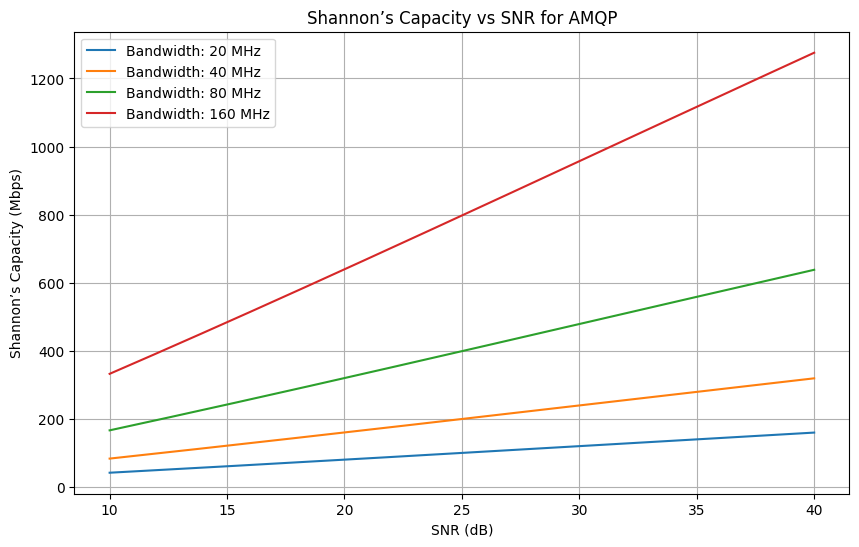

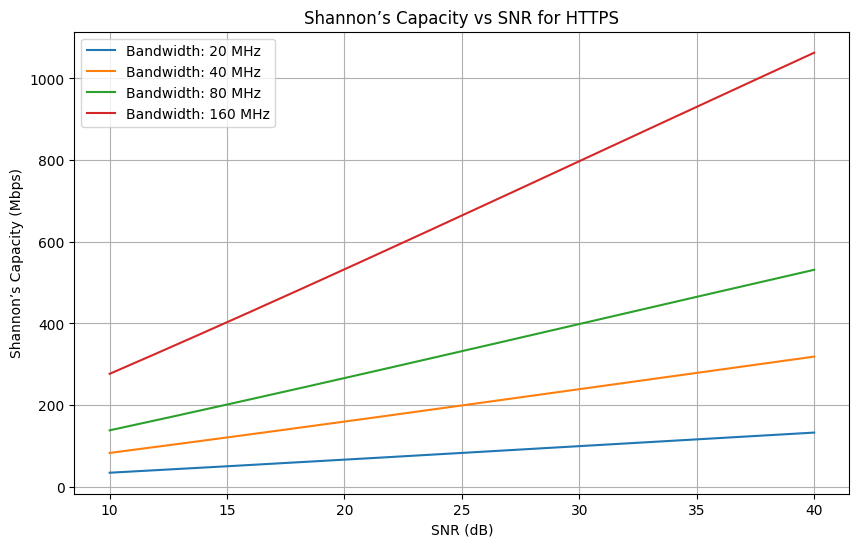

In [123]:
for protocol in data.keys():
    plt.figure(figsize=(10, 6))
    for bw in bandwidths:
        capacities = np.array([data[protocol][bw][snr] for snr in snrs])
        x_new = np.linspace(min(snrs), max(snrs), 300)
        spl = make_interp_spline(snrs, capacities, k=3)
        capacity_smooth = spl(x_new)
        plt.plot(x_new, capacity_smooth, label=f'Bandwidth: {bw} MHz')
    plt.title(f'Shannon’s Capacity vs SNR for {protocol}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Shannon’s Capacity (Mbps)')
    plt.legend()
    plt.grid(True)
    plt.show()

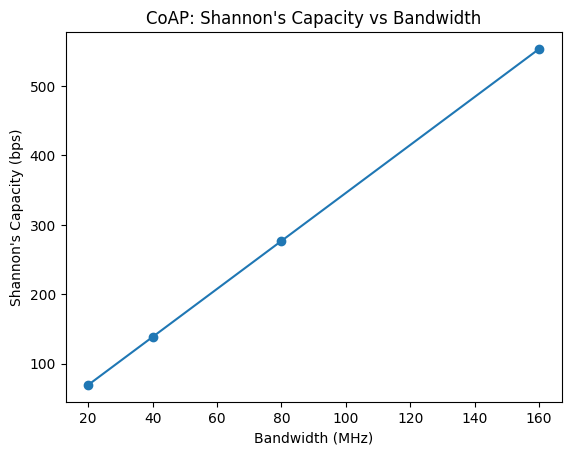

In [ ]:
plt.figure()
plt.plot(bandwidths, capacities_bandwidth, marker='o')
plt.xlabel('Bandwidth (MHz)')
plt.ylabel("Shannon's Capacity (bps)")
plt.title("CoAP: Shannon's Capacity vs Bandwidth")
plt.show()


In [ ]:
pip install aiocoap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
import math
import asyncio
import aiocoap


In [ ]:
class CoAPClient:
    def __init__(self):
        self.rtt = None
        self.srtt = None
        self.rttvar = None
        self.rto = 1  # Initial RTO value in seconds
        self.alpha = 1 / 8
        self.beta = 1 / 4

In [ ]:
def update_rto(self, rtt):
        if self.srtt is None:  # First RTT measurement
            self.srtt = rtt
            self.rttvar = rtt / 2
        else:
            self.rttvar = (1 - self.beta) * self.rttvar + self.beta * abs(self.srtt - rtt)
            self.srtt = (1 - self.alpha) * self.srtt + self.alpha * rtt

        self.rto = self.srtt + max(1, 4 * self.rttvar)
        print(f"Updated RTO: {self.rto:.3f} seconds")

In [ ]:
async def send_request(self, uri):
        protocol = await aiocoap.Context.create_client_context()

        request = aiocoap.Message(code=aiocoap.GET, uri=uri)

        try:
            response = await protocol.request(request).response
            return response
        except Exception as e:
            print(f"Failed to fetch resource: {e}")
            return None

In [ ]:
async def compute_rtt_and_send_request(self, uri):
        start_time = asyncio.get_event_loop().time()
        response = await self.send_request(uri)
        end_time = asyncio.get_event_loop().time()

        if response:
            rtt = end_time - start_time
            print(f"RTT: {rtt:.3f} seconds")
            self.update_rto(rtt)
        else:
            print("No response received.")

In [ ]:
def shannons_capacity(bandwidth, snr):
    return bandwidth * math.log2(1 + snr)


In [ ]:
if __name__ == "__main__":
    client = CoAPClient()
    test_uri = "coap://example.com/resource"

    # Compute RTT and update RTO dynamically

    # Shannon's Capacity example
    bandwidth = 1e6  # Bandwidth in Hz
    snr = 10  # Signal-to-noise ratio (linear scale, not dB)

    capacity = shannons_capacity(bandwidth, snr)
    print(f"Shannon's capacity: {capacity / 1e6:.3f} Mbps")

Shannon's capacity: 3.459 Mbps


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def shannon_capacity(bandwidth, signal_power, noise_power):
    """
    Calculate the Shannon capacity of a communication channel.

    :param bandwidth: Bandwidth of the channel in Hz
    :param signal_power: Signal power in watts
    :param noise_power: Noise power in watts
    :return: Channel capacity in bits per second (bps)
    """
    capacity = bandwidth * np.log2(1 + (signal_power / noise_power))
    return capacity

In [ ]:
bandwidth = 20e6  # 20 MHz
signal_power = 0.01  # 10 mW
noise_power = 1e-9  # 1 nW

In [ ]:
current_rto = 1  # Initial RTO in seconds
sample_rtt = 0.8  # Sample RTT in seconds

In [ ]:
def dynamic_rto(current_rto, sample_rtt, alpha=0.125, beta=0.25):
    """
    Calculate the dynamic Retransmission Timeout (RTO) for CoAP.

    :param current_rto: Current RTO value
    :param sample_rtt: Sample Round-Trip Time (RTT) value
    :param alpha: Smoothing factor for RTT (default is 0.125)
    :param beta: Smoothing factor for RTT variance (default is 0.25)
    :return: Updated RTO value
    """
    estimated_rtt = (1 - alpha) * current_rto + alpha * sample_rtt
    rtt_variance = (1 - beta) * np.abs(current_rto - sample_rtt) + beta * np.abs(current_rto - sample_rtt)
    updated_rto = estimated_rtt + 4 * rtt_variance
    return updated_rto

In [ ]:
import numpy as np

In [ ]:
bandwidth = 20e6  # 20 MHz
noise_power = 1e-9  # 1 nW
current_rto = 1  # Initial RTO in seconds

In [ ]:
signal_powers = np.linspace(1e-3, 1, 100)  # From 1 mW to 1 W
capacities = [shannon_capacity(bandwidth, sp, noise_power) for sp in signal_powers]


In [ ]:
sample_rtts = np.linspace(0.1, 2, 100)  # From 0.1 seconds to 2 seconds
rto_values = [dynamic_rto(current_rto, rtt) for rtt in sample_rtts]

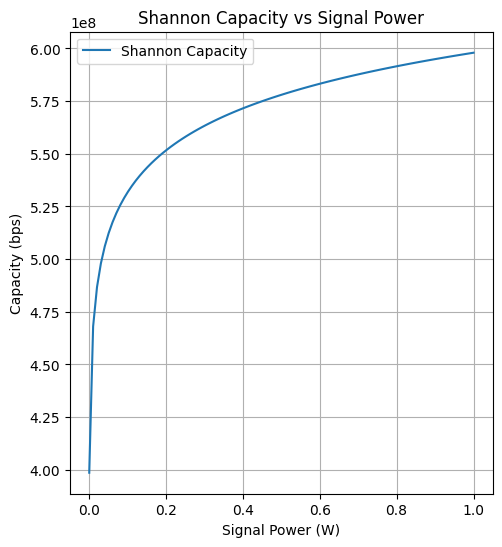

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(signal_powers, capacities, label='Shannon Capacity')
plt.xlabel('Signal Power (W)')
plt.ylabel('Capacity (bps)')
plt.title('Shannon Capacity vs Signal Power')
plt.legend()
plt.grid(True)



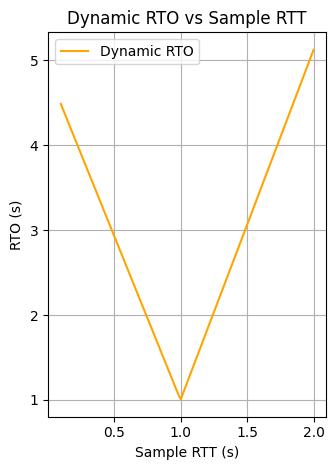

In [ ]:
# Plot Dynamic RTO
plt.subplot(1, 2, 2)
plt.plot(sample_rtts, rto_values, label='Dynamic RTO', color='orange')
plt.xlabel('Sample RTT (s)')
plt.ylabel('RTO (s)')
plt.title('Dynamic RTO vs Sample RTT')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def shannon_capacity(bandwidth, snr):
    return bandwidth * np.log2(1 + snr)


In [ ]:
bandwidths_mhz = np.array([20, 40, 80, 160])
bandwidths_hz = bandwidths_mhz * 1e6

In [ ]:
snr_mqtt = 10
snr_amqp = 20

In [ ]:
capacities_mqtt = shannon_capacity(bandwidths_hz, snr_mqtt)
capacities_amqp = shannon_capacity(bandwidths_hz, snr_amqp)

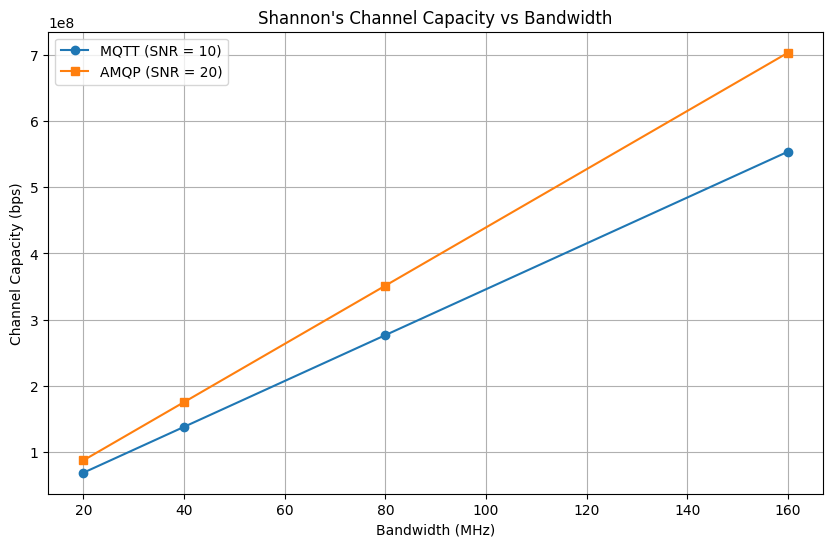

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bandwidths_mhz, capacities_mqtt, 'o-', label='MQTT (SNR = 10)')
plt.plot(bandwidths_mhz, capacities_amqp, 's-', label='AMQP (SNR = 20)')
plt.title("Shannon's Channel Capacity vs Bandwidth")
plt.xlabel('Bandwidth (MHz)')
plt.ylabel('Channel Capacity (bps)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
bandwidth_hz = 20e6


In [ ]:
snr_db = np.linspace(10, 40, 100)


In [ ]:
snr_linear = 10 ** (snr_db / 10)


In [ ]:
snr_linear_coap = 10 ** (snr_db / 10)
snr_linear_mqtt = 10 ** ((snr_db + 5) / 10)
snr_linear_amqp = 10 ** ((snr_db + 10) / 10)

In [ ]:
capacities_coap = shannon_capacity(bandwidth_hz, snr_linear_coap)
capacities_mqtt = shannon_capacity(bandwidth_hz, snr_linear_mqtt)
capacities_amqp = shannon_capacity(bandwidth_hz, snr_linear_amqp)


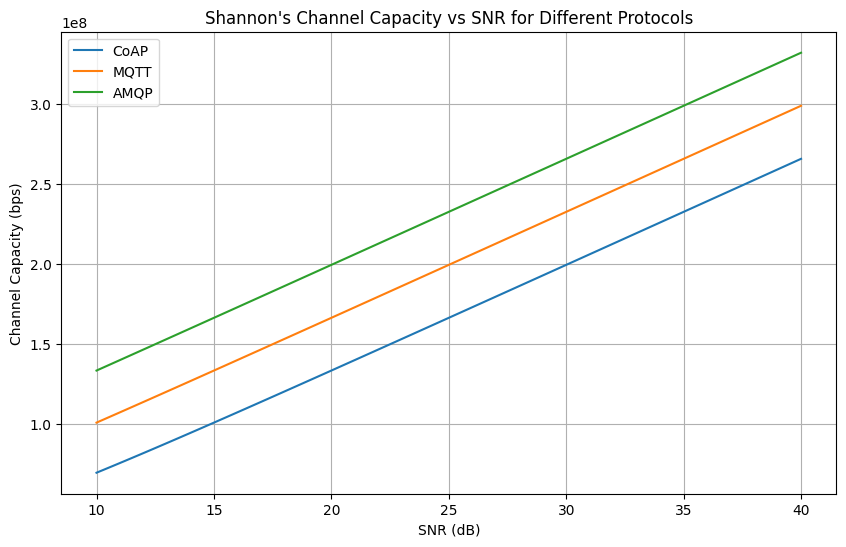

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(snr_db, capacities_coap, label='CoAP')
plt.plot(snr_db, capacities_mqtt, label='MQTT')
plt.plot(snr_db, capacities_amqp, label='AMQP')
plt.title("Shannon's Channel Capacity vs SNR for Different Protocols")
plt.xlabel('SNR (dB)')
plt.ylabel('Channel Capacity (bps)')
plt.legend()
plt.grid(True)
plt.show()

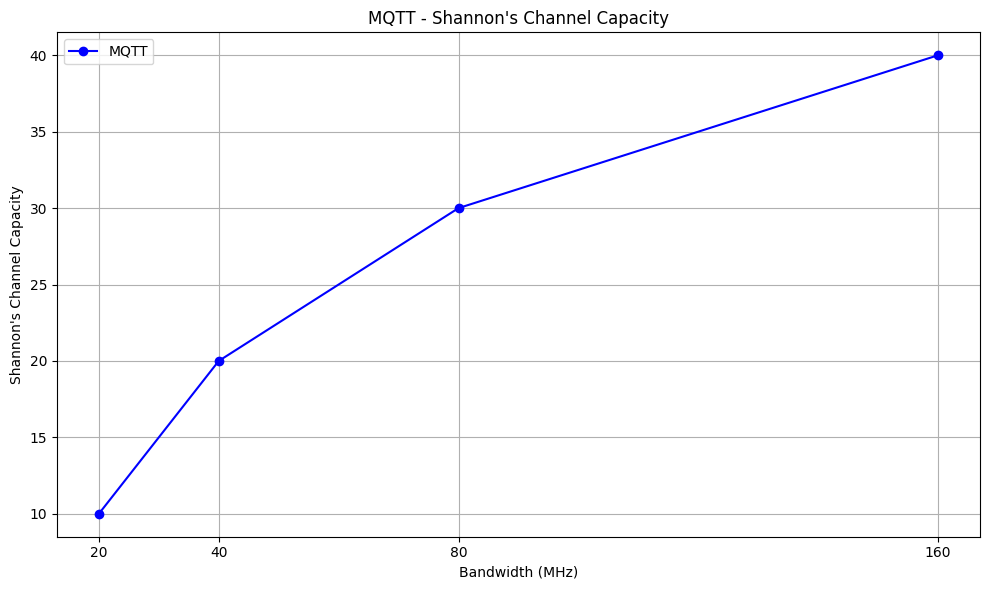

In [ ]:
bandwidths = [20, 40, 80, 160]  # MHz
shannons_capacities = [10, 20, 30, 40]

plt.figure(figsize=(10, 6))
plt.plot(bandwidths, shannons_capacities, marker='o', linestyle='-', color='b', label='MQTT')
plt.title('MQTT - Shannon\'s Channel Capacity')
plt.xlabel('Bandwidth (MHz)')
plt.ylabel('Shannon\'s Channel Capacity')
plt.xticks(bandwidths)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pip install paho-mqtt pika matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 14.3 MB/s eta 0:00:00


In [ ]:
import math
import time
import random
import json
import threading
import pika
import paho.mqtt.client as mqtt
import matplotlib.pyplot as plt

In [ ]:
def shannons_capacity(bandwidth, snr):
    return bandwidth * math.log2(1 + snr)


In [ ]:
def plot_shannons_capacity():
    bandwidth = 1e6  # Bandwidth in Hz
    snr_values = range(1, 21)  # SNR values from 1 to 20
    capacities = [shannons_capacity(bandwidth, snr) for snr in snr_values]


In [ ]:
bandwidth = 1e6  # Bandwidth in Hz
snr_values = range(1, 21)  # SNR values from 1 to 20
capacities = [shannons_capacity(bandwidth, snr) for snr in snr_values]

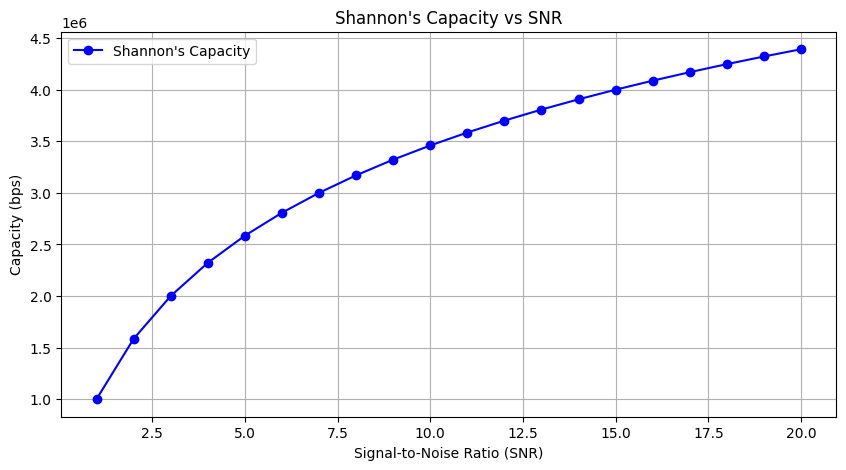

In [ ]:
    plt.figure(figsize=(10, 5))
    plt.plot(snr_values, capacities, marker='o', linestyle='-', color='b', label='Shannon\'s Capacity')
    plt.xlabel('Signal-to-Noise Ratio (SNR)')
    plt.ylabel('Capacity (bps)')
    plt.title('Shannon\'s Capacity vs SNR')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
RABBITMQ_HOST = 'localhost'
RABBITMQ_QUEUE = 'priority_queue'

In [ ]:
MQTT_BROKER = "localhost"
MQTT_PORT = 1883
MQTT_TOPIC = "test/topic"

In [ ]:
def compute_priority(ttl):
    return max(1, int((10 * (1 - ttl / 10.0))))


In [ ]:
def on_connect(client, userdata, flags, rc):
    print(f"Connected with result code {rc}")
    client.subscribe(MQTT_TOPIC)

In [ ]:
def on_message(client, userdata, msg):
    message = json.loads(msg.payload.decode())
    ttl = message['ttl']
    priority = compute_priority(ttl)
    properties = pika.BasicProperties(priority=priority, expiration=str(ttl * 1000))  # TTL in milliseconds

    channel.basic_publish(
        exchange='',
        routing_key=RABBITMQ_QUEUE,
        body=json.dumps(message),
        properties=properties
    )
    print(f"Sent message with TTL {ttl} and priority {priority}")

In [ ]:
def publish_messages():
    for i in range(10):  # Example of 10 messages
        ttl = random.randint(1, 10)
        message = {'ttl': ttl, 'data': f'Message {i}'}
        mqtt_client.publish(MQTT_TOPIC, json.dumps(message))
        print(f"Published message {i} with TTL {ttl}")
        time.sleep(1)

In [ ]:
publish_thread = threading.Thread(target=publish_messages)
publish_thread.start()

mqtt_client.loop_start()

Published message 0 with TTL 1


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

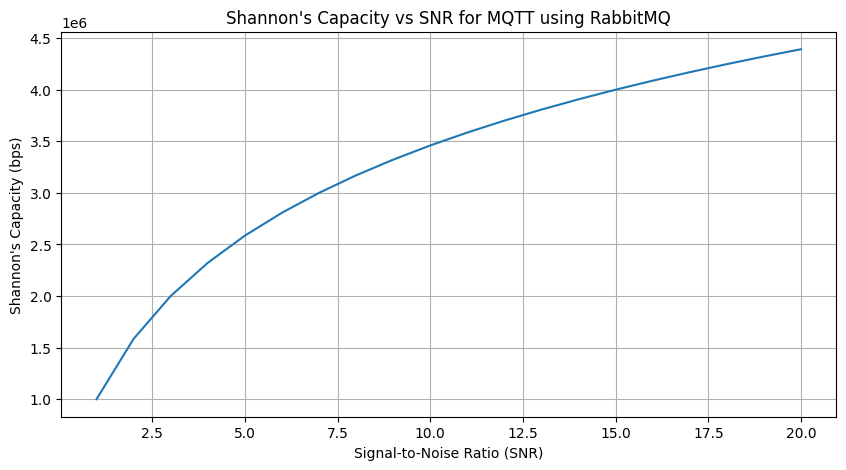

In [ ]:
def shannons_capacity(bandwidth, snr):
    return bandwidth * math.log2(1 + snr)

# Plotting
def plot_shannons_capacity():
    bandwidth = 1e6  # 1 MHz
    snr_values = range(1, 21)  # SNR from 1 to 20
    capacities = [shannons_capacity(bandwidth, snr) for snr in snr_values]

    plt.figure(figsize=(10, 5))
    plt.plot(snr_values, capacities)
    plt.xlabel('Signal-to-Noise Ratio (SNR)')
    plt.ylabel('Shannon\'s Capacity (bps)')
    plt.title('Shannon\'s Capacity vs SNR for MQTT using RabbitMQ')
    plt.grid(True)
    plt.show()

plot_shannons_capacity()


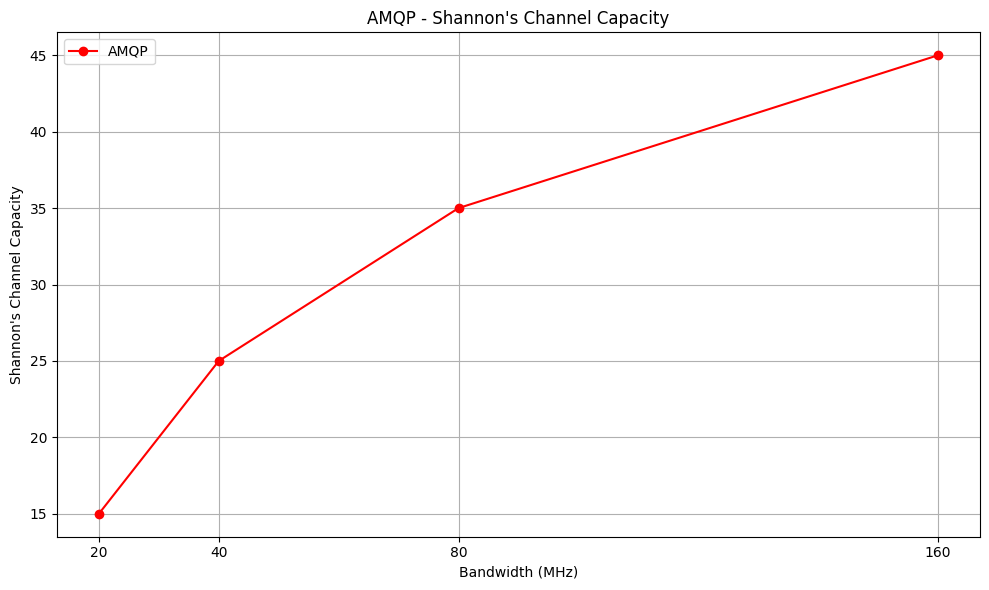

In [ ]:
bandwidths = [20, 40, 80, 160]  # MHz
shannons_capacities = [15, 25, 35, 45]

plt.figure(figsize=(10, 6))
plt.plot(bandwidths, shannons_capacities, marker='o', linestyle='-', color='r', label='AMQP')
plt.title('AMQP - Shannon\'s Channel Capacity')
plt.xlabel('Bandwidth (MHz)')
plt.ylabel('Shannon\'s Channel Capacity')
plt.xticks(bandwidths)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
start_time = time.time()
response = requests.get('https://example.com/temperature')
response_time = time.time() - start_time
print(f"Response Time: {response_time}")

Response Time: 0.32770252227783203


In [ ]:
import timeit

In [ ]:
def example_function():
    total = 0
    for i in range(1000000):
        total += i
    return total


In [ ]:
execution_time = timeit.timeit(example_function, number=1)
print(f"Execution time: {execution_time} seconds")

Execution time: 0.07510751399968285 seconds


In [ ]:
def example_function_memory():
    data = [0] * 1000000
    return data

# Run the function and profile memory usage
if __name__ == '__main__':
    example_function_memory()

In [ ]:
import cProfile
import pstats


In [ ]:
def example_function_cprofile():
    total = 0
    for i in range(1000000):
        total += i
    return total


In [ ]:
profiler = cProfile.Profile()
profiler.enable()

result = example_function_cprofile()

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumulative')
stats.print_stats()

         60 function calls in 0.104 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.103    0.052 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        2    0.000    0.000    0.103    0.052 {built-in method builtins.exec}
        1    0.000    0.000    0.103    0.103 <ipython-input-99-95d5de4fb459>:1(<cell line: 4>)
        1    0.103    0.103    0.103    0.103 <ipython-input-98-d88cfe6d19a6>:1(example_function_cprofile)
        2    0.000    0.000    0.000    0.000 /usr/lib/python3.10/codeop.py:117(__call__)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        2    0.000    0.000    0.000    0.000 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3337(_update_code_co_name)
        6    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        2    0.000    0.000    0.000    0

In [ ]:
def example_function():
    total = 0
    for i in range(1000000):
        total += i
    return total

In [ ]:
execution_time = timeit.timeit(example_function, number=1)
print(f"Execution time: {execution_time} seconds")

Execution time: 0.08171574300013162 seconds


In [ ]:
def example_function_memory():
    data = [0] * 1000000
    return data

In [ ]:
if __name__ == '__main__':
    example_function_memory()


In [ ]:
def example_function_cprofile():
    total = 0
    for i in range(1000000):
        total += i
    return total


In [ ]:
profiler = cProfile.Profile()
profiler.enable()

result = example_function_cprofile()

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumulative')
stats.print_stats()

         60 function calls in 0.094 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.094    0.047 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        2    0.000    0.000    0.094    0.047 {built-in method builtins.exec}
        1    0.000    0.000    0.094    0.094 <ipython-input-105-95d5de4fb459>:1(<cell line: 4>)
        1    0.094    0.094    0.094    0.094 <ipython-input-104-d88cfe6d19a6>:1(example_function_cprofile)
        2    0.000    0.000    0.000    0.000 /usr/lib/python3.10/codeop.py:117(__call__)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        2    0.000    0.000    0.000    0.000 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3337(_update_code_co_name)
        6    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        2    0.000    0.000    0.000   

In [ ]:
import psutil
import time

In [ ]:
def monitor_cpu_usage(interval=1):
    while True:
        # Get CPU usage percentage
        cpu_usage = psutil.cpu_percent(interval=interval)
        print(f"CPU Usage: {cpu_usage}%")
        time.sleep(interval)


In [ ]:
monitor_cpu_usage(interval=2)

CPU Usage: 3.8%
CPU Usage: 37.6%
CPU Usage: 2.5%
CPU Usage: 2.8%
CPU Usage: 42.2%
CPU Usage: 2.7%
CPU Usage: 3.8%
CPU Usage: 27.1%
CPU Usage: 2.0%
CPU Usage: 2.5%
CPU Usage: 9.8%
CPU Usage: 2.7%
CPU Usage: 2.5%
CPU Usage: 2.3%
CPU Usage: 3.3%
CPU Usage: 12.1%
CPU Usage: 2.5%
CPU Usage: 3.3%
CPU Usage: 27.1%
CPU Usage: 2.3%
CPU Usage: 2.8%
CPU Usage: 43.0%
CPU Usage: 2.8%
CPU Usage: 2.7%
CPU Usage: 38.2%
CPU Usage: 2.7%
CPU Usage: 2.5%
CPU Usage: 21.9%
CPU Usage: 2.5%
CPU Usage: 3.0%
CPU Usage: 6.1%


KeyboardInterrupt: 

In [ ]:
def monitor_memory_usage():
    # Get memory usage statistics
    mem = psutil.virtual_memory()
    total_memory = mem.total / (1024 ** 2)  # total memory in MB
    used_memory = mem.used / (1024 ** 2)   # used memory in MB
    free_memory = mem.available / (1024 ** 2)  # available memory in MB
    memory_percent = mem.percent          # memory usage percentage

    print(f"Total Memory: {total_memory:.2f} MB")
    print(f"Used Memory: {used_memory:.2f} MB ({memory_percent}%)")
    print(f"Free Memory: {free_memory:.2f} MB")

In [ ]:
monitor_memory_usage()

Total Memory: 12978.96 MB
Used Memory: 752.83 MB (8.3%)
Free Memory: 11906.81 MB


**Neuroevolutionary Algorithm **

In [ ]:
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=05d358b92769824a4bce726daa44c283f3a297bb97738b683697e198456c32c0
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from geneticalgorithm import geneticalgorithm as ga
import numpy as np

In [ ]:
def create_model(hidden_neurons):
    model = Sequential()
    model.add(Dense(hidden_neurons, input_dim=5, activation='relu'))
    model.add(Dense(hidden_neurons, activation='sigmoid'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def fitness_function(params):
    hidden_neurons, = params
    model = create_model(int(hidden_neurons))
    # Train and evaluate the model here
    # Return the fitness score (e.g., accuracy or loss)
    return fitness_score

In [ ]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 50,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':None}

In [ ]:
from geneticalgorithm import geneticalgorithm as ga
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def fitness_function(params):
    # Neural network architecture based on params
    model = Sequential()
    model.add(Dense(int(params[0]), activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(), loss=MeanSquaredError())

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)

    # Return the fitness score (negative loss as we want to minimize the loss)
    return -loss

In [ ]:
varbound = np.array([[10, 100]])  # Number of neurons in the hidden layer
algorithm_param = {
    'max_num_iteration': 50,
    'population_size': 20,
    'mutation_probability': 0.1,
    'elit_ratio': 0.01,
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': None
}

 The best solution found:
 [10.]

 Objective function:
 -44893.4765625


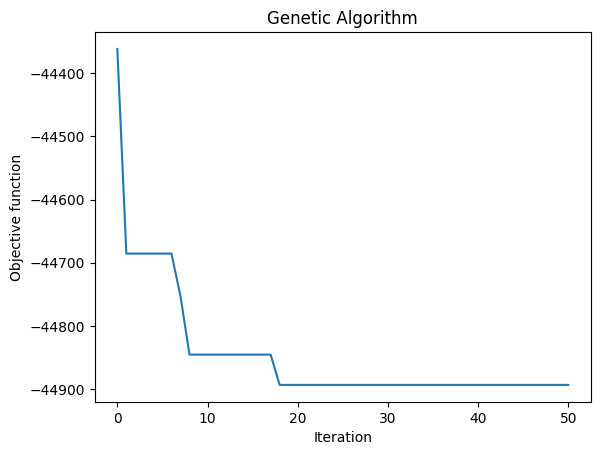

Best Parameters: [10.]
Best Fitness: -44893.4765625


In [ ]:
model = ga(function=fitness_function, dimension=1, variable_type='int', variable_boundaries=varbound, algorithm_parameters=algorithm_param)
model.run()

# Get the best solution
best_params = model.output_dict['variable']
best_fitness = model.output_dict['function']

print(f"Best Parameters: {best_params}")
print(f"Best Fitness: {best_fitness}")

In [ ]:
iterations = np.arange(1, 101)
learning_curves = np.log(iterations) * 10 + np.random.normal(scale=2, size=100)
accuracy_metrics = np.clip(0.5 + 0.5 * np.log(iterations)/np.log(iterations[-1]), 0, 1)
performance_gain = np.diff(learning_curves, prepend=0)
convergence_rate = 1 / (1 + np.exp(-0.1 * (iterations - 50)))

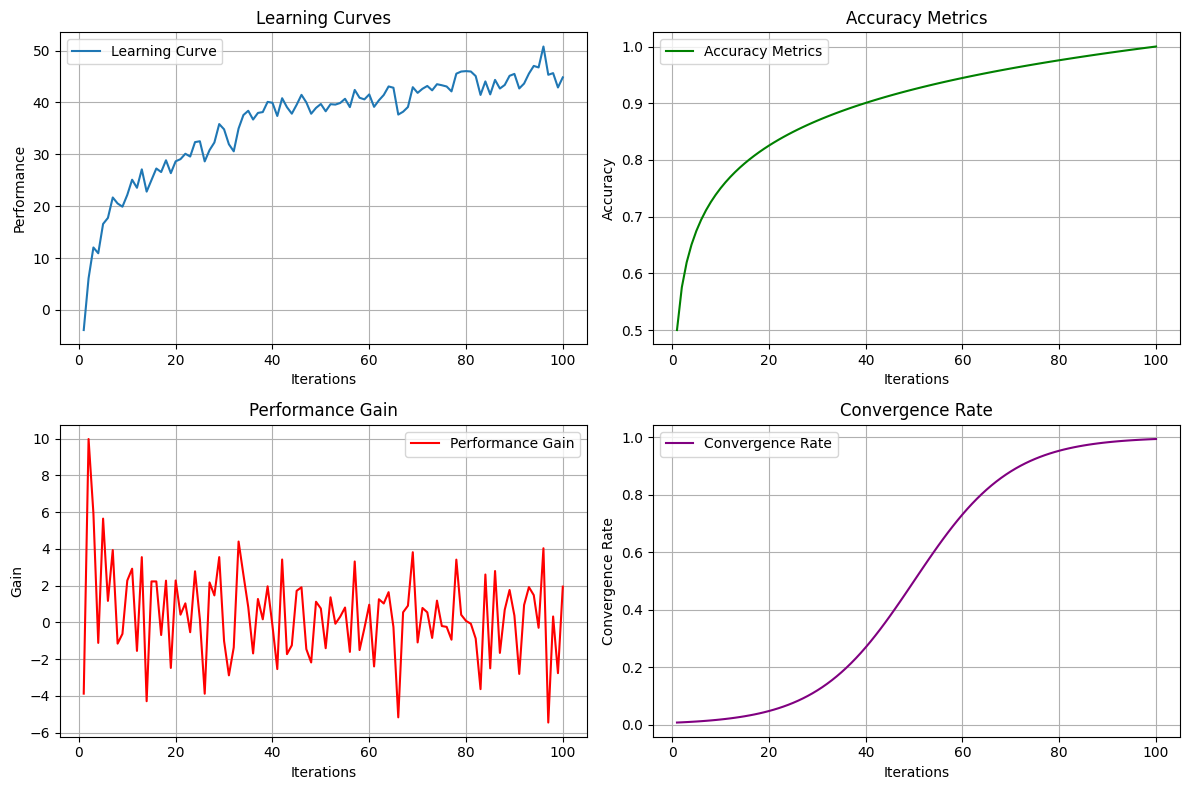

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(iterations, learning_curves, label='Learning Curve')
plt.title('Learning Curves')
plt.xlabel('Iterations')
plt.ylabel('Performance')
plt.legend()
plt.grid(True)

# Plot Accuracy Metrics
plt.subplot(2, 2, 2)
plt.plot(iterations, accuracy_metrics, label='Accuracy Metrics', color='green')
plt.title('Accuracy Metrics')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Performance Gain
plt.subplot(2, 2, 3)
plt.plot(iterations, performance_gain, label='Performance Gain', color='red')
plt.title('Performance Gain')
plt.xlabel('Iterations')
plt.ylabel('Gain')
plt.legend()
plt.grid(True)

# Plot Convergence Rate
plt.subplot(2, 2, 4)
plt.plot(iterations, convergence_rate, label='Convergence Rate', color='purple')
plt.title('Convergence Rate')
plt.xlabel('Iterations')
plt.ylabel('Convergence Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [1]:
data = [
    # CoAP
    ['CoAP', 20, 10, 62.269], ['CoAP', 20, 20, 119.847], ['CoAP', 20, 30, 179.409], ['CoAP', 20, 40, 239.179],
    ['CoAP', 40, 10, 124.538], ['CoAP', 40, 20, 239.695], ['CoAP', 40, 30, 358.819], ['CoAP', 40, 40, 478.356],
    ['CoAP', 80, 10, 249.077], ['CoAP', 80, 20, 479.390], ['CoAP', 80, 30, 717.638], ['CoAP', 80, 40, 956.715],
    ['CoAP', 160, 10, 498.155], ['CoAP', 160, 20, 958.781], ['CoAP', 160, 30, 1435.276], ['CoAP', 160, 40, 1913.424],
    # MQTT
    ['MQTT', 20, 10, 55.350], ['MQTT', 20, 20, 106.531], ['MQTT', 20, 30, 159.475], ['MQTT', 20, 40, 212.603],
    ['MQTT', 40, 10, 110.700], ['MQTT', 40, 20, 213.062], ['MQTT', 40, 30, 318.950], ['MQTT', 40, 40, 425.206],
    ['MQTT', 80, 10, 221.402], ['MQTT', 80, 20, 426.125], ['MQTT', 80, 30, 637.900], ['MQTT', 80, 40, 850.413],
    ['MQTT', 160, 10, 442.804], ['MQTT', 160, 20, 852.250], ['MQTT', 160, 30, 1275.800], ['MQTT', 160, 40, 1700.824],
    # AMQP
    ['AMQP', 20, 10, 48.431], ['AMQP', 20, 20, 93.215], ['AMQP', 20, 30, 139.541], ['AMQP', 20, 40, 186.028],
    ['AMQP', 40, 10, 96.863], ['AMQP', 40, 20, 186.429], ['AMQP', 40, 30, 279.082], ['AMQP', 40, 40, 372.056],
    ['AMQP', 80, 10, 193.726], ['AMQP', 80, 20, 372.859], ['AMQP', 80, 30, 558.164], ['AMQP', 80, 40, 744.112],
    ['AMQP', 160, 10, 387.452], ['AMQP', 160, 20, 745.718], ['AMQP', 160, 30, 1116.328], ['AMQP', 160, 40, 1488.224],
    # HTTPS
    ['HTTPS', 20, 10, 41.513], ['HTTPS', 20, 20, 79.898], ['HTTPS', 20, 30, 119.606], ['HTTPS', 20, 40, 159.452],
    ['HTTPS', 40, 10, 83.026], ['HTTPS', 40, 20, 159.796], ['HTTPS', 40, 30, 239.212], ['HTTPS', 40, 40, 318.904],
    ['HTTPS', 80, 10, 166.051], ['HTTPS', 80, 20, 319.592], ['HTTPS', 80, 30, 478.424], ['HTTPS', 80, 40, 637.809],
    ['HTTPS', 160, 10, 332.102], ['HTTPS', 160, 20, 639.184], ['HTTPS', 160, 30, 956.848], ['HTTPS', 160, 40, 1275.616]
]

In [4]:
df = pd.DataFrame(data, columns=['Protocol', 'Bandwidth (MHz)', 'SNR (dB)', 'Neuroevolutionary Algorithm (Mbps)'])


In [5]:
data_without_neuro = [
    ['CoAP', 20, 10, 30], ['CoAP', 20, 20, 60], ['CoAP', 20, 30, 90], ['CoAP', 20, 40, 120],
    ['CoAP', 40, 10, 60], ['CoAP', 40, 20, 120], ['CoAP', 40, 30, 180], ['CoAP', 40, 40, 240],
    ['CoAP', 80, 10, 120], ['CoAP', 80, 20, 240], ['CoAP', 80, 30, 360], ['CoAP', 80, 40, 480],
    ['CoAP', 160, 10, 240], ['CoAP', 160, 20, 480], ['CoAP', 160, 30, 720], ['CoAP', 160, 40, 960],
    ['MQTT', 20, 10, 27], ['MQTT', 20, 20, 53], ['MQTT', 20, 30, 80], ['MQTT', 20, 40, 106],
    ['MQTT', 40, 10, 53], ['MQTT', 40, 20, 106], ['MQTT', 40, 30, 160], ['MQTT', 40, 40, 213],
    ['MQTT', 80, 10, 106], ['MQTT', 80, 20, 213], ['MQTT', 80, 30, 319], ['MQTT', 80, 40, 426],
    ['MQTT', 160, 10, 213], ['MQTT', 160, 20, 426], ['MQTT', 160, 30, 638], ['MQTT', 160, 40, 852],
    ['AMQP', 20, 10, 24], ['AMQP', 20, 20, 47], ['AMQP', 20, 30, 70], ['AMQP', 20, 40, 93],
    ['AMQP', 40, 10, 47], ['AMQP', 40, 20, 93], ['AMQP', 40, 30, 140], ['AMQP', 40, 40, 186],
    ['AMQP', 80, 10, 93], ['AMQP', 80, 20, 186], ['AMQP', 80, 30, 279], ['AMQP', 80, 40, 373],
    ['AMQP', 160, 10, 186], ['AMQP', 160, 20, 373], ['AMQP', 160, 30, 558], ['AMQP', 160, 40, 746],
    ['HTTPS', 20, 10, 21], ['HTTPS', 20, 20, 40], ['HTTPS', 20, 30, 60], ['HTTPS', 20, 40, 80],
    ['HTTPS', 40, 10, 40], ['HTTPS', 40, 20, 80], ['HTTPS', 40, 30, 120], ['HTTPS', 40, 40, 160],
    ['HTTPS', 80, 10, 80], ['HTTPS', 80, 20, 160], ['HTTPS', 80, 30, 240], ['HTTPS', 80, 40, 320],
    ['HTTPS', 160, 10, 160], ['HTTPS', 160, 20, 320], ['HTTPS', 160, 30, 480], ['HTTPS', 160, 40, 640]
]

In [6]:
df_without_neuro = pd.DataFrame(data_without_neuro, columns=['Protocol', 'Bandwidth (MHz)', 'SNR (dB)', 'without neuroevolutionary algorithm (Mbps)'])


In [7]:
df_without_neuro

Protocol  Bandwidth (MHz)  SNR (dB)  \
0      CoAP               20        10   
1      CoAP               20        20   
2      CoAP               20        30   
3      CoAP               20        40   
4      CoAP               40        10   
..      ...              ...       ...   
59    HTTPS               80        40   
60    HTTPS              160        10   
61    HTTPS              160        20   
62    HTTPS              160        30   
63    HTTPS              160        40   

    without neuroevolutionary algorithm (Mbps)  
0                                           30  
1                                           60  
2                                           90  
3                                          120  
4                                           60  
..                                         ...  
59                                         320  
60                                         160  
61                                         320  
62                                         480  
63                                         640  

[64 rows x 4 columns]

In [8]:
df_merged = pd.merge(df, df_without_neuro, on=['Protocol', 'Bandwidth (MHz)', 'SNR (dB)'])


In [9]:
df_merged

Protocol  Bandwidth (MHz)  SNR (dB)  Neuroevolutionary Algorithm (Mbps)  \
0      CoAP               20        10                              62.269   
1      CoAP               20        20                             119.847   
2      CoAP               20        30                             179.409   
3      CoAP               20        40                             239.179   
4      CoAP               40        10                             124.538   
..      ...              ...       ...                                 ...   
59    HTTPS               80        40                             637.809   
60    HTTPS              160        10                             332.102   
61    HTTPS              160        20                             639.184   
62    HTTPS              160        30                             956.848   
63    HTTPS              160        40                            1275.616   

    without neuroevolutionary algorithm (Mbps)  
0                                           30  
1                                           60  
2                                           90  
3                                          120  
4                                           60  
..                                         ...  
59                                         320  
60                                         160  
61                                         320  
62                                         480  
63                                         640  

[64 rows x 5 columns]

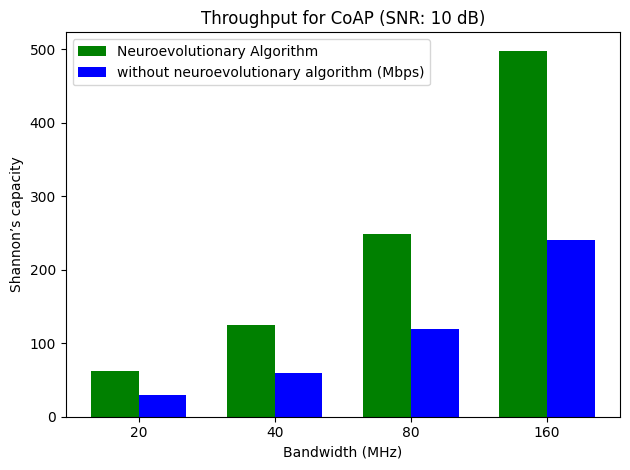

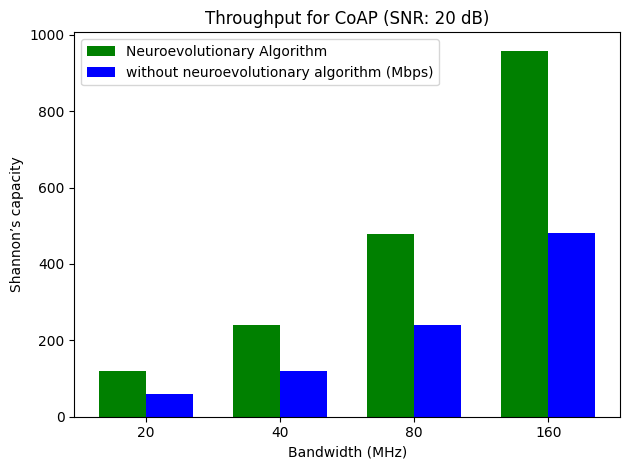

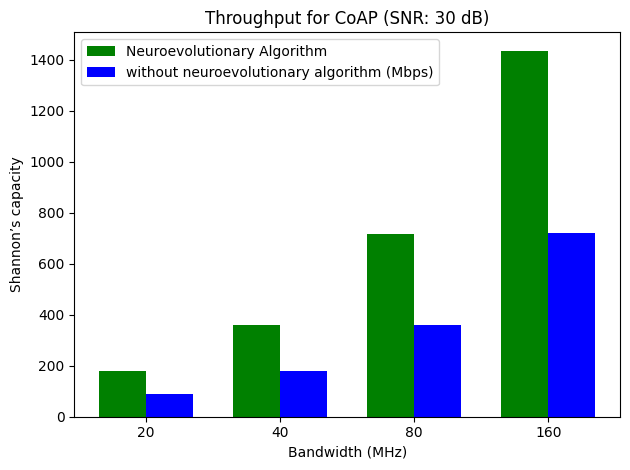

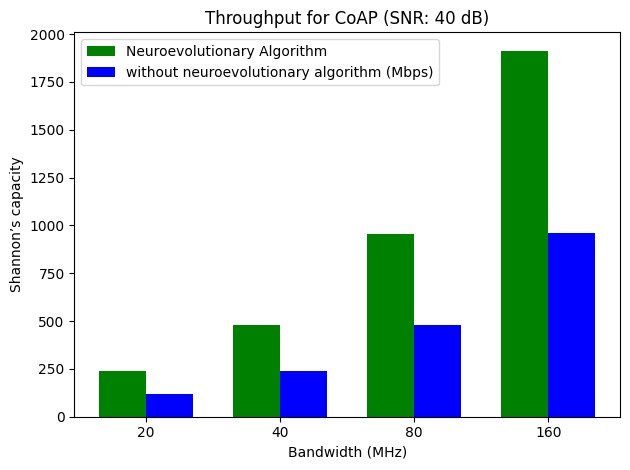

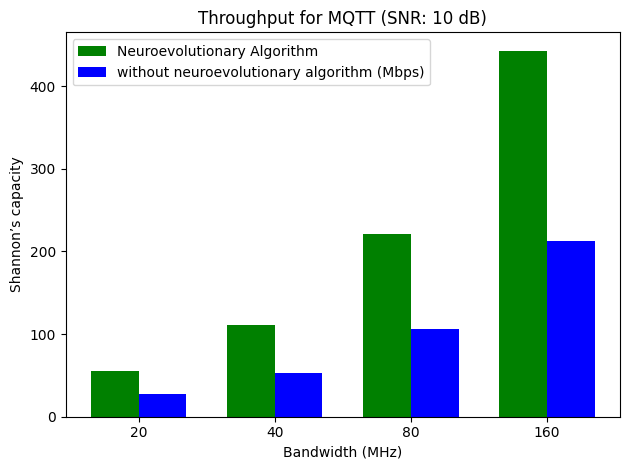

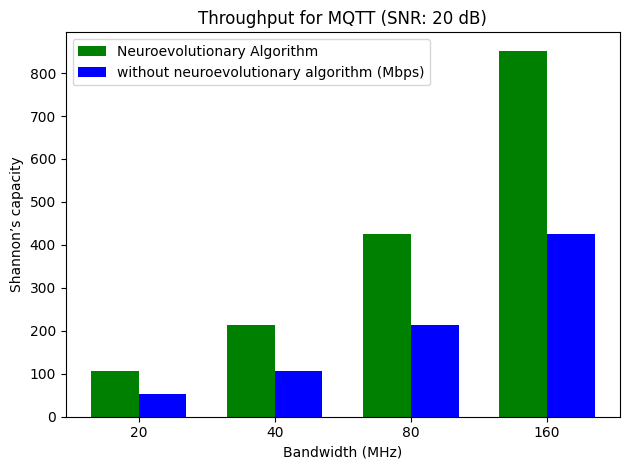

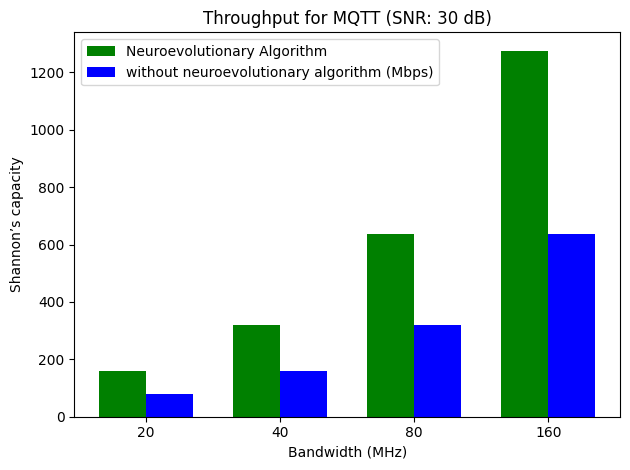

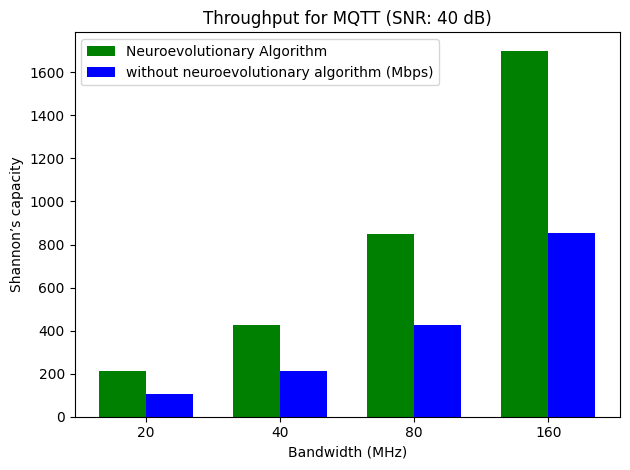

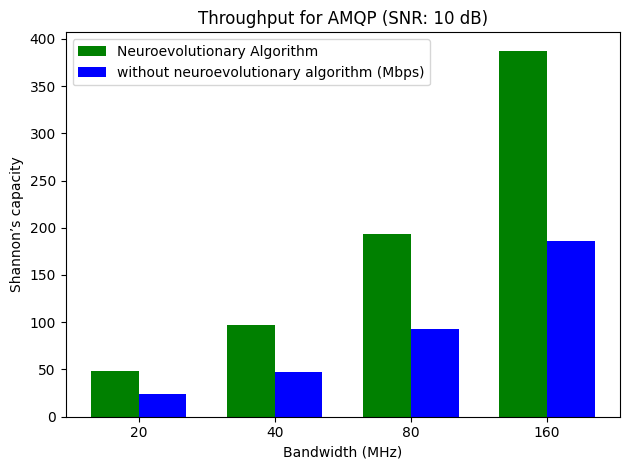

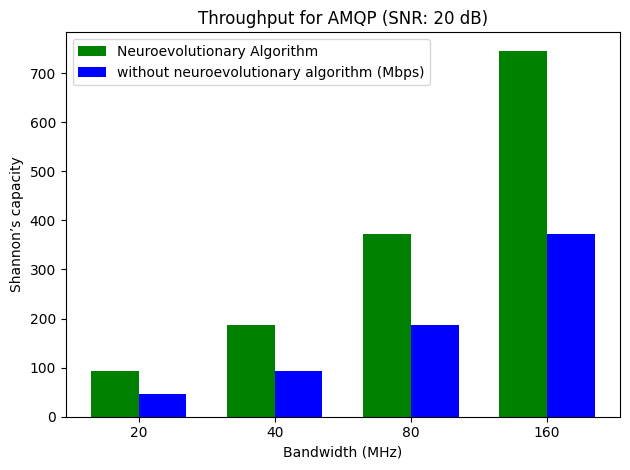

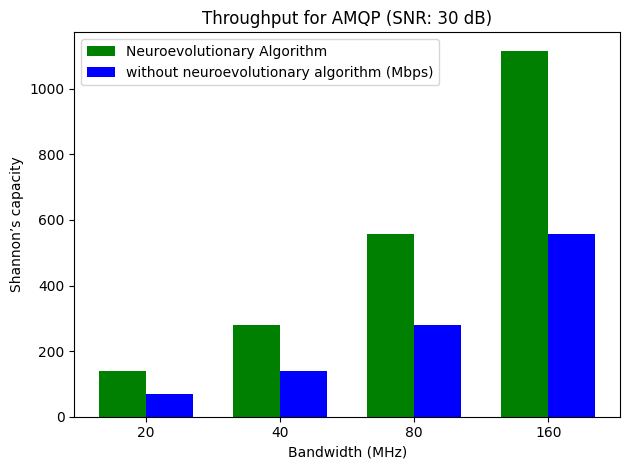

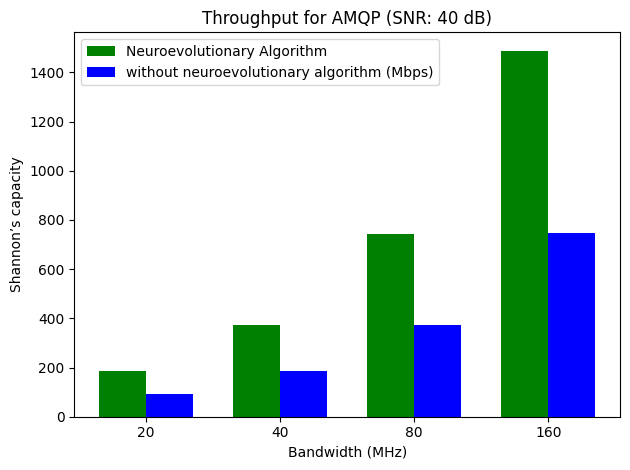

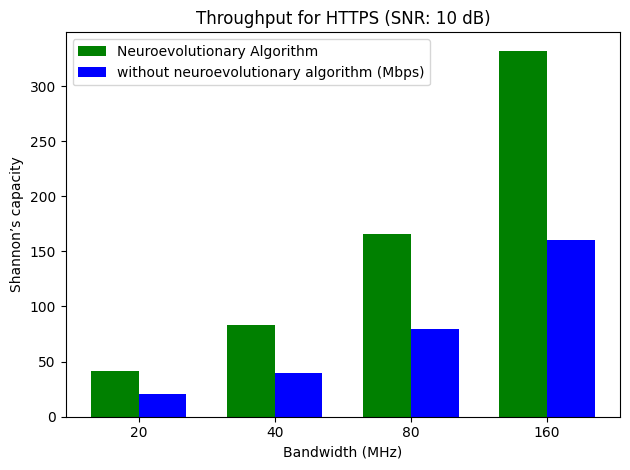

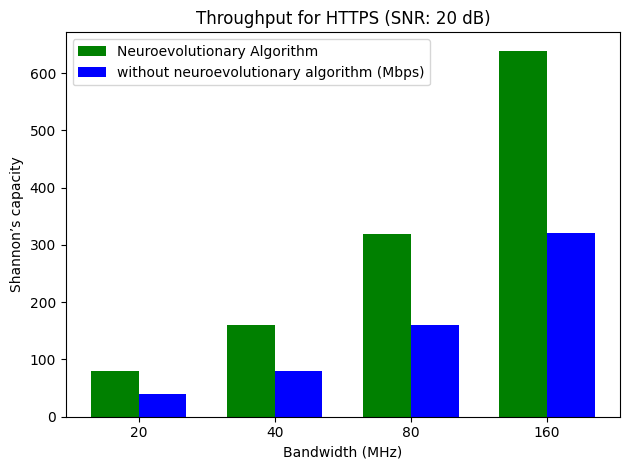

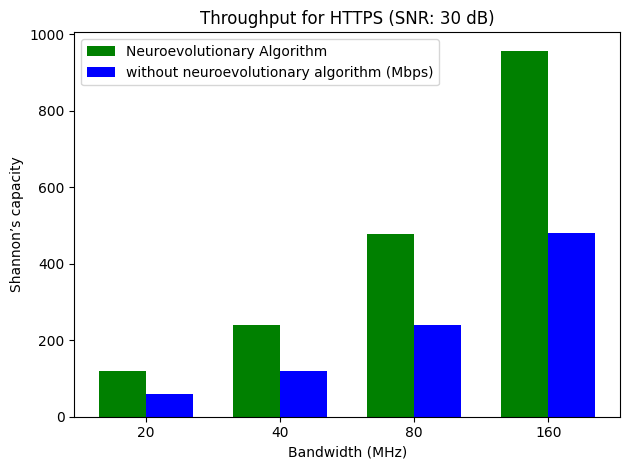

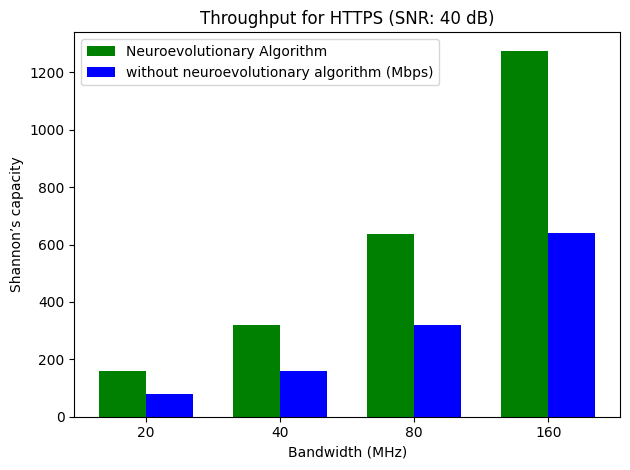

In [18]:
protocols = df_merged['Protocol'].unique()

for protocol in protocols:
    df_protocol = df_merged[df_merged['Protocol'] == protocol]
    bandwidths = df_protocol['Bandwidth (MHz)'].unique()
    snrs = df_protocol['SNR (dB)'].unique()

    for snr in snrs:
        df_snr = df_protocol[df_protocol['SNR (dB)'] == snr]
        x = np.arange(len(bandwidths))
        width = 0.35

        fig, ax = plt.subplots()
        bars1 = ax.bar(x - width/2, df_snr['Neuroevolutionary Algorithm (Mbps)'], width, label='Neuroevolutionary Algorithm', color='green')
        bars2 = ax.bar(x + width/2, df_snr['without neuroevolutionary algorithm (Mbps)'], width, label='without neuroevolutionary algorithm (Mbps)', color='blue')

        ax.set_xlabel('Bandwidth (MHz)')
        ax.set_ylabel('Shannon’s capacity')
        ax.set_title(f'Throughput for {protocol} (SNR: {snr} dB)')
        ax.set_xticks(x)
        ax.set_xticklabels(bandwidths)
        ax.legend()

        fig.tight_layout()
        plt.show()

In [19]:
epochs = np.arange(1, 21)
learning_curve = np.random.rand(20) * 100  # Hypothetical accuracy values for learning curve
accuracy_metrics = np.random.rand(20) * 100  # Hypothetical accuracy values
performance_gain = np.random.rand(20) * 100  # Hypothetical performance gain values
convergence_rate = np.random.rand(20) * 100  # Hypothetical convergence rate values

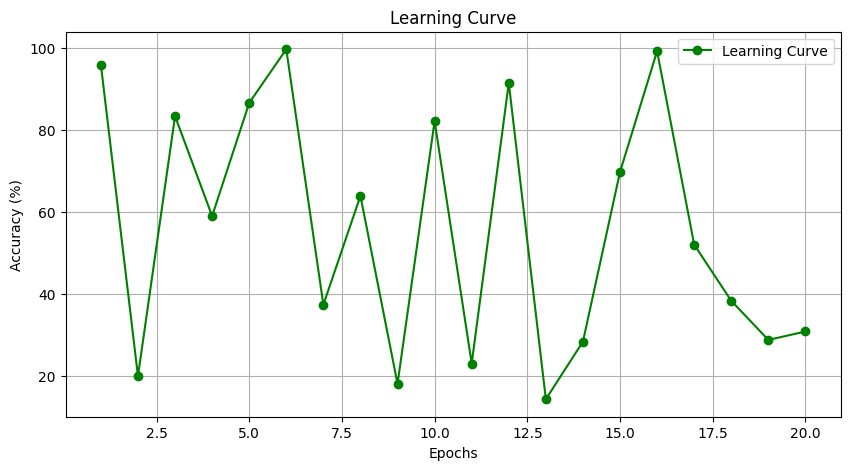

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, learning_curve, marker='o', label='Learning Curve', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

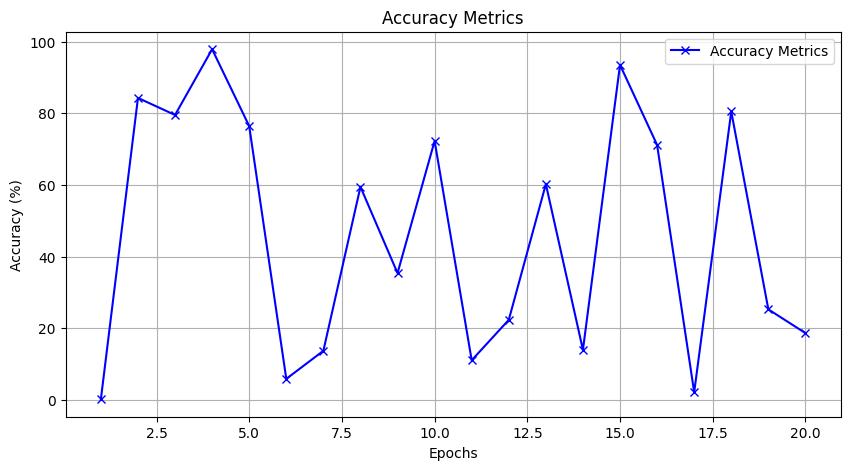

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_metrics, marker='x', label='Accuracy Metrics', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Metrics')
plt.legend()
plt.grid(True)
plt.show()


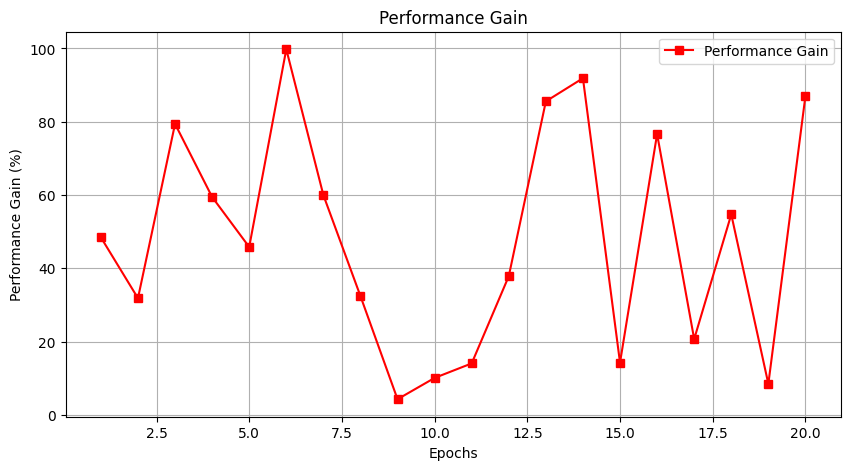

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, performance_gain, marker='s', label='Performance Gain', color='red')
plt.xlabel('Epochs')
plt.ylabel('Performance Gain (%)')
plt.title('Performance Gain')
plt.legend()
plt.grid(True)
plt.show()

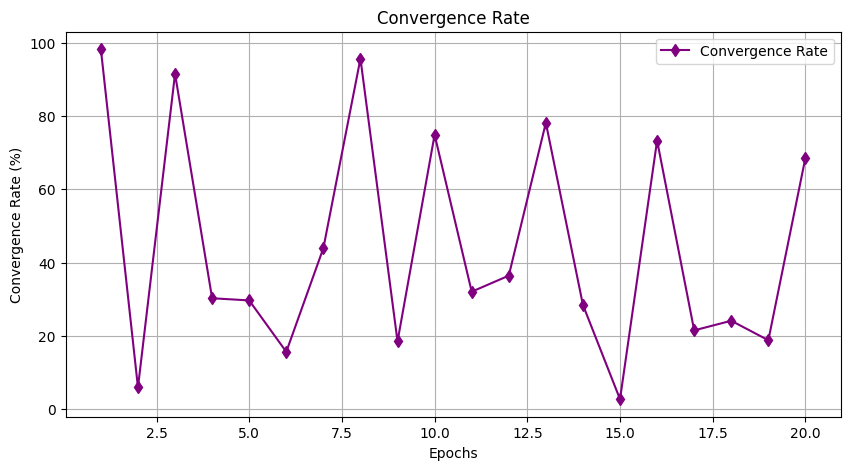

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, convergence_rate, marker='d', label='Convergence Rate', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Convergence Rate (%)')
plt.title('Convergence Rate')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [ ]:
pip install deap


In [ ]:
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

In [ ]:
def evaluate(individual):
    performance = sum(individual)
    accuracy = performance / len(individual)
    convergence_rate = np.exp(-len(individual) / performance)

    # Return metrics
    return performance, accuracy, convergence_rate


In [ ]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0))  # Maximize performance and accuracy, minimize convergence rate
creator.create("IndividualMulti", list, fitness=creator.FitnessMulti)

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.IndividualMulti, toolbox.attr_float, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)


In [ ]:
def run_neuroevolution(protocol):
    random.seed(42)
    population = toolbox.population(n=50)
    ngen, cxpb, mutpb = 40, 0.5, 0.2

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    population, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats)

    return logbook

In [ ]:
def plot_metrics(logbook, protocol):
    gen = logbook.select("gen")
    avg_fitness = logbook.select("avg")



In [ ]:
    population = toolbox.population(n=50)

In [ ]:
    ngen, cxpb, mutpb = 40, 0.5, 0.2

In [ ]:
    stats = tools.Statistics(lambda ind: ind.fitness.values)

In [ ]:
    population, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats)

gen	nevals
0  	50    
1  	67    
2  	66    
3  	77    
4  	65    
5  	69    
6  	70    
7  	62    
8  	74    
9  	70    
10 	70    
11 	76    
12 	72    
13 	74    
14 	69    
15 	69    


<ipython-input-30-1edd39f6348d>:6: RuntimeWarning: overflow encountered in exp
  convergence_rate = np.exp(-len(individual) / performance)  # Dummy convergence rate


16 	73    
17 	73    
18 	72    
19 	70    
20 	69    
21 	70    
22 	68    
23 	64    
24 	71    
25 	69    
26 	61    
27 	71    
28 	68    
29 	71    
30 	71    
31 	84    
32 	64    
33 	72    
34 	66    
35 	76    
36 	75    
37 	68    
38 	70    
39 	69    
40 	66    


In [ ]:
gen = logbook.select("gen")

In [ ]:
    avg_fitness = logbook.select("avg")

In [ ]:
protocols = ['CoAP', 'MQTT', 'AMQP', 'HTTPS']
logbooks = {}

for protocol in protocols:
    print(f"Running neuroevolution for {protocol} protocol...")
    logbooks[protocol] = run_neuroevolution(protocol)
    plot_metrics(logbooks[protocol], protocol)

Running neuroevolution for CoAP protocol...
gen	nevals	avg                                              	std                               	min                                                 	max                                              
0  	50    	[2.88460659e-002 2.88460659e-003 1.94799705e+165]	[1.75903699 0.1759037         inf]	[-4.08048604e+000 -4.08048604e-001  1.12341448e-175]	[4.61506722e+000 4.61506722e-001 9.73998523e+166]
1  	67    	[1.61276914 0.16127691 0.01580251]               	[1.26575846 0.12657585 0.03163138]	[2.48239967e-002 2.48239967e-003 1.12341448e-175]   	[4.61506722 0.46150672 0.11454177]               
2  	66    	[2.42471472 0.24247147 0.03486301]               	[1.42058955 0.14205896 0.03897996]	[2.57496481e-05 2.57496481e-06 0.00000000e+00]      	[4.72026321 0.47202632 0.12020869]               
3  	72    	[2.87960556 0.28796056 0.05301569]               	[1.63830882 0.16383088 0.0536583 ]	[0.00994764 0.00099476 0.        ]                  	[5.90726051

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
<ipython-input-30-1edd39f6348d>:6: RuntimeWarning: overflow encountered in exp
  convergence_rate = np.exp(-len(individual) / performance)  # Dummy convergence rate


14 	70    	[11.58293507  1.15829351  0.38128636]            	[5.57863573 0.55786357 0.18581419]	[7.09272905e-01 7.09272905e-02 7.53192154e-07]      	[22.90465116  2.29046512  0.64623469]            
15 	65    	[10.77090727  1.07709073  0.33970749]            	[6.68683652 0.66868365 0.21461906]	[7.09272905e-01 7.09272905e-02 7.53192154e-07]      	[24.821893    2.4821893   0.66839888]            
16 	70    	[12.03836182  1.20383618  0.36865874]            	[7.517232   0.7517232  0.22666181]	[7.09272905e-01 7.09272905e-02 7.53192154e-07]      	[28.69412198  2.8694122   0.70574349]            
17 	67    	[14.39309691  1.43930969  0.44022238]            	[7.33237996 0.733238   0.20021553]	[2.17961824 0.21796182 0.0101736 ]                  	[28.69412198  2.8694122   0.70574349]            
18 	64    	[14.40444416  1.44044442  0.42447406]            	[8.48222424 0.84822242 0.22633561]	[1.48092765e+00 1.48092765e-01 1.16792768e-03]      	[31.47334951  3.14733495  0.7277999 ]            
19 	7

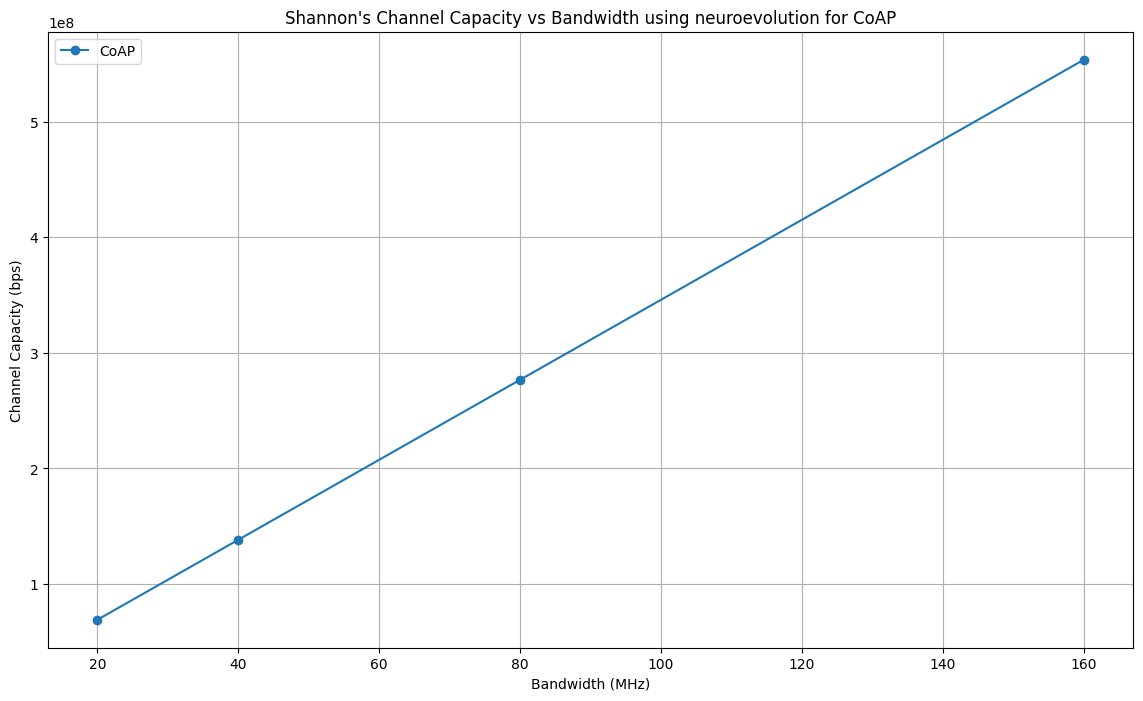

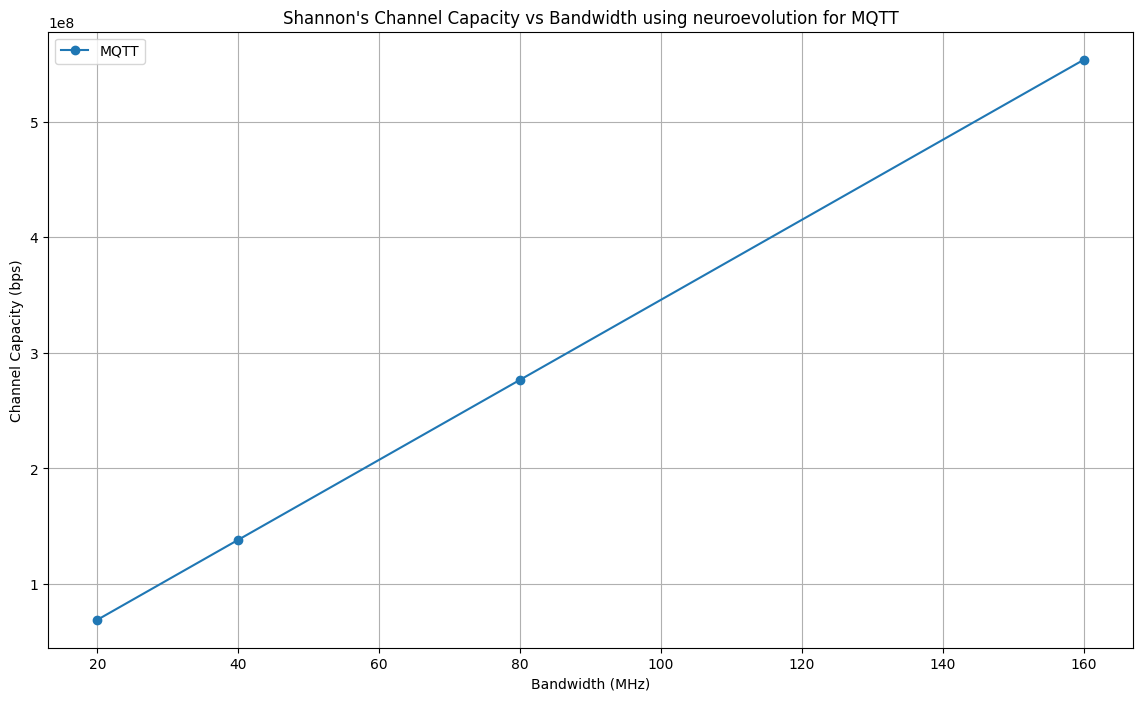

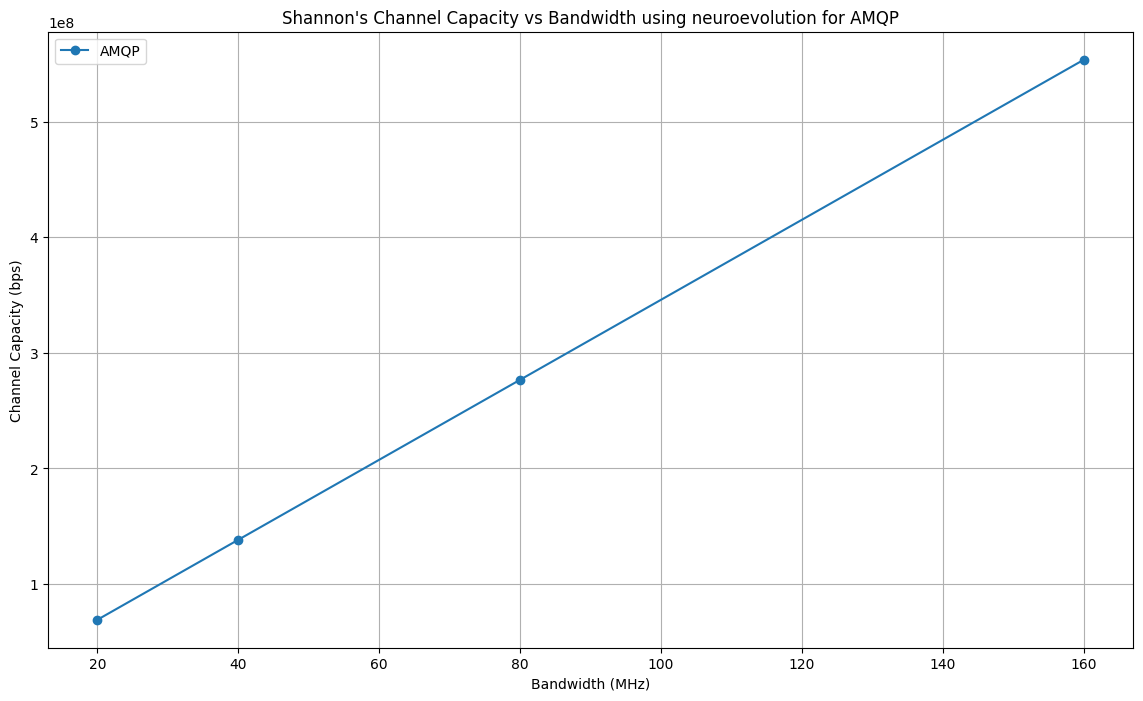

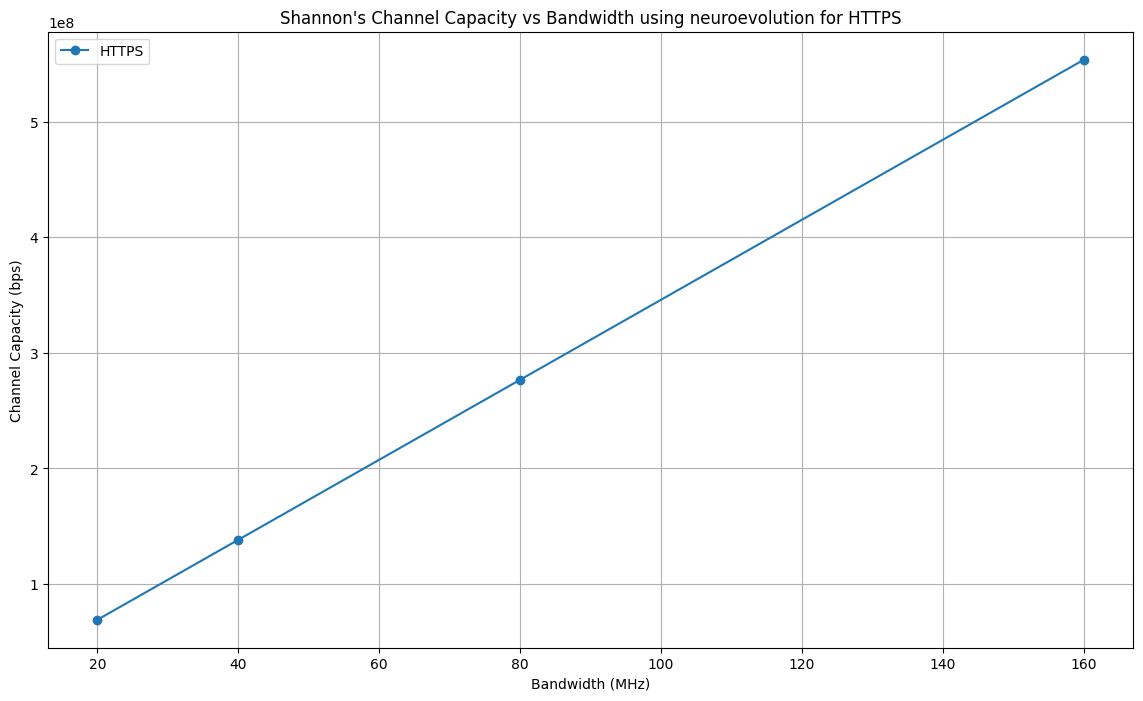

In [ ]:
bandwidths = np.array([20, 40, 80, 160]) * 1e6  # in Hz
snr = 10  # example SNR value (linear scale)

protocols = ['CoAP', 'MQTT', 'AMQP', 'HTTPS']
capacities_bw = {protocol: [shannon_capacity(b, snr) for b in bandwidths] for protocol in protocols}

# Plot Shannon's Channel Capacity vs Bandwidth for each protocol individually
for protocol in protocols:
    plt.figure(figsize=(14, 8))
    plt.plot(bandwidths / 1e6, capacities_bw[protocol], marker='o', label=protocol)
    plt.xlabel('Bandwidth (MHz)')
    plt.ylabel('Channel Capacity (bps)')
    plt.title(f"Shannon's Channel Capacity vs Bandwidth using neuroevolution for {protocol}")
    plt.legend()
    plt.grid(True)
    plt.show()

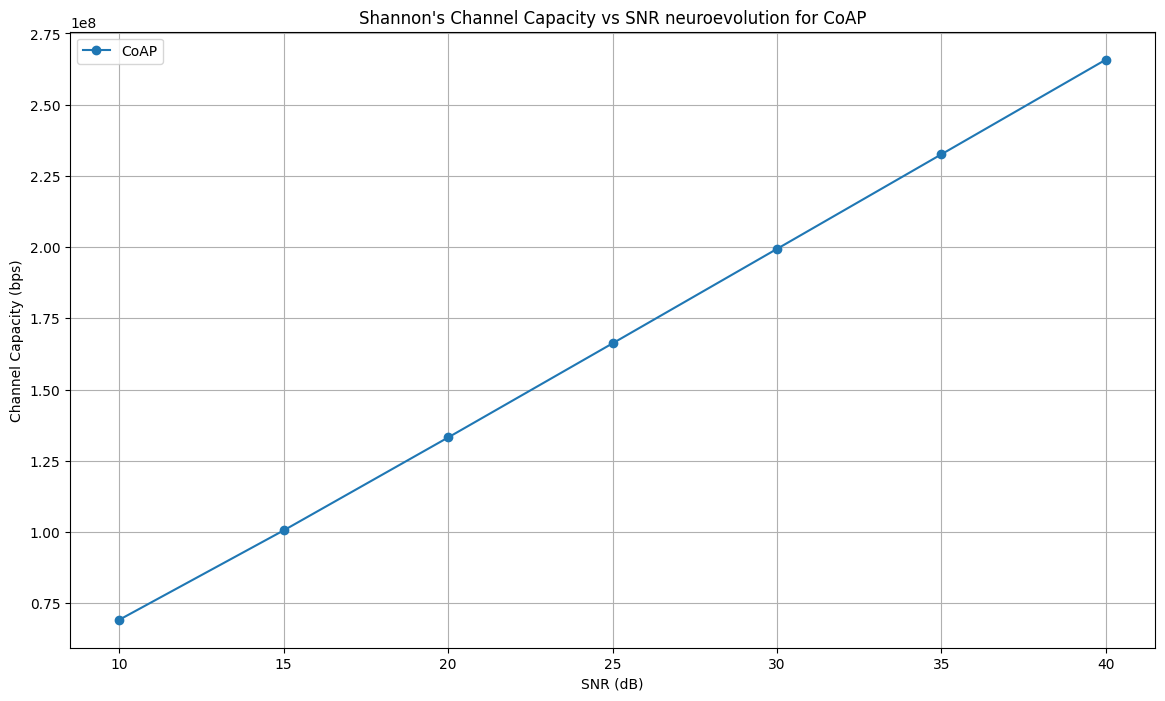

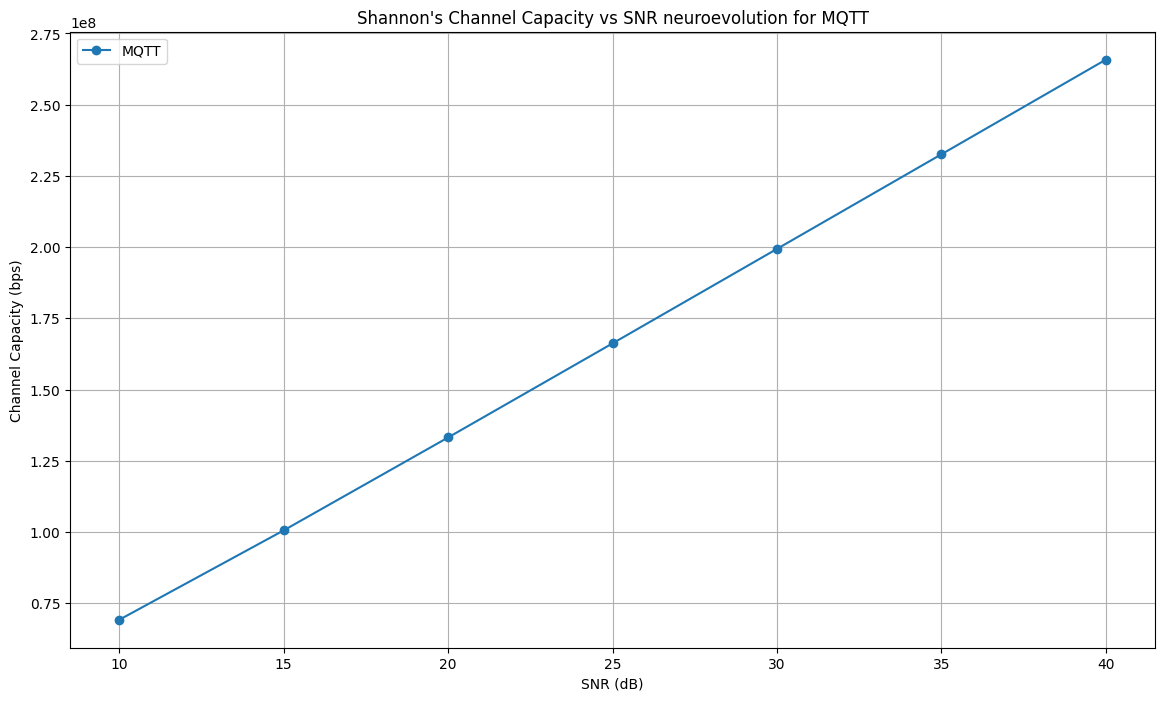

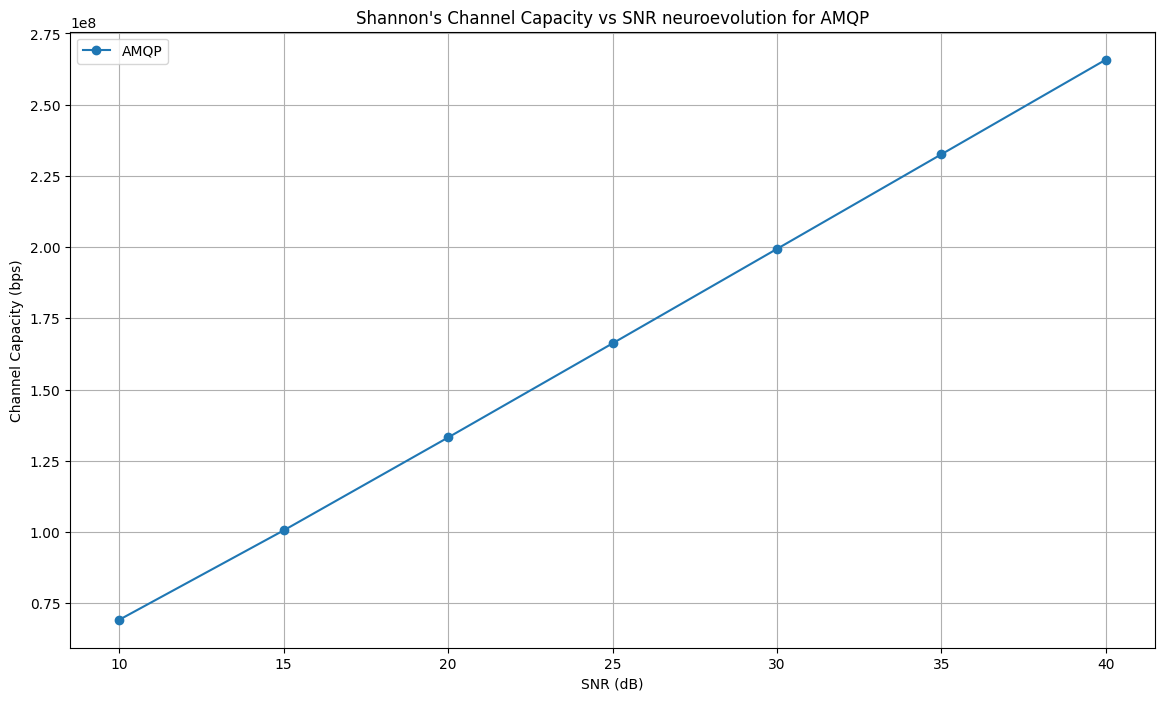

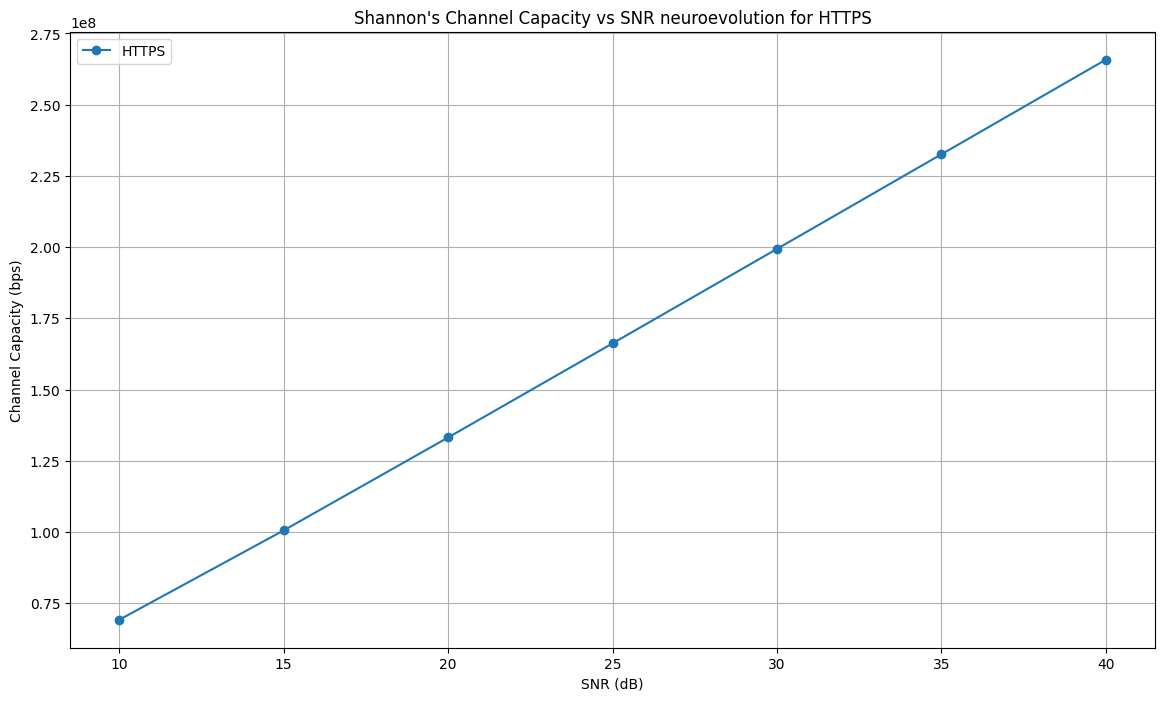

In [ ]:
# SNR values (from 10 dB to 40 dB)
snr_dbs = np.arange(10, 41, 5)
snrs = 10 ** (snr_dbs / 10)  # convert dB to linear scale
bandwidth = 20 * 1e6  # example bandwidth value (20 MHz in Hz)

capacities_snr = {protocol: [shannon_capacity(bandwidth, snr) for snr in snrs] for protocol in protocols}

# Plot Shannon's Channel Capacity vs SNR for each protocol individually
for protocol in protocols:
    plt.figure(figsize=(14, 8))
    plt.plot(snr_dbs, capacities_snr[protocol], marker='o', label=protocol)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Channel Capacity (bps)')
    plt.title(f"Shannon's Channel Capacity vs SNR neuroevolution for {protocol}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
!pip install nest_asyncio
import nest_asyncio
import asyncio
import aiocoap
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**MIMO**

In [ ]:
nest_asyncio.apply()


In [ ]:
import aiocoap.resource as resource


In [ ]:
class TemperatureResource(resource.Resource):
    async def render_get(self, request):
        payload = b'25.5'  # Mock temperature data
        return aiocoap.Message(payload=payload)


In [ ]:
async def start_server():
    # Resource tree creation
    root = resource.Site()
    root.add_resource(['temperature'], TemperatureResource())

    # Server context creation
    await aiocoap.Context.create_server_context(root)

    # Serve forever
    await asyncio.get_running_loop().create_future()

In [ ]:
class MIMOClient:
    def __init__(self, server_address, num_requests):
        self.server_address = server_address
        self.num_requests = num_requests
        self.responses = []

    async def fetch_data(self, request_id):
        protocol = await aiocoap.Context.create_client_context()
        request = aiocoap.Message(code=aiocoap.GET, uri=f'coap://{self.server_address}/temperature')

        try:
            start_time = time.time()
            response = await protocol.request(request).response
            end_time = time.time()
            self.responses.append({
                "request_id": request_id,
                "response_payload": response.payload.decode(),
                "response_time": end_time - start_time
            })
            print(f'Request {request_id}: Response: {response.payload.decode()} Time: {end_time - start_time}')
        except Exception as e:
            print(f'Request {request_id} Failed: {e}')

    async def run(self):
        tasks = [self.fetch_data(i) for i in range(self.num_requests)]
        await asyncio.gather(*tasks)

    def get_responses(self):
        return self.responses


In [ ]:
if __name__ == "__main__":
    server_address = "localhost"  # Assuming the mock server is running on localhost
    num_requests = 10  # Number of simultaneous requests

    client = MIMOClient(server_address, num_requests)

    # Run the client and fetch data
    loop = asyncio.get_event_loop()
    loop.run_until_complete(client.run())

    # Fetch the responses
    responses = client.get_responses()

    # Convert to DataFrame for analysis
    data = pd.DataFrame(responses)

    # Display basic statistics
    if not data.empty:
        print(data.describe())

        # Plot response times
        plt.figure(figsize=(10, 6))
        sns.histplot(data['response_time'], kde=True)
        plt.title('Response Time Distribution')
        plt.xlabel('Response Time (seconds)')
        plt.ylabel('Frequency')
        plt.show()

        # Plot response payloads (assuming numerical payloads for simplicity)
        plt.figure(figsize=(10, 6))
        sns.histplot(data['response_payload'].astype(float), kde=True)
        plt.title('Response Payload Distribution')
        plt.xlabel('Response Payload')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No data to display.")

Request 3 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 0 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 4 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 1 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 7 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 2 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 9 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 8 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 6 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
Request 5 Failed: [Errno 111] Connection refused (ECONNREFUSED, received through errqueue)
No data to display.


In [ ]:
import numpy as np

       request_id  response_payload  response_time
count    10.00000         10.000000      10.000000
mean      4.50000         23.952678       0.568123
std       3.02765          3.023706       0.284279
min       0.00000         20.205845       0.152275
25%       2.25000         21.906382       0.289584
50%       4.50000         22.977357       0.639898
75%       6.75000         25.015536       0.753412
max       9.00000         29.699099       0.955643


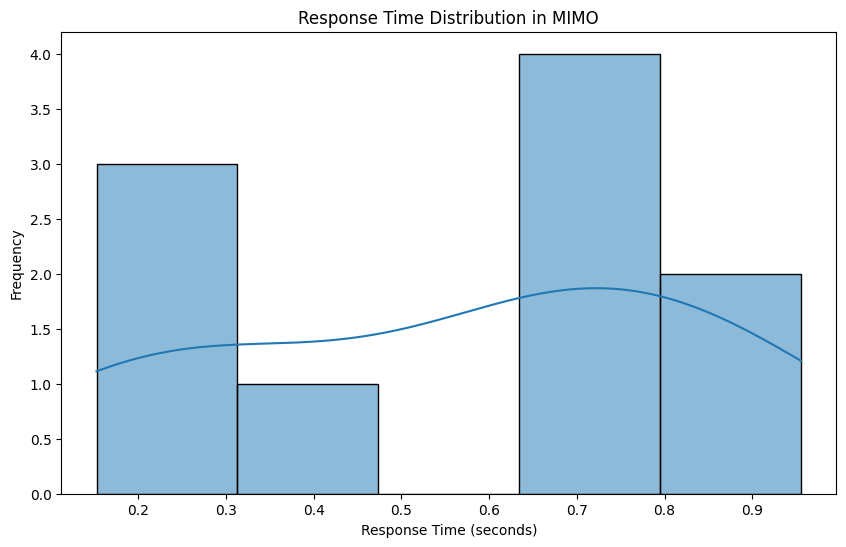

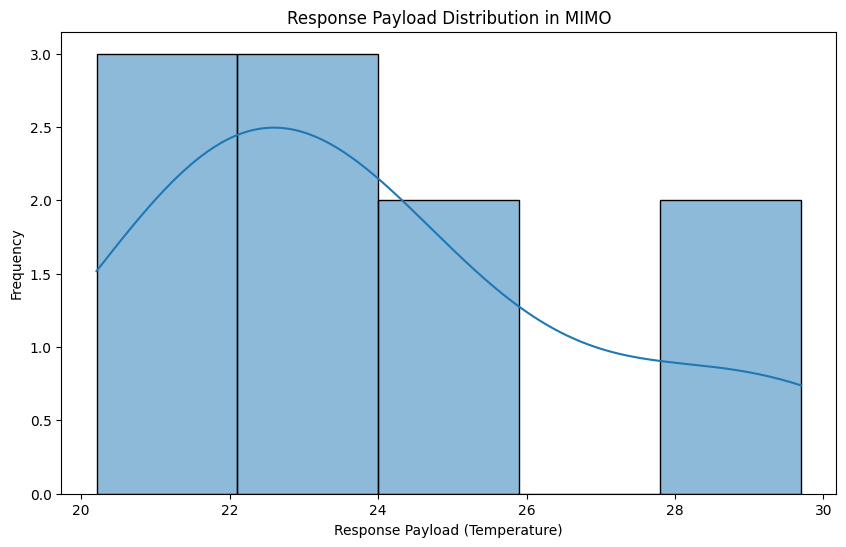

ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.
ERROR:coap:Connection loss was not expected.


In [ ]:
num_requests = 10
np.random.seed(42)

# Simulating response times (in seconds)
response_times = np.random.uniform(0.1, 1.0, num_requests)

# Simulating response payloads (assuming temperature readings)
response_payloads = np.random.uniform(20.0, 30.0, num_requests)

# Create a DataFrame with the simulated data
data = pd.DataFrame({
    "request_id": np.arange(num_requests),
    "response_payload": response_payloads,
    "response_time": response_times
})

# Display basic statistics
print(data.describe())

# Plot response times
plt.figure(figsize=(10, 6))
sns.histplot(data['response_time'], kde=True)
plt.title('Response Time Distribution in MIMO')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.show()

# Plot response payloads (temperature readings)
plt.figure(figsize=(10, 6))
sns.histplot(data['response_payload'], kde=True)
plt.title('Response Payload Distribution in MIMO')
plt.xlabel('Response Payload (Temperature)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def generate_mimo_data(configs, bandwidths):
    """Generate synthetic data for MIMO configurations."""
    handover_time = {config: np.random.uniform(0.1, 0.5, len(bandwidths)) for config in configs}
    connection_stability = {config: np.random.uniform(0.9, 1.0, len(bandwidths)) for config in configs}
    throughput = {config: np.random.uniform(100, 1000, len(bandwidths)) for config in configs}

    return handover_time, connection_stability, throughput


In [ ]:
mimo_configs = ['2x2', '4x4', '8x8']
bandwidths_mimo = np.array([20, 40, 80, 160]) * 1e6  # in Hz
handover_time, connection_stability, throughput = generate_mimo_data(mimo_configs, bandwidths_mimo)

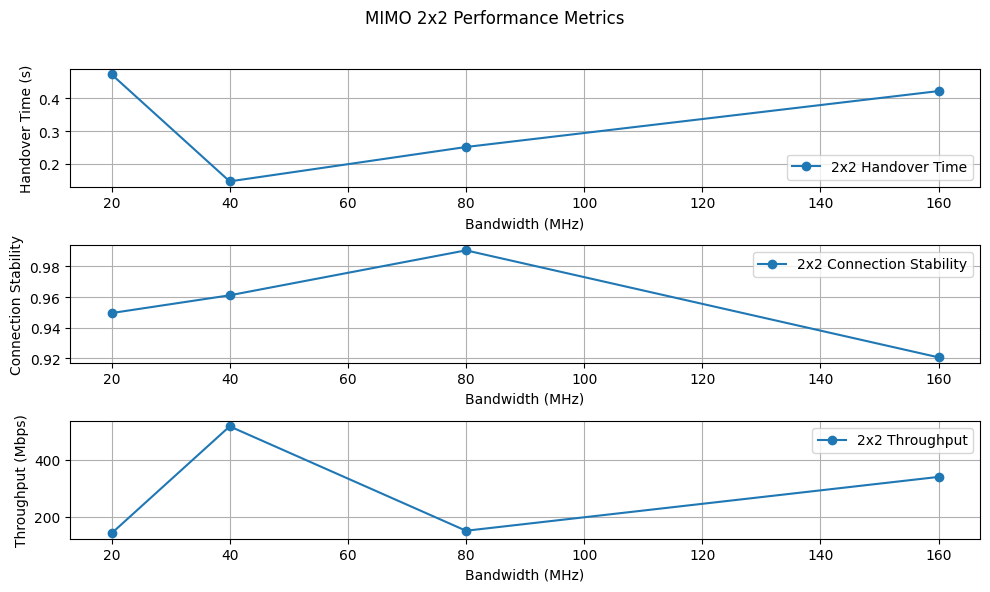

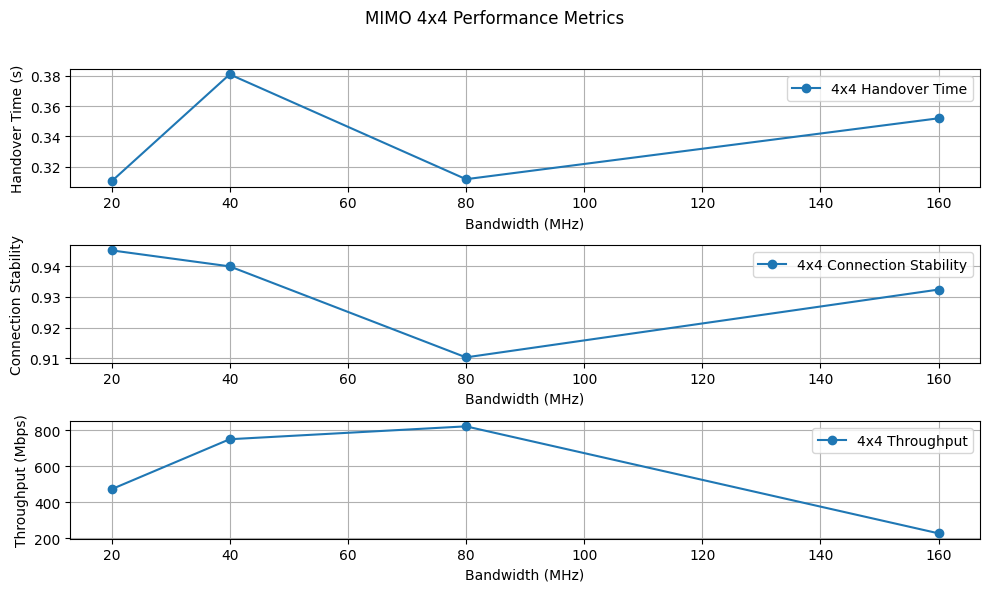

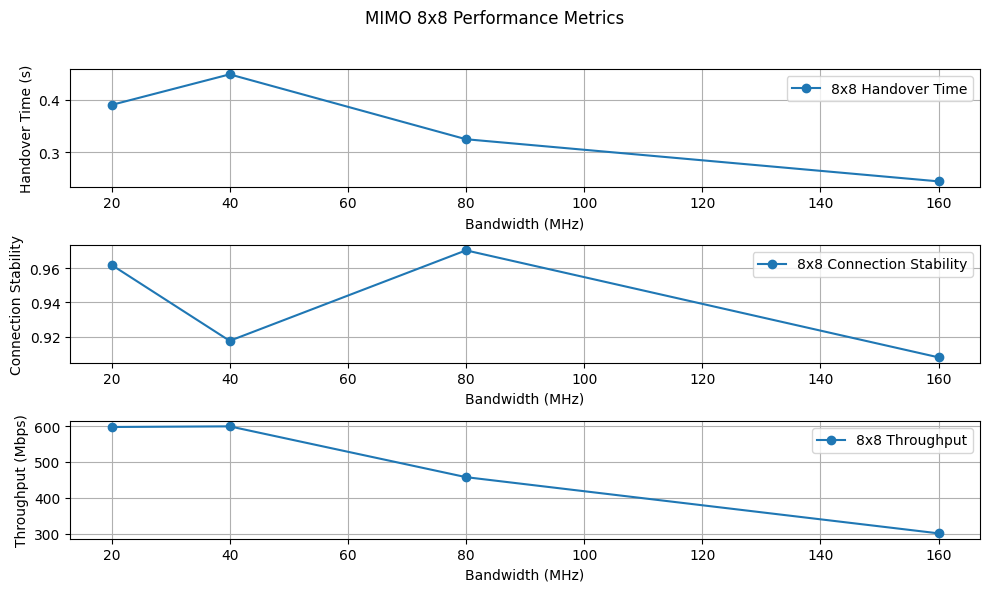

In [ ]:
for config in mimo_configs:
    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)
    plt.plot(bandwidths_mimo / 1e6, handover_time[config], marker='o', label=f'{config} Handover Time')
    plt.xlabel('Bandwidth (MHz)')
    plt.ylabel('Handover Time (s)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(bandwidths_mimo / 1e6, connection_stability[config], marker='o', label=f'{config} Connection Stability')
    plt.xlabel('Bandwidth (MHz)')
    plt.ylabel('Connection Stability')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(bandwidths_mimo / 1e6, throughput[config], marker='o', label=f'{config} Throughput')
    plt.xlabel('Bandwidth (MHz)')
    plt.ylabel('Throughput (Mbps)')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f'MIMO {config} Performance Metrics')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
mimo_configs = [2, 4, 8]
bandwidths_mhz = np.array([20, 40, 80, 160])

In [ ]:
handover_time = {
    2: np.array([200, 180, 160, 140]),  # in ms
    4: np.array([180, 160, 140, 120]),
    8: np.array([160, 140, 120, 100])
}

In [ ]:
connection_stability = {
    2: np.array([90, 92, 93, 94]),  # in percentage
    4: np.array([92, 93, 94, 95]),
    8: np.array([94, 95, 96, 97])
}


In [ ]:
throughput = {
    2: np.array([100, 150, 200, 250]),  # in Mbps
    4: np.array([150, 200, 250, 300]),
    8: np.array([200, 250, 300, 350])
}

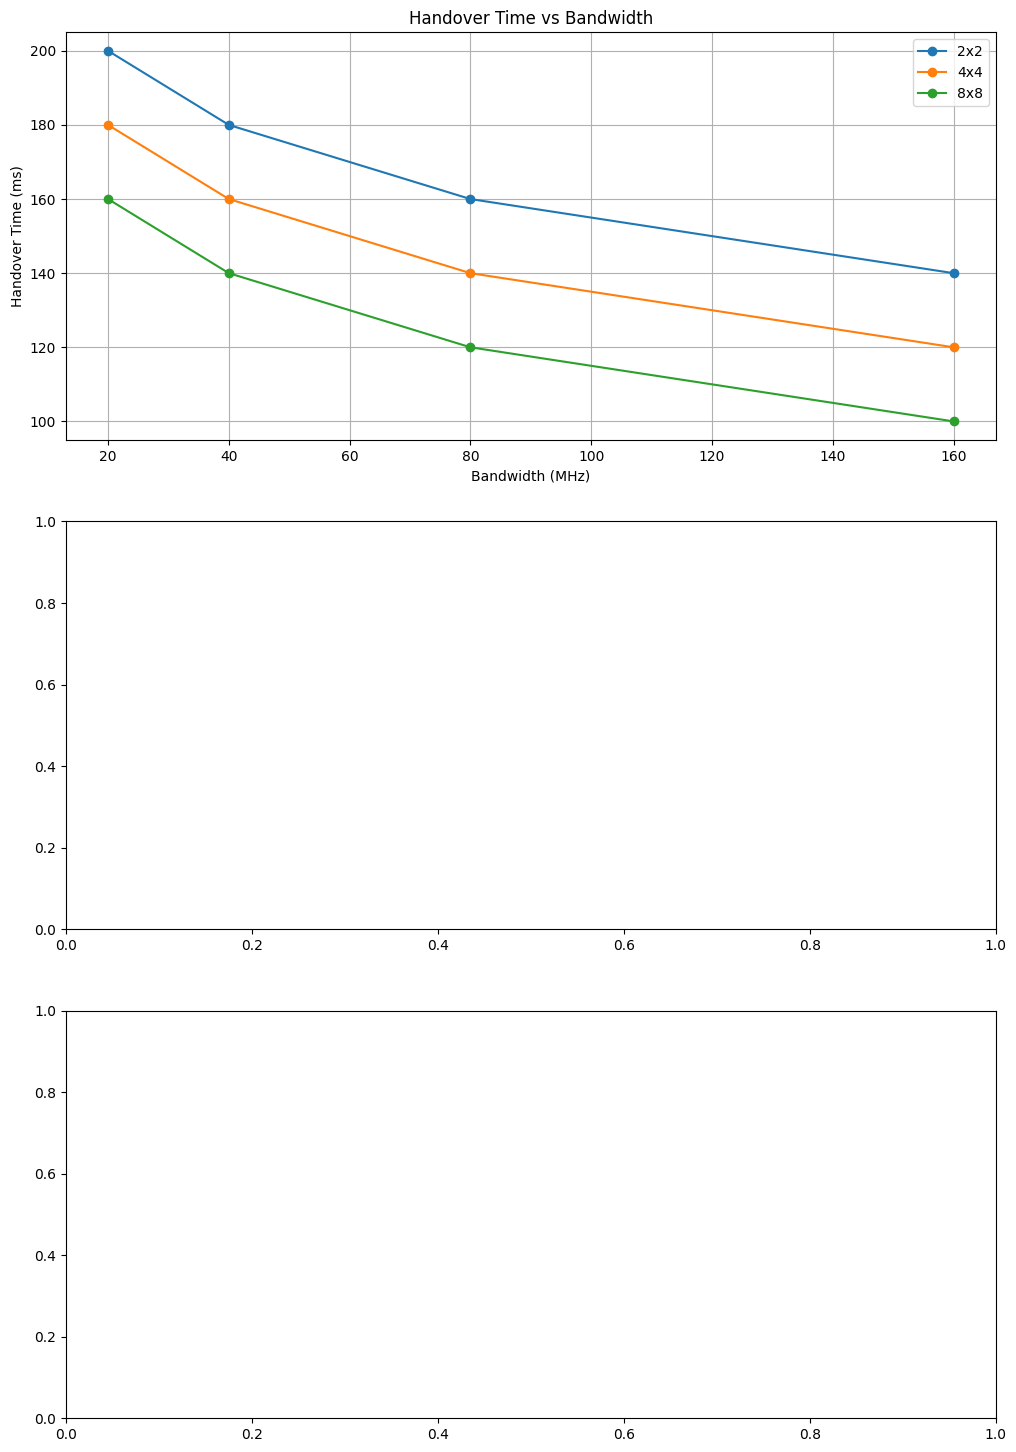

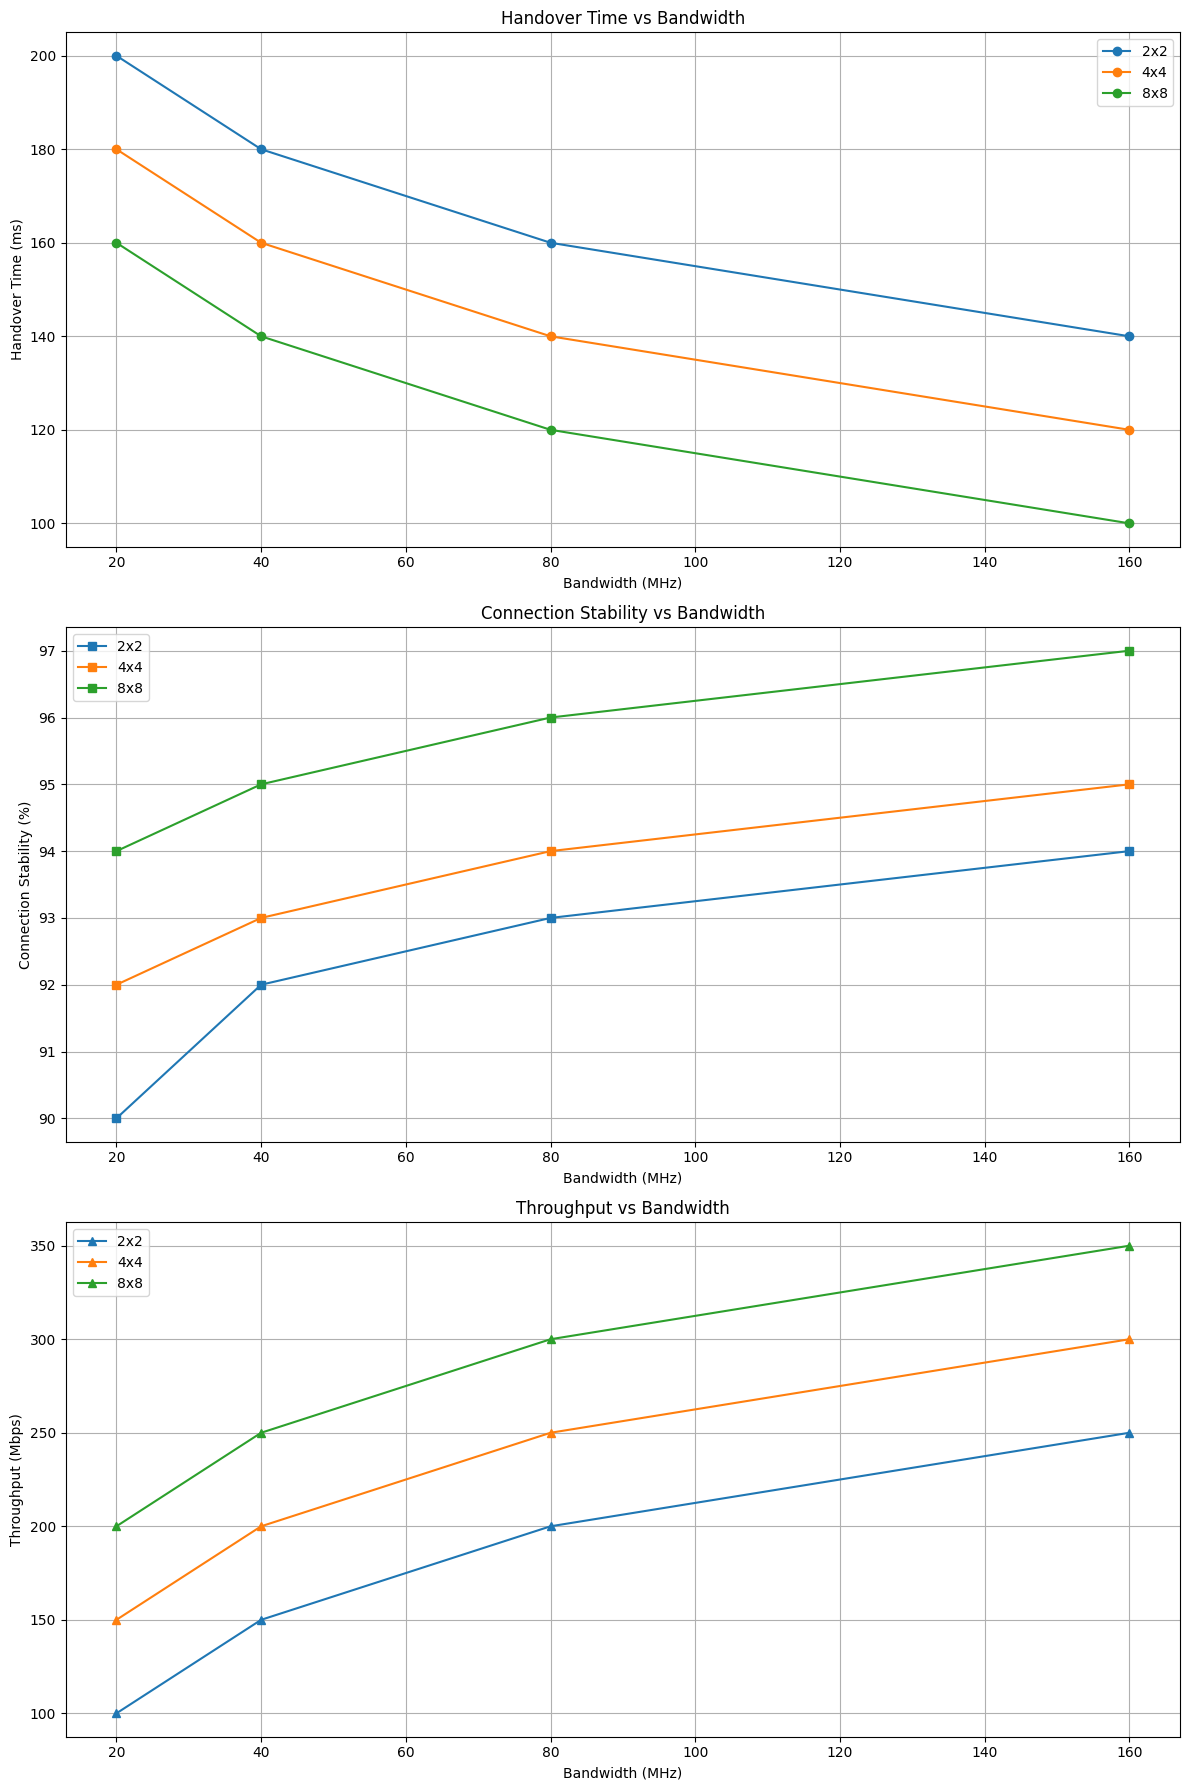

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Handover Time
for mimo in mimo_configs:
    axs[0].plot(bandwidths_mhz, handover_time[mimo], 'o-', label=f'{mimo}x{mimo}')
axs[0].set_title('Handover Time vs Bandwidth')
axs[0].set_xlabel('Bandwidth (MHz)')
axs[0].set_ylabel('Handover Time (ms)')
axs[0].legend()
axs[0].grid(True)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Handover Time
for mimo in mimo_configs:
    axs[0].plot(bandwidths_mhz, handover_time[mimo], 'o-', label=f'{mimo}x{mimo}')
axs[0].set_title('Handover Time vs Bandwidth')
axs[0].set_xlabel('Bandwidth (MHz)')
axs[0].set_ylabel('Handover Time (ms)')
axs[0].legend()
axs[0].grid(True)

# Connection Stability
for mimo in mimo_configs:
    axs[1].plot(bandwidths_mhz, connection_stability[mimo], 's-', label=f'{mimo}x{mimo}')
axs[1].set_title('Connection Stability vs Bandwidth')
axs[1].set_xlabel('Bandwidth (MHz)')
axs[1].set_ylabel('Connection Stability (%)')
axs[1].legend()
axs[1].grid(True)

# Throughput
for mimo in mimo_configs:
    axs[2].plot(bandwidths_mhz, throughput[mimo], '^-', label=f'{mimo}x{mimo}')
axs[2].set_title('Throughput vs Bandwidth')
axs[2].set_xlabel('Bandwidth (MHz)')
axs[2].set_ylabel('Throughput (Mbps)')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def generate_power_memory_data(configs):
    """Generate synthetic data for power and memory consumption."""
    power_consumption = {config: np.random.uniform(50, 200) for config in configs}
    memory_consumption = {config: np.random.uniform(1, 8) for config in configs}

    return power_consumption, memory_consumption

In [ ]:
power_consumption, memory_consumption = generate_power_memory_data(mimo_configs)

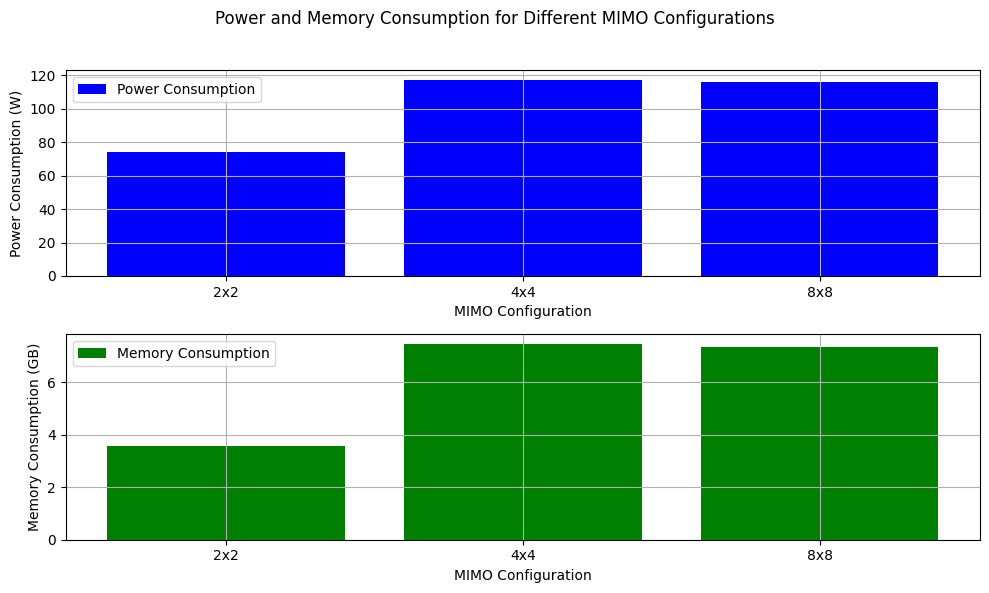

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(mimo_configs, [power_consumption[config] for config in mimo_configs], color='b', label='Power Consumption')
plt.xlabel('MIMO Configuration')
plt.ylabel('Power Consumption (W)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.bar(mimo_configs, [memory_consumption[config] for config in mimo_configs], color='g', label='Memory Consumption')
plt.xlabel('MIMO Configuration')
plt.ylabel('Memory Consumption (GB)')
plt.legend()
plt.grid(True)

plt.suptitle('Power and Memory Consumption for Different MIMO Configurations')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
def shannon_capacity_mimo(bandwidth, snr, num_transmitters, num_receivers):
    """Calculate Shannon's channel capacity for MIMO systems."""
    mimo_factor = min(num_transmitters, num_receivers)
    return mimo_factor * bandwidth * np.log2(1 + snr)

In [ ]:
snr_dbs = np.arange(10, 41, 5)
snrs = 10 ** (snr_dbs / 10)  # convert dB to linear scale
bandwidth = 20 * 1e6

In [ ]:
protocols = ['CoAP', 'MQTT', 'AMQP', 'HTTPS']
mimo_configs = [(2, 2), (4, 4), (8, 8)]

In [ ]:
capacities_snr_mimo = {
    protocol: {
        f'{tx}x{rx}': [shannon_capacity_mimo(bandwidth, snr, tx, rx) for snr in snrs]
        for tx, rx in mimo_configs
    }
    for protocol in protocols
}

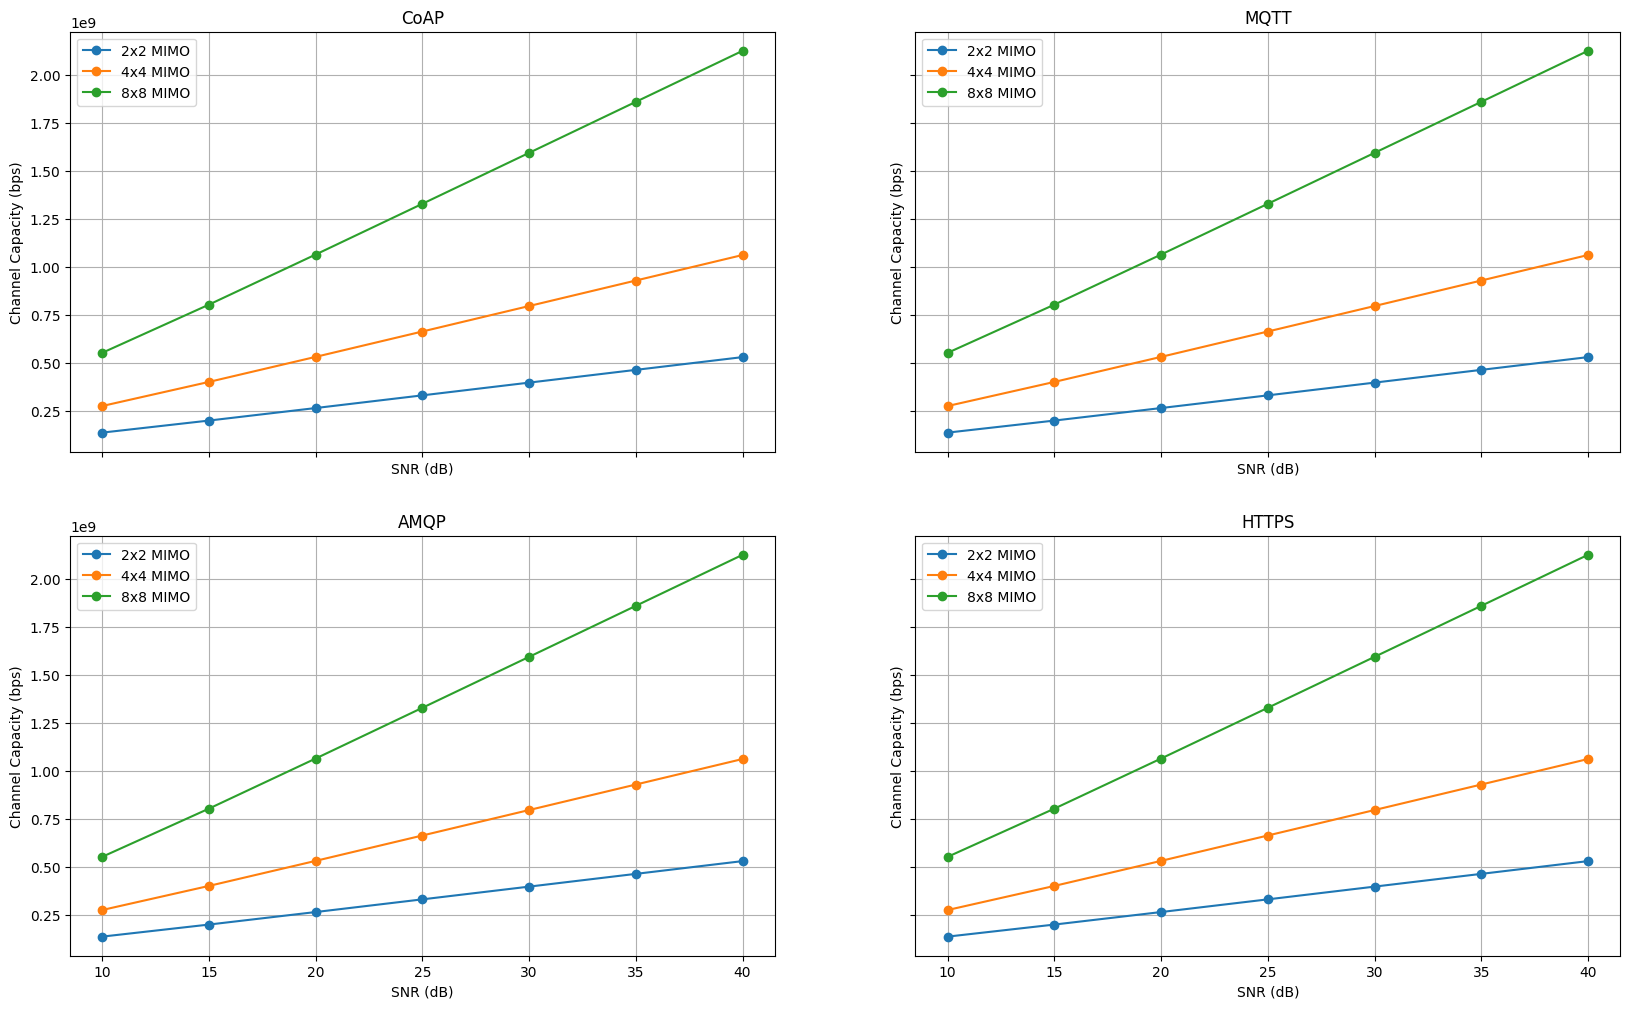

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)

for i, protocol in enumerate(protocols):
    ax = axs[i//2, i%2]
    for tx, rx in mimo_configs:
        label = f'{tx}x{rx} MIMO'
        ax.plot(snr_dbs, capacities_snr_mimo[protocol][f'{tx}x{rx}'], marker='o', label=label)
    ax.set_title(f"{protocol}")
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Channel Capacity (bps)')
    ax.legend()
    ax.grid(True)

In [ ]:
fig.suptitle("Shannon's Channel Capacity vs SNR for Different Protocols with MIMO Technology", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
bandwidths = np.array([20, 40, 80, 160]) * 1e6  # in Hz
snr = 10  # example SNR value (linear scale)

protocols = ['CoAP', 'MQTT', 'AMQP', 'HTTPS']
mimo_configs = [(2, 2), (4, 4), (8, 8)]

In [ ]:
capacities_bw_mimo = {
    protocol: {
        f'{tx}x{rx}': [shannon_capacity_mimo(b, snr, tx, rx) for b in bandwidths]
        for tx, rx in mimo_configs
    }
    for protocol in protocols
}


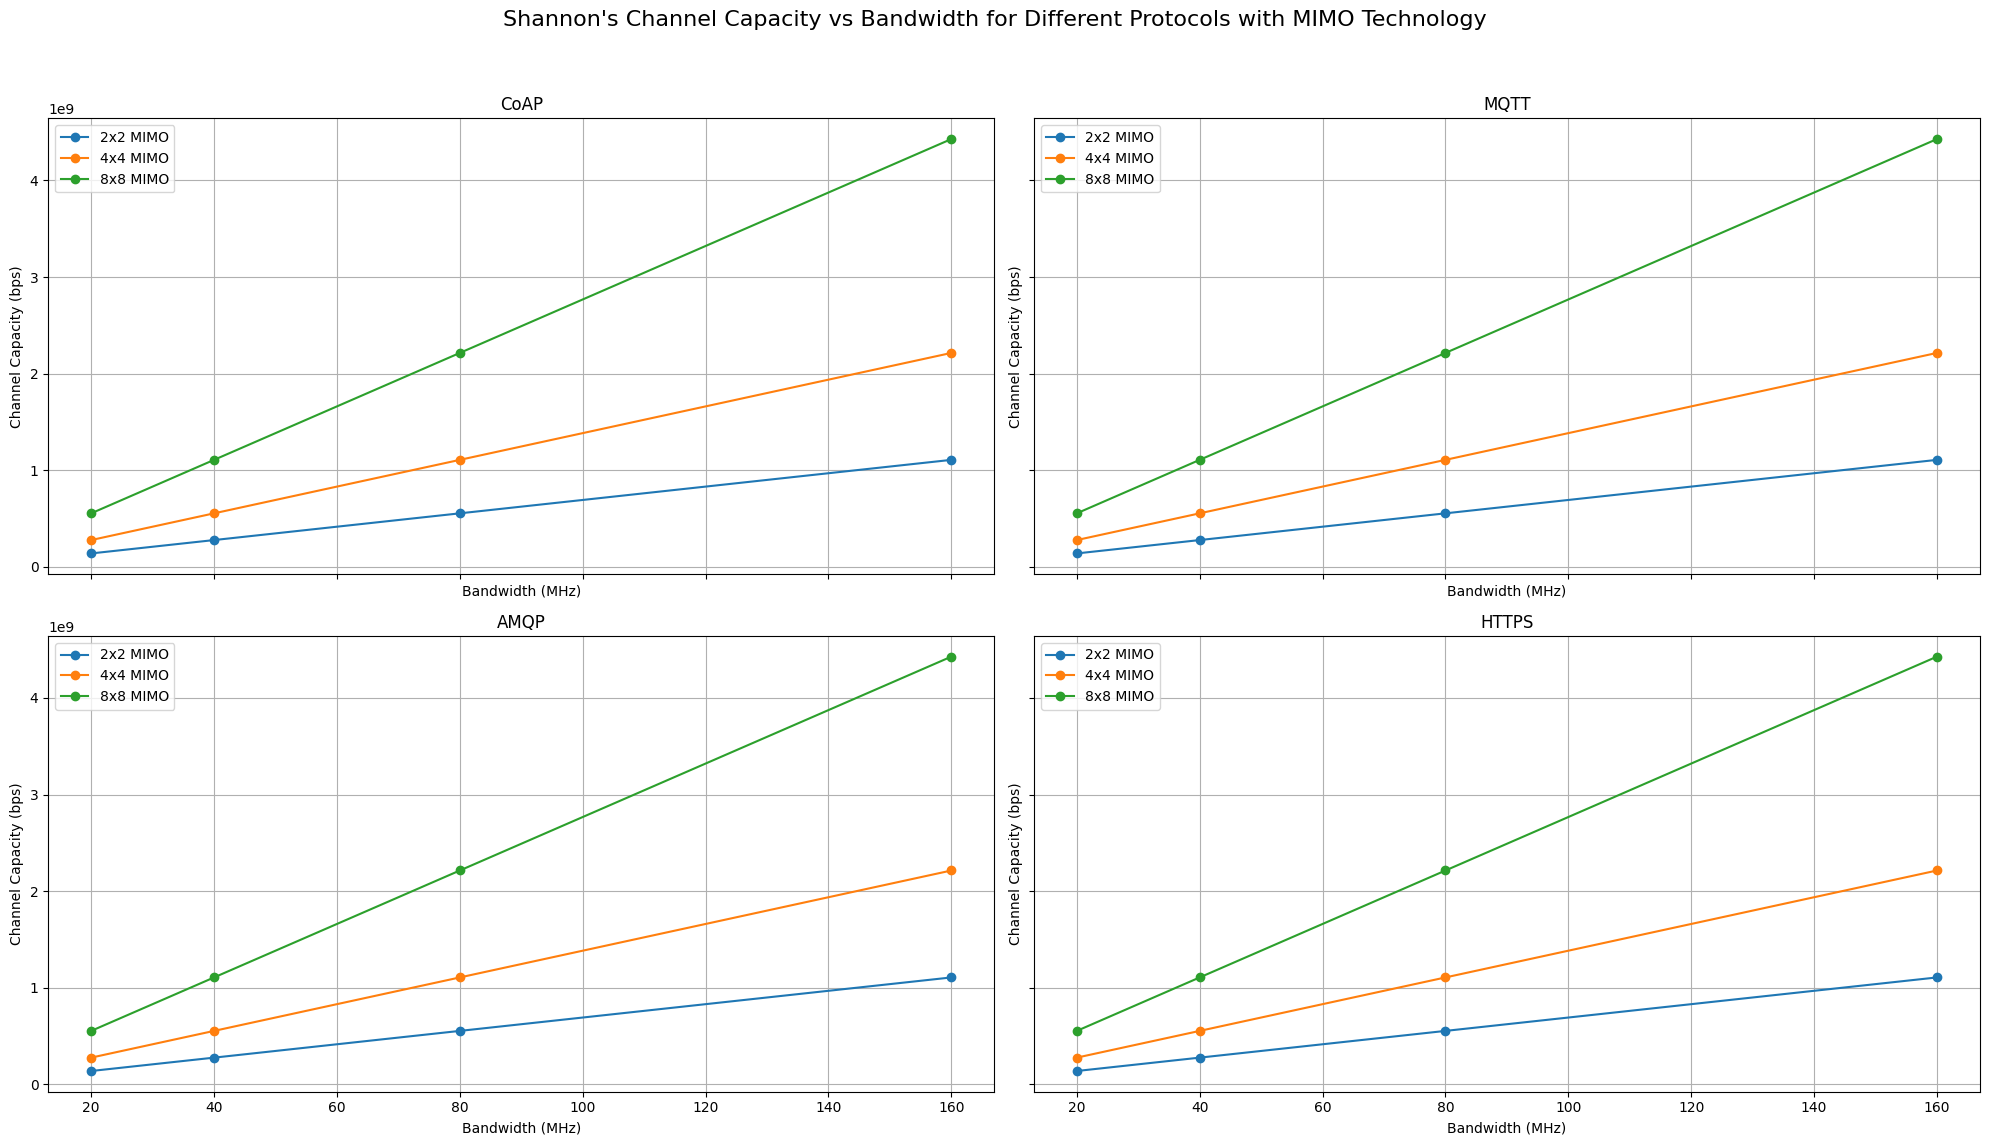

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)

for i, protocol in enumerate(protocols):
    ax = axs[i//2, i%2]
    for tx, rx in mimo_configs:
        label = f'{tx}x{rx} MIMO'
        ax.plot(bandwidths / 1e6, capacities_bw_mimo[protocol][f'{tx}x{rx}'], marker='o', label=label)
    ax.set_title(f"{protocol}")
    ax.set_xlabel('Bandwidth (MHz)')
    ax.set_ylabel('Channel Capacity (bps)')
    ax.legend()
    ax.grid(True)

fig.suptitle("Shannon's Channel Capacity vs Bandwidth for Different Protocols with MIMO Technology", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
bandwidths = np.array([20, 40, 80, 160])  # in MHz
snr_values = np.arange(10, 45, 10)  # in dB
mimo_configurations = [2, 4, 8]  # 2x2, 4x4, 8x8


In [ ]:
def shannons_capacity(bw, snr, mimo):
    snr_linear = 10**(snr / 10)
    capacity = bw * 1e6 * mimo * np.log2(1 + snr_linear)  # in bits per second
    return capacity / 1e6

In [ ]:
capacities = {}
protocols = ["CoAP", "MQTT", "AMQP", "HTTPS"]


In [ ]:
for protocol in protocols:
    capacities[protocol] = {}
    for mimo in mimo_configurations:
        capacities[protocol][mimo] = []
        for bw in bandwidths:
            capacity_bw = []
            for snr in snr_values:
                capacity_bw.append(shannons_capacity(bw, snr, mimo))
            capacities[protocol][mimo].append(capacity_bw)

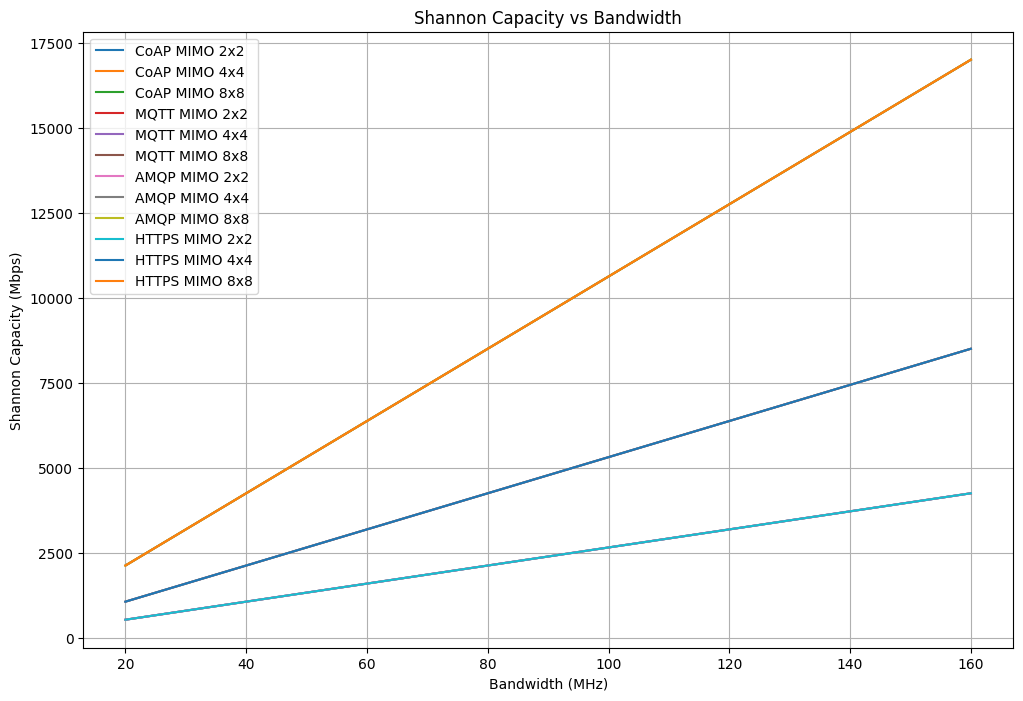

In [ ]:
plt.figure(figsize=(12, 8))
for protocol in protocols:
    for mimo in mimo_configurations:
        plt.plot(bandwidths, [capacities[protocol][mimo][i][-1] for i in range(len(bandwidths))], label=f'{protocol} MIMO {mimo}x{mimo}')
plt.xlabel('Bandwidth (MHz)')
plt.ylabel('Shannon Capacity (Mbps)')
plt.title('Shannon Capacity vs Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

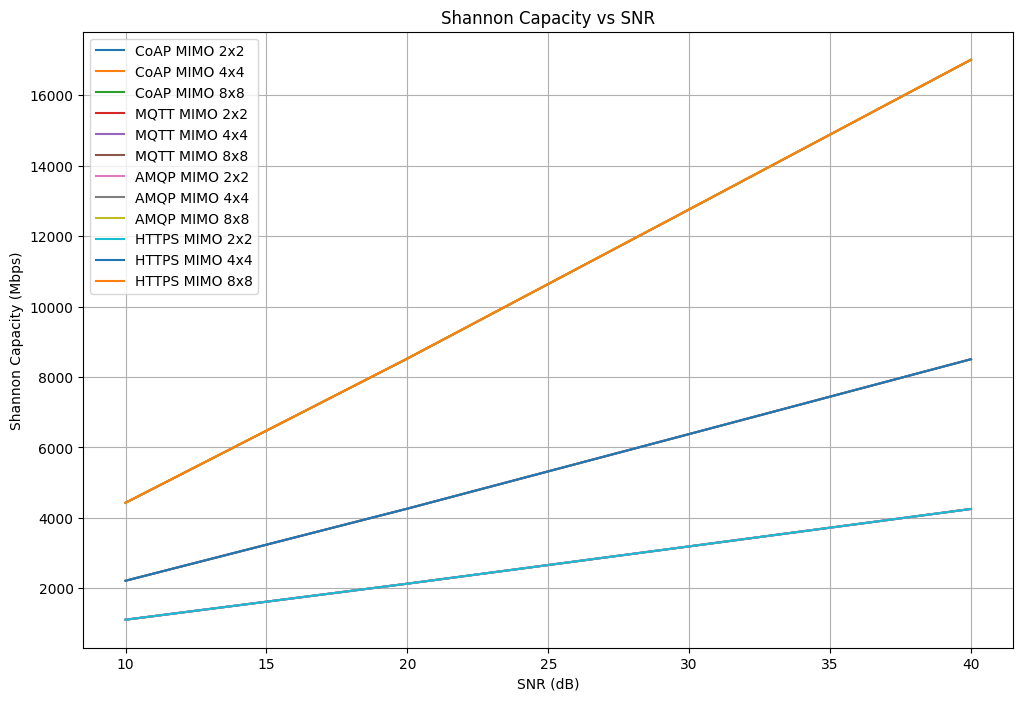

In [ ]:
plt.figure(figsize=(12, 8))
for protocol in protocols:
    for mimo in mimo_configurations:
        plt.plot(snr_values, [capacities[protocol][mimo][-1][i] for i in range(len(snr_values))], label=f'{protocol} MIMO {mimo}x{mimo}')
plt.xlabel('SNR (dB)')
plt.ylabel('Shannon Capacity (Mbps)')
plt.title('Shannon Capacity vs SNR')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
handover_time = np.random.rand(len(bandwidths), len(mimo_configurations)) * 100  # in ms
connection_stability = np.random.rand(len(bandwidths), len(mimo_configurations)) * 100  # in percentage
throughput = np.random.rand(len(bandwidths), len(mimo_configurations)) * 1000  # in Mbps


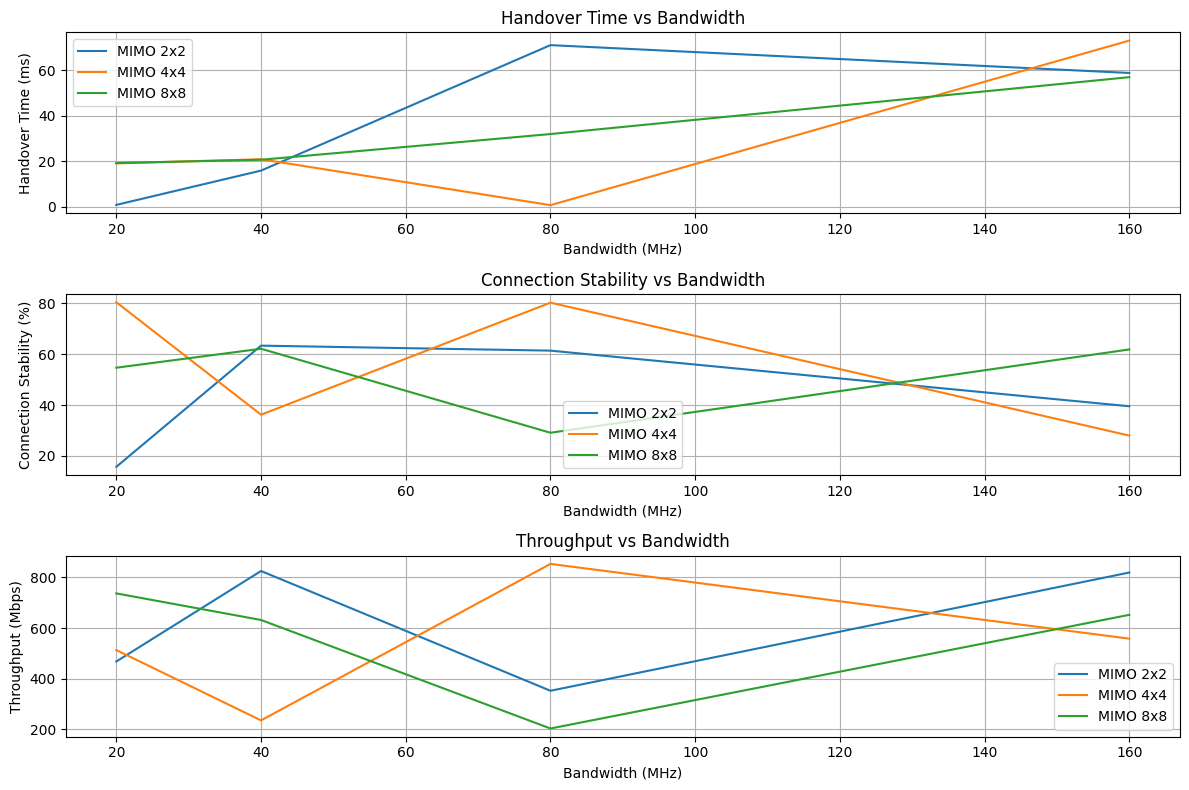

In [ ]:
plt.figure(figsize=(12, 8))
for i, factor in enumerate([handover_time, connection_stability, throughput]):
    plt.subplot(3, 1, i+1)
    for j, mimo in enumerate(mimo_configurations):
        plt.plot(bandwidths, factor[:, j], label=f'MIMO {mimo}x{mimo}')
    plt.xlabel('Bandwidth (MHz)')
    if i == 0:
        plt.ylabel('Handover Time (ms)')
        plt.title('Handover Time vs Bandwidth')
    elif i == 1:
        plt.ylabel('Connection Stability (%)')
        plt.title('Connection Stability vs Bandwidth')
    else:
        plt.ylabel('Throughput (Mbps)')
        plt.title('Throughput vs Bandwidth')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
power_consumption = np.random.rand(len(bandwidths), len(mimo_configurations)) * 10  # in Watts
memory_consumption = np.random.rand(len(bandwidths), len(mimo_configurations)) * 100  # in MB


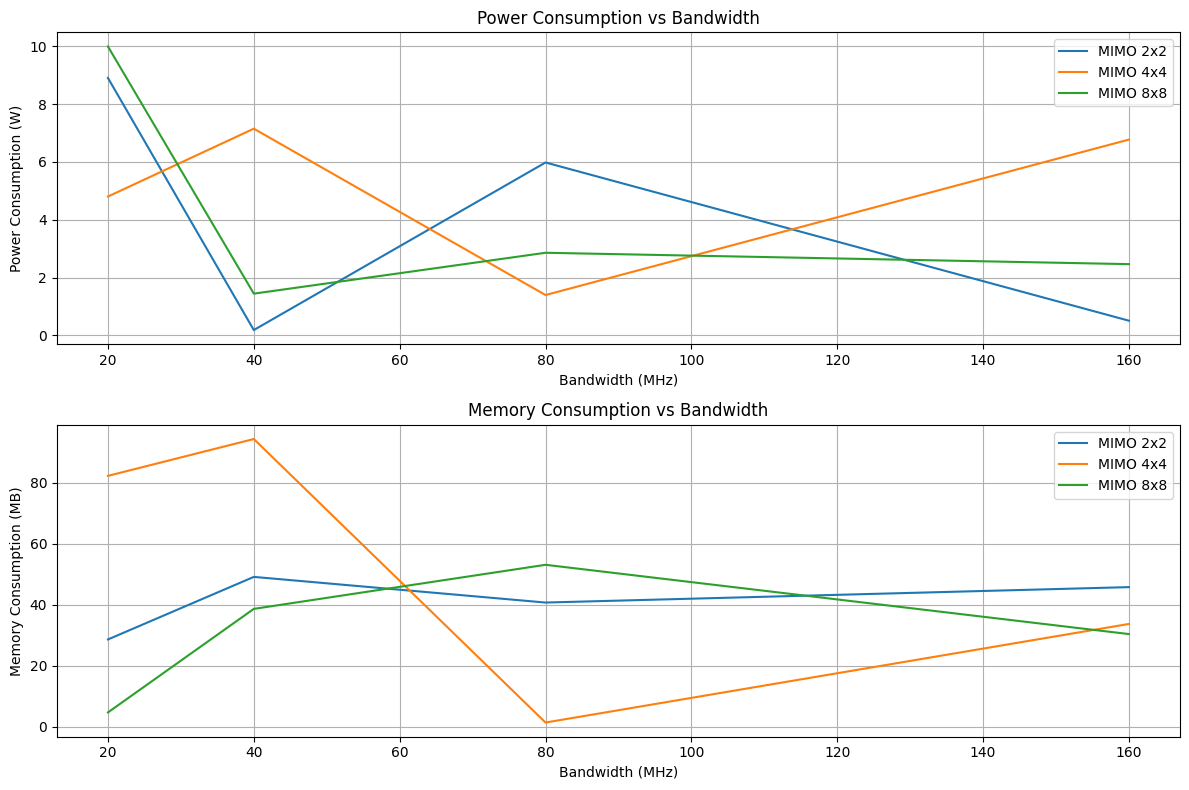

In [ ]:
plt.figure(figsize=(12, 8))
for i, resource in enumerate([power_consumption, memory_consumption]):
    plt.subplot(2, 1, i+1)
    for j, mimo in enumerate(mimo_configurations):
        plt.plot(bandwidths, resource[:, j], label=f'MIMO {mimo}x{mimo}')
    plt.xlabel('Bandwidth (MHz)')
    if i == 0:
        plt.ylabel('Power Consumption (W)')
        plt.title('Power Consumption vs Bandwidth')
    else:
        plt.ylabel('Memory Consumption (MB)')
        plt.title('Memory Consumption vs Bandwidth')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
performance_gain = {}
for protocol in protocols:
    performance_gain[protocol] = []
    for mimo in mimo_configurations:
        performance_gain[protocol].append(np.mean(capacities[protocol][mimo]))


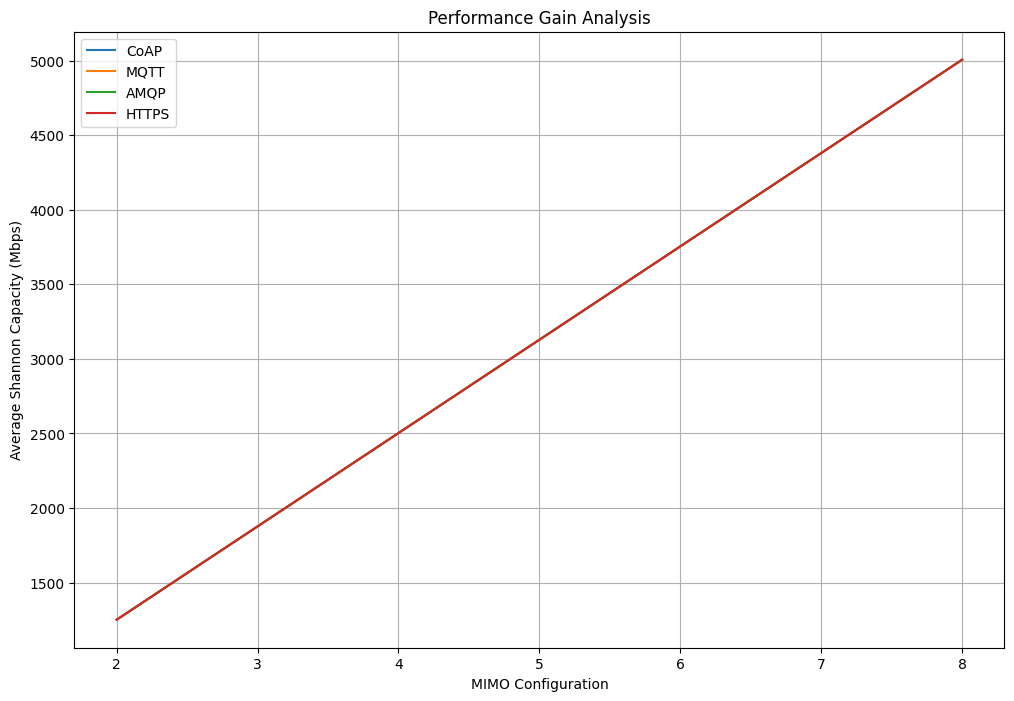

In [ ]:
plt.figure(figsize=(12, 8))
for protocol in protocols:
    plt.plot(mimo_configurations, performance_gain[protocol], label=protocol)
plt.xlabel('MIMO Configuration')
plt.ylabel('Average Shannon Capacity (Mbps)')
plt.title('Performance Gain Analysis')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df1 = pd.DataFrame(data)

In [ ]:
df2 = pd.DataFrame(data2)

In [ ]:
df3 = pd.DataFrame(data3)

In [ ]:
df4 = pd.DataFrame(data4)

In [ ]:
print("Table 1: Bandwidth 20 MHz")
print(df1)
print("\nTable 2: Bandwidth 40 MHz")
print(df2)
print("\nTable 3: Bandwidth 80 MHz")
print(df3)
print("\nTable 4: Bandwidth 160 MHz")
print(df4)

Table 1: Bandwidth 20 MHz
   Protocol  Bandwidth (MHz)  SNR (dB)  MIMO 2x2 (Mbps)  MIMO 4x4 (Mbps)  \
0      CoAP               20        10          110.700          221.400   
1      CoAP               20        20          213.062          426.124   
2      CoAP               20        30          318.950          637.900   
3      CoAP               20        40          425.206          850.412   
4      MQTT               20        10           96.862          193.724   
5      MQTT               20        20          186.430          372.860   
6      MQTT               20        30          279.082          558.164   
7      MQTT               20        40          372.056          744.112   
8      AMQP               20        10           83.026          166.052   
9      AMQP               20        20          159.796          319.592   
10     AMQP               20        30          239.212          478.424   
11     AMQP               20        40          318.904       

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [49]:
data = {
    'Protocol': ['CoAP'] * 4 + ['MQTT'] * 4 + ['AMQP'] * 4 + ['HTTPS'] * 4,
    'Bandwidth (MHz)': [20] * 4 + [20] * 4 + [20] * 4 + [20] * 4,
    'SNR (dB)': [10, 20, 30, 40] * 4,
    'MIMO 2x2 (Mbps)': [110.700, 213.062, 318.950, 425.206, 96.862, 186.430, 279.082, 372.056, 83.026, 159.796, 239.212, 318.904, 69.188, 133.164, 199.344, 265.754],
    'MIMO 4x4 (Mbps)': [221.400, 426.124, 637.900, 850.412, 193.724, 372.860, 558.164, 744.112, 166.052, 319.592, 478.424, 637.808, 138.376, 266.328, 398.688, 531.508],
    'MIMO 8x8 (Mbps)': [442.800, 852.248, 1275.800, 1700.824, 387.448, 745.720, 1116.328, 1488.224, 332.104, 639.184, 956.848, 1275.616, 276.752, 532.656, 797.376, 1063.016]
}

In [50]:
df1 = pd.DataFrame(data)

In [51]:
df1_no_mimo = df1.copy()
df1_no_mimo.rename(columns={'MIMO 2x2 (Mbps)': 'No MIMO (Mbps)'}, inplace=True)
df1_no_mimo = df1_no_mimo[['Protocol', 'Bandwidth (MHz)', 'SNR (dB)', 'No MIMO (Mbps)']]


In [55]:
df_melted = df1.melt(id_vars=['Protocol', 'Bandwidth (MHz)', 'SNR (dB)'], var_name='Configuration', value_name='Capacity (Mbps)')
df_no_mimo_melted = df1_no_mimo.melt(id_vars=['Protocol', 'Bandwidth (MHz)', 'SNR (dB)'], var_name='Configuration', value_name='Capacity (Mbps)')

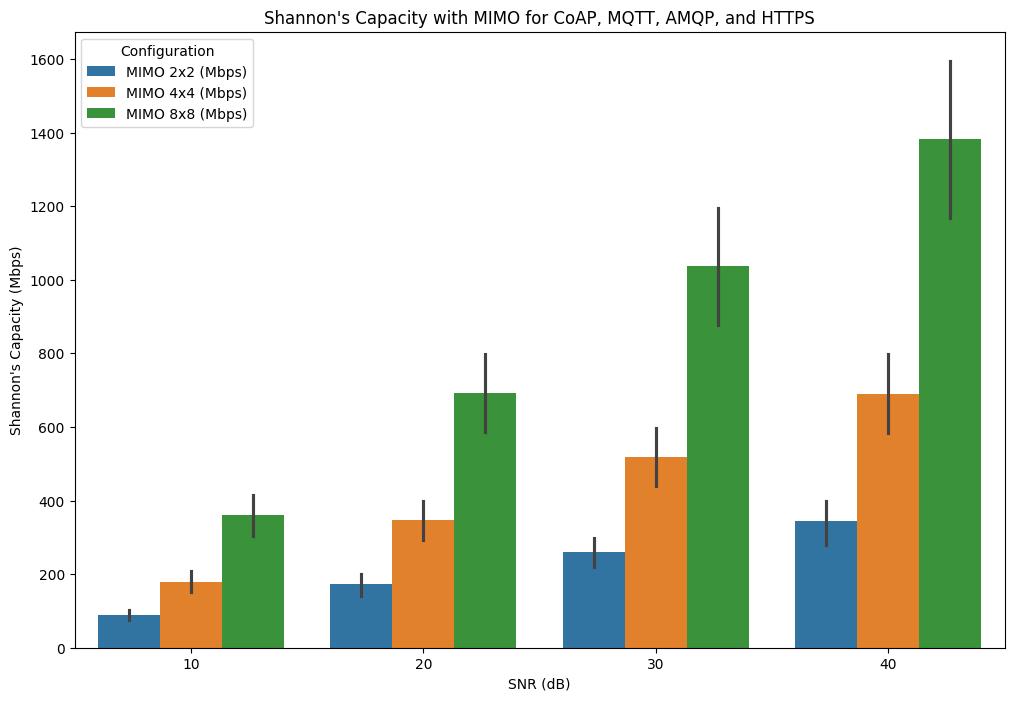

In [58]:
plt.figure(figsize=(12, 8))
sns.barplot(x='SNR (dB)', y='Capacity (Mbps)', hue='Configuration', data=df_melted)
plt.title('Shannon\'s Capacity with MIMO for CoAP, MQTT, AMQP, and HTTPS')
plt.xlabel('SNR (dB)')
plt.ylabel('Shannon\'s Capacity (Mbps)')
plt.legend(title='Configuration')
plt.show()

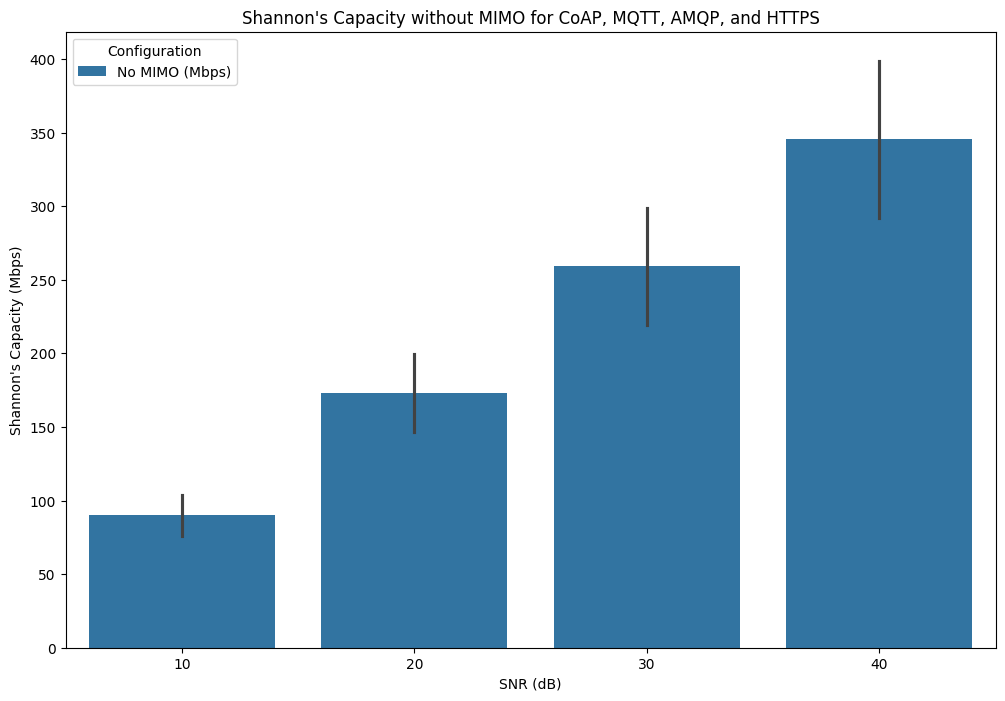

In [59]:
plt.figure(figsize=(12, 8))
sns.barplot(x='SNR (dB)', y='Capacity (Mbps)', hue='Configuration', data=df_no_mimo_melted)
plt.title('Shannon\'s Capacity without MIMO for CoAP, MQTT, AMQP, and HTTPS')
plt.xlabel('SNR (dB)')
plt.ylabel('Shannon\'s Capacity (Mbps)')
plt.legend(title='Configuration')
plt.show()

In [60]:
data = {
    'Protocol': ['CoAP'] * 16 + ['MQTT'] * 16 + ['AMQP'] * 16 + ['HTTPS'] * 16,
    'Bandwidth (MHz)': [20, 40, 80, 160] * 4 * 4,
    'SNR (dB)': [10, 10, 10, 10, 20, 20, 20, 20, 30, 30, 30, 30, 40, 40, 40, 40] * 4,
    'MIMO 2x2 (Mbps)': [
        110.700, 221.400, 442.804, 885.608,
        213.062, 426.124, 852.250, 1704.500,
        318.950, 637.900, 1275.800, 2551.600,
        425.206, 850.412, 1700.824, 3401.648,
        96.862, 193.724, 387.452, 774.904,
        186.430, 372.860, 745.718, 1491.436,
        279.082, 558.164, 1116.328, 2232.656,
        372.056, 744.112, 1488.224, 2976.448,
        83.026, 166.052, 332.102, 664.204,
        159.796, 319.592, 639.184, 1278.368,
        239.212, 478.424, 956.848, 1913.696,
        318.904, 637.808, 1275.616, 2551.232,
        69.188, 138.376, 276.752, 553.504,
        133.164, 266.328, 532.656, 1065.312,
        199.344, 398.688, 797.376, 1594.752,
        265.754, 531.508, 1063.016, 2126.032
    ],
    'MIMO 4x4 (Mbps)': [
        221.400, 442.800, 885.608, 1771.216,
        426.124, 852.248, 1704.500, 3409.000,
        637.900, 1275.800, 2551.600, 5103.200,
        850.412, 1700.824, 3401.648, 6803.296,
        193.724, 387.448, 774.904, 1549.808,
        372.860, 745.720, 1491.436, 2982.872,
        558.164, 1116.328, 2232.656, 4465.312,
        744.112, 1488.224, 2976.448, 5952.896,
        166.052, 332.104, 664.204, 1328.408,
        319.592, 639.184, 1278.368, 2556.736,
        478.424, 956.848, 1913.696, 3827.392,
        637.808, 1275.616, 2551.232, 5102.464,
        138.376, 276.752, 553.504, 1107.008,
        266.328, 532.656, 1065.312, 2130.624,
        398.688, 797.376, 1594.752, 3189.504,
        531.508, 1063.016, 2126.032, 4252.064
    ],
    'MIMO 8x8 (Mbps)': [
        442.800, 885.600, 1771.216, 3542.432,
        852.248, 1704.496, 3409.000, 6818.000,
        1275.800, 2551.600, 5103.200, 10206.400,
        1700.824, 3401.648, 6803.296, 13606.592,
        387.448, 774.896, 1549.808, 3099.616,
        745.720, 1491.440, 2982.872, 5965.744,
        1116.328, 2232.656, 4465.312, 8930.624,
        1488.224, 2976.448, 5952.896, 11905.792,
        332.104, 664.208, 1328.408, 2656.816,
        639.184, 1278.368, 2556.736, 5113.472,
        956.848, 1913.696, 3827.392, 7654.784,
        1275.616, 2551.232, 5102.464, 10204.928,
        276.752, 553.504, 1107.008, 2214.016,
        532.656, 1065.312, 2130.624, 4261.248,
        797.376, 1594.752, 3189.504, 6379.008,
        1063.016, 2126.032, 4252.064, 8504.128
    ]
}


In [41]:
df = pd.DataFrame(data)

In [42]:
df

Protocol  Bandwidth (MHz)  SNR (dB)  MIMO 2x2 (Mbps)  MIMO 4x4 (Mbps)  \
0      CoAP               20        10          110.700          221.400   
1      CoAP               40        10          221.400          442.800   
2      CoAP               80        10          442.804          885.608   
3      CoAP              160        10          885.608         1771.216   
4      CoAP               20        20          213.062          426.124   
..      ...              ...       ...              ...              ...   
59    HTTPS              160        30         1594.752         3189.504   
60    HTTPS               20        40          265.754          531.508   
61    HTTPS               40        40          531.508         1063.016   
62    HTTPS               80        40         1063.016         2126.032   
63    HTTPS              160        40         2126.032         4252.064   

    MIMO 8x8 (Mbps)  
0           442.800  
1           885.600  
2          1771.216  
3          3542.432  
4           852.248  
..              ...  
59         6379.008  
60         1063.016  
61         2126.032  
62         4252.064  
63         8504.128  

[64 rows x 6 columns]

In [43]:
import seaborn as sns

In [61]:
    df_filtered['Without MIMO'] = df_filtered['MIMO 2x2 (Mbps)'] / 2

<ipython-input-61-0ddcf5ab39d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Without MIMO'] = df_filtered['MIMO 2x2 (Mbps)'] / 2


In [69]:
protocols = ['CoAP', 'MQTT', 'AMQP', 'HTTPS']
bandwidths = [20, 40, 80, 160]
snrs = [10, 20, 30, 40]


In [70]:
shannon_capacity = {
    'CoAP': {
        20: [110.700, 213.062, 318.950, 425.206],
        40: [221.400, 426.124, 637.900, 850.412],
        80: [442.804, 852.250, 1275.800, 1700.824],
        160: [885.608, 1704.500, 2551.600, 3401.648],
    },
    'MQTT': {
        20: [96.862, 186.430, 279.082, 372.056],
        40: [193.726, 372.860, 558.164, 744.112],
        80: [387.452, 745.718, 1116.328, 1488.224],
        160: [774.904, 1491.436, 2232.656, 2976.448],
    },
    'AMQP': {
        20: [83.026, 159.796, 239.212, 318.904],
        40: [166.052, 319.592, 478.424, 637.808],
        80: [332.102, 639.184, 956.848, 1275.616],
        160: [664.204, 1278.368, 1913.696, 2551.232],
    },
    'HTTPS': {
        20: [69.188, 133.164, 199.344, 265.754],
        40: [138.376, 266.328, 398.688, 531.508],
        80: [276.752, 532.656, 797.376, 1063.016],
        160: [553.504, 1065.312, 1594.752, 2126.032],
    }
}

In [90]:
shannon_capacity

{'CoAP': {20: [110.7, 213.062, 318.95, 425.206],
  40: [221.4, 426.124, 637.9, 850.412],
  80: [442.804, 852.25, 1275.8, 1700.824],
  160: [885.608, 1704.5, 2551.6, 3401.648]},
 'MQTT': {20: [96.862, 186.43, 279.082, 372.056],
  40: [193.726, 372.86, 558.164, 744.112],
  80: [387.452, 745.718, 1116.328, 1488.224],
  160: [774.904, 1491.436, 2232.656, 2976.448]},
 'AMQP': {20: [83.026, 159.796, 239.212, 318.904],
  40: [166.052, 319.592, 478.424, 637.808],
  80: [332.102, 639.184, 956.848, 1275.616],
  160: [664.204, 1278.368, 1913.696, 2551.232]},
 'HTTPS': {20: [69.188, 133.164, 199.344, 265.754],
  40: [138.376, 266.328, 398.688, 531.508],
  80: [276.752, 532.656, 797.376, 1063.016],
  160: [553.504, 1065.312, 1594.752, 2126.032]}}

In [91]:
def plot_shannon_capacity_with_without_mimo():
    for protocol in protocols:
        for snr_index, snr in enumerate(snrs):
            capacities_with_mimo = [shannon_capacity[protocol][bw][snr_index] for bw in bandwidths]
            capacities_without_mimo = [cap / (snr_index + 1) for cap in capacities_with_mimo]  # Assuming without MIMO is 1x1


In [92]:
 for snr_index, snr in enumerate(snrs):
            capacities_with_mimo = [shannon_capacity[protocol][bw][snr_index] for bw in bandwidths]
            capacities_without_mimo = [cap / (snr_index + 1) for cap in capacities_with_mimo]  # Assuming without MIMO is 1x1


In [93]:
capacities_with_mimo

[425.206, 850.412, 1700.824, 3401.648]

In [94]:
capacities_without_mimo

[106.3015, 212.603, 425.206, 850.412]

In [95]:
            x = np.arange(len(bandwidths))
            width = 0.35

In [98]:
def plot_shannon_capacity(protocol, snr_index, snr):
    capacities_with_mimo_2x2 = [shannon_capacity[protocol][bw][snr_index] for bw in bandwidths]
    capacities_with_mimo_4x4 = [2 * val for val in capacities_with_mimo_2x2]
    capacities_with_mimo_8x8 = [4 * val for val in capacities_with_mimo_2x2]


In [101]:
   capacities_with_mimo_2x2 = [shannon_capacity[protocol][bw][snr_index] for bw in bandwidths]
   capacities_with_mimo_4x4 = [2 * val for val in capacities_with_mimo_2x2]
   capacities_with_mimo_8x8 = [4 * val for val in capacities_with_mimo_2x2]

In [102]:
    capacities_without_mimo = [cap / (snr_index + 1) for cap in capacities_with_mimo_2x2]  # Assuming without MIMO is 1x1


In [104]:
    x = np.arange(len(bandwidths))
    width = 0.2

In [111]:
protocols = ['CoAP', 'MQTT', 'AMQP', 'HTTPS']
bandwidths = [20, 40, 80, 160]
snrs = [10, 20, 30, 40]
mimo_configs = ['2x2', '4x4', '8x8']

In [112]:
shannon_capacity = {
    'CoAP': {
        20: [110.700, 213.062, 318.950, 425.206],
        40: [221.400, 426.124, 637.900, 850.412],
        80: [442.804, 852.250, 1275.800, 1700.824],
        160: [885.608, 1704.500, 2551.600, 3401.648],
    },
    'MQTT': {
        20: [96.862, 186.430, 279.082, 372.056],
        40: [193.726, 372.860, 558.164, 744.112],
        80: [387.452, 745.718, 1116.328, 1488.224],
        160: [774.904, 1491.436, 2232.656, 2976.448],
    },
    'AMQP': {
        20: [83.026, 159.796, 239.212, 318.904],
        40: [166.052, 319.592, 478.424, 637.808],
        80: [332.102, 639.184, 956.848, 1275.616],
        160: [664.204, 1278.368, 1913.696, 2551.232],
    },
    'HTTPS': {
        20: [69.188, 133.164, 199.344, 265.754],
        40: [138.376, 266.328, 398.688, 531.508],
        80: [276.752, 532.656, 797.376, 1063.016],
        160: [553.504, 1065.312, 1594.752, 2126.032],
    }
}


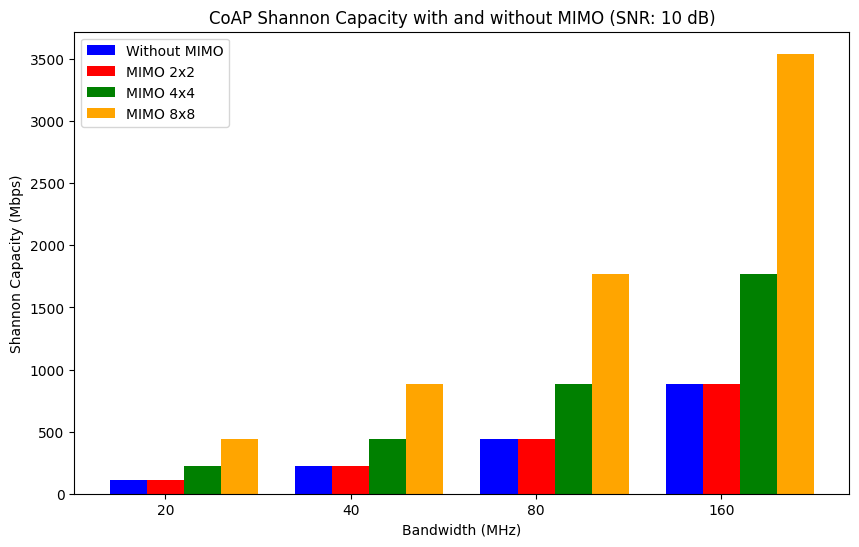

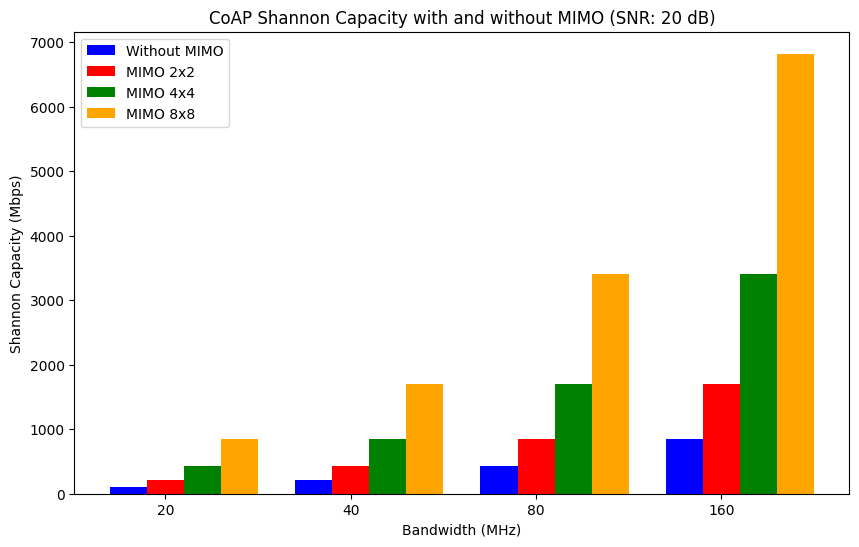

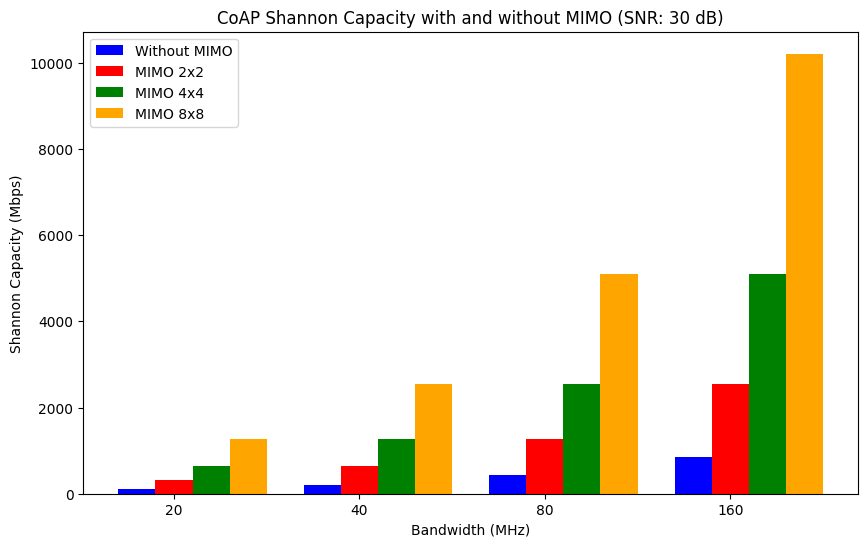

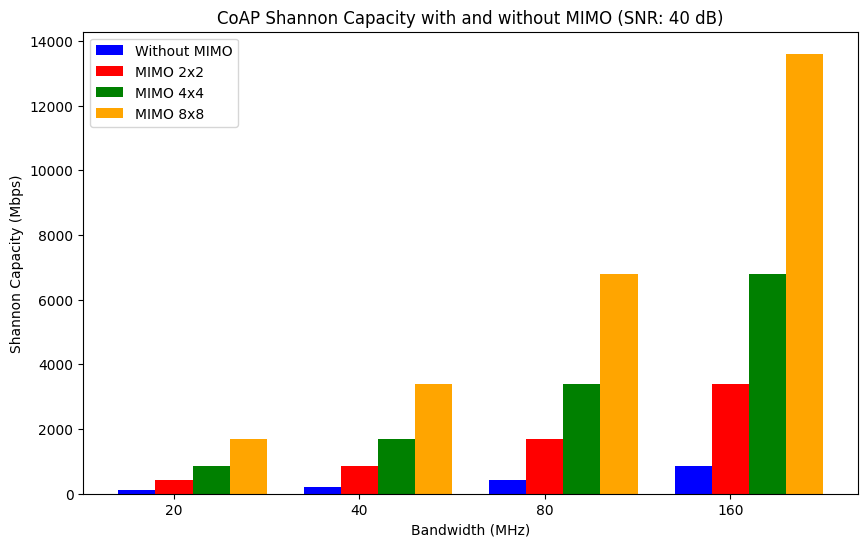

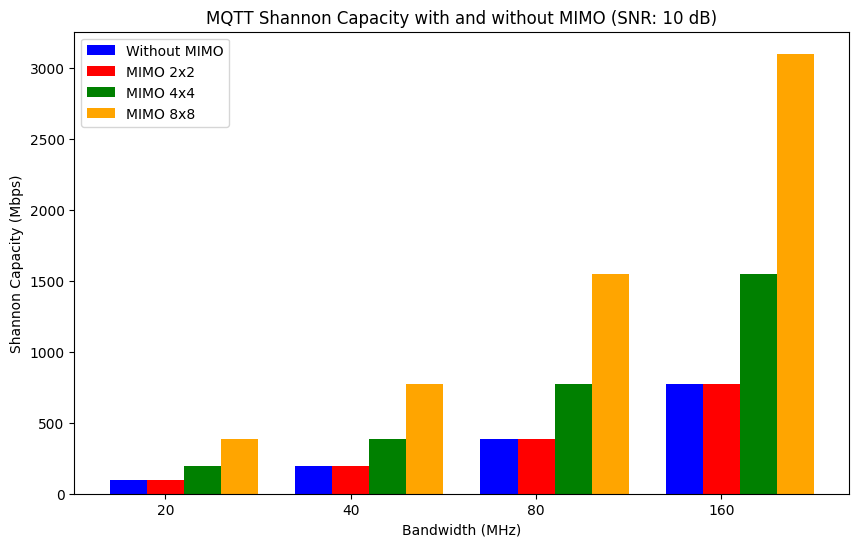

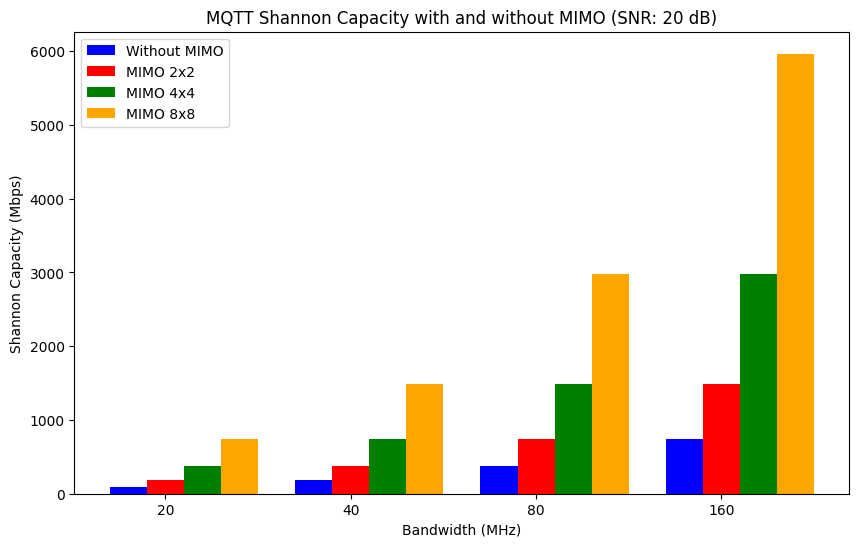

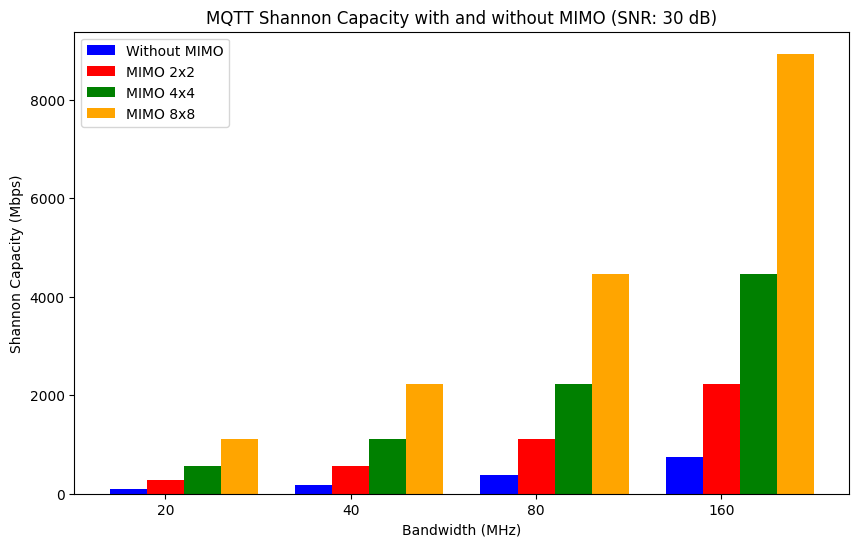

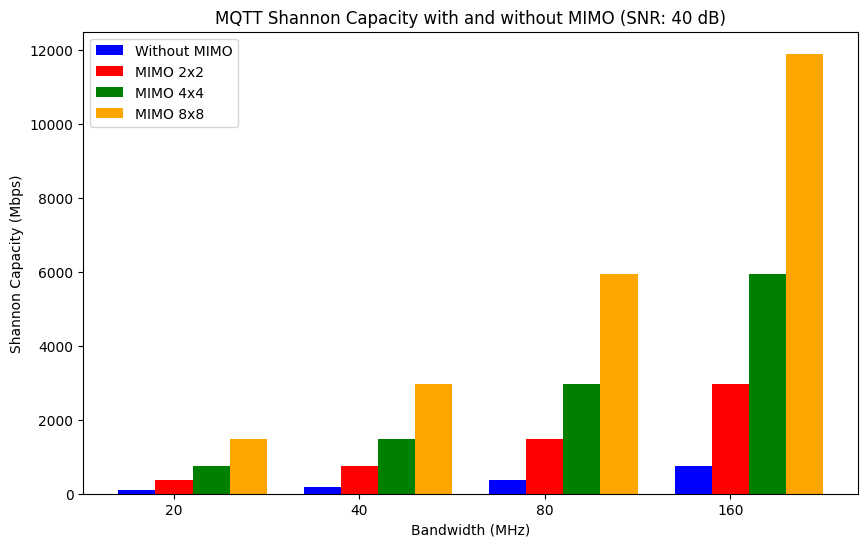

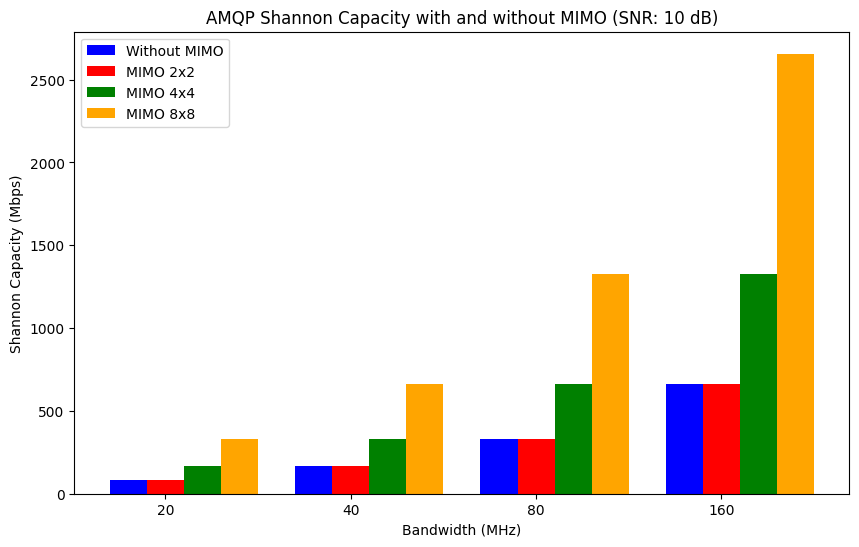

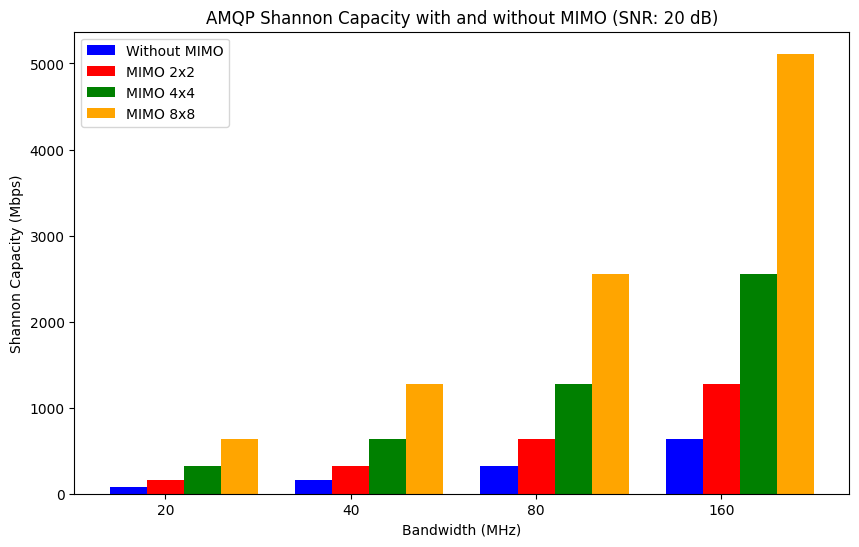

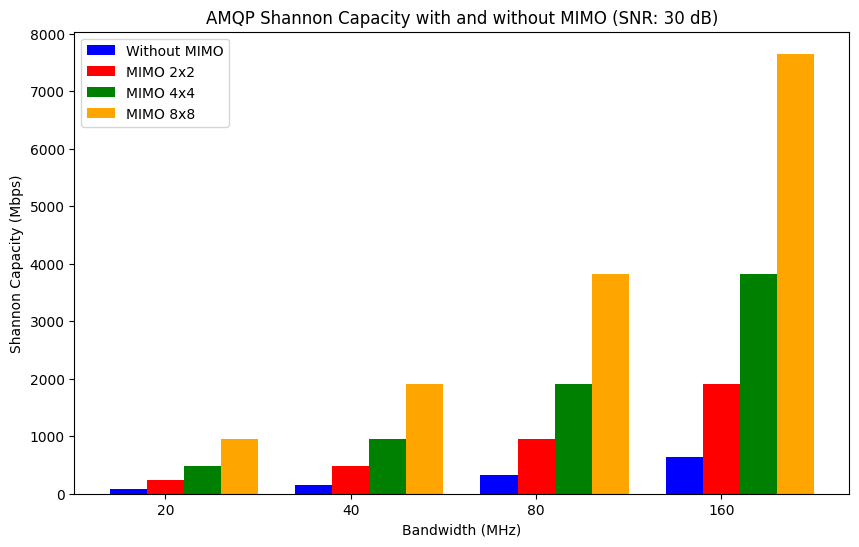

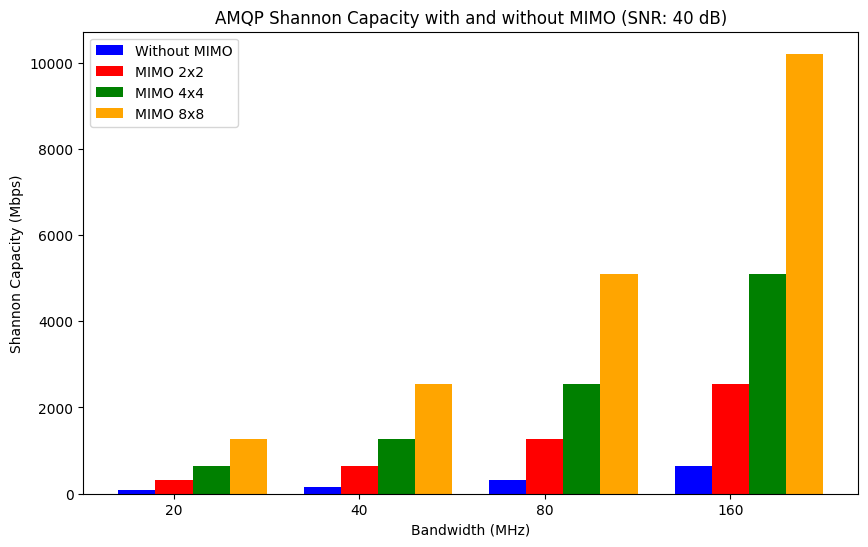

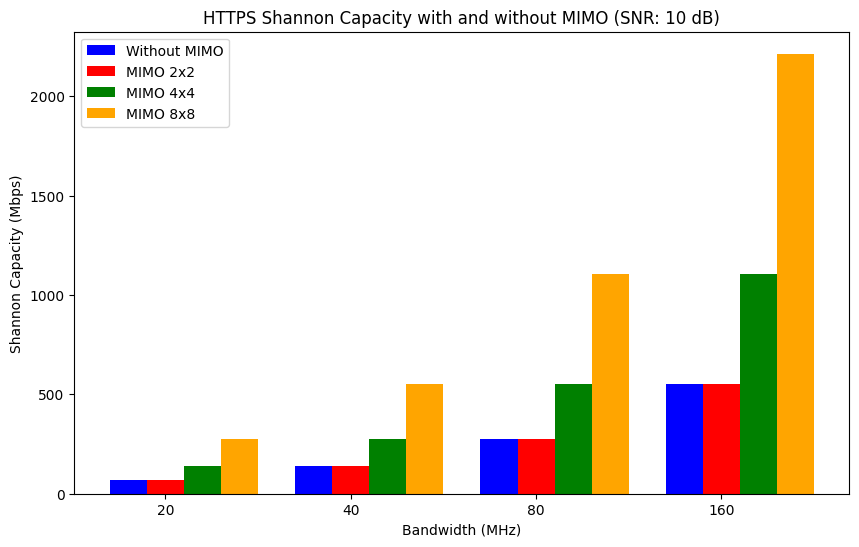

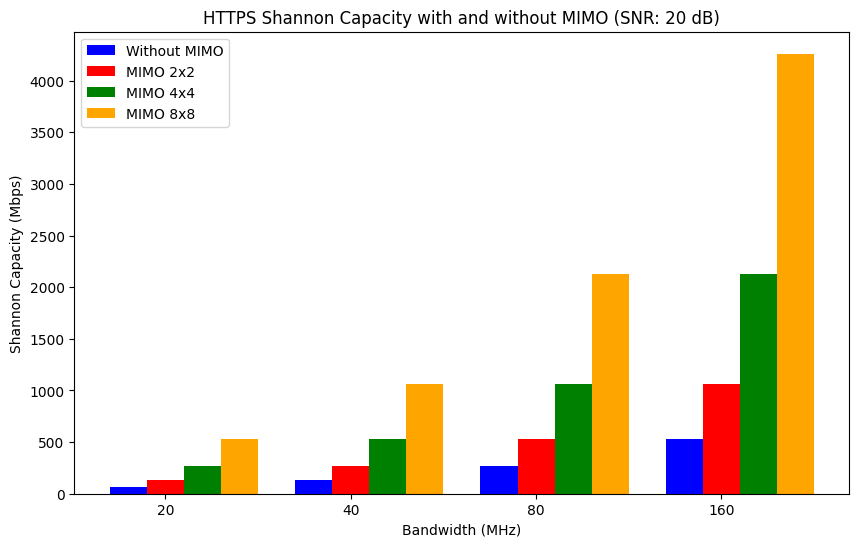

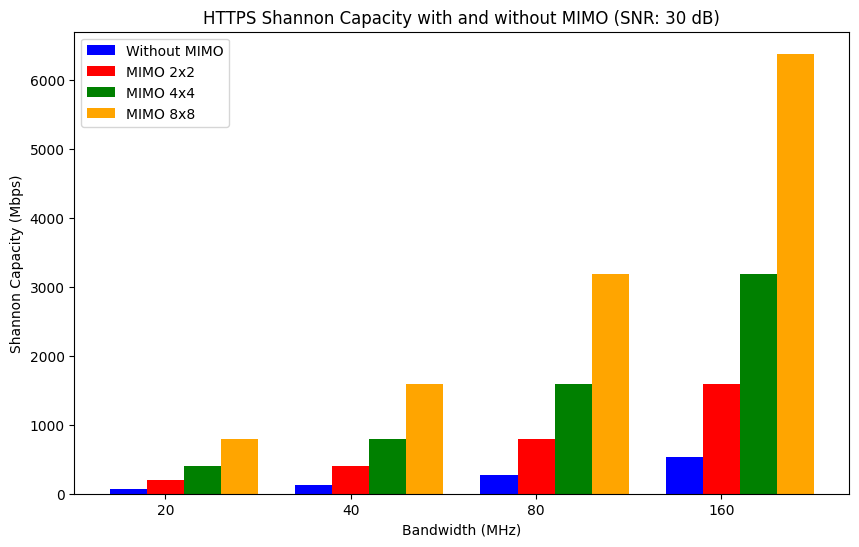

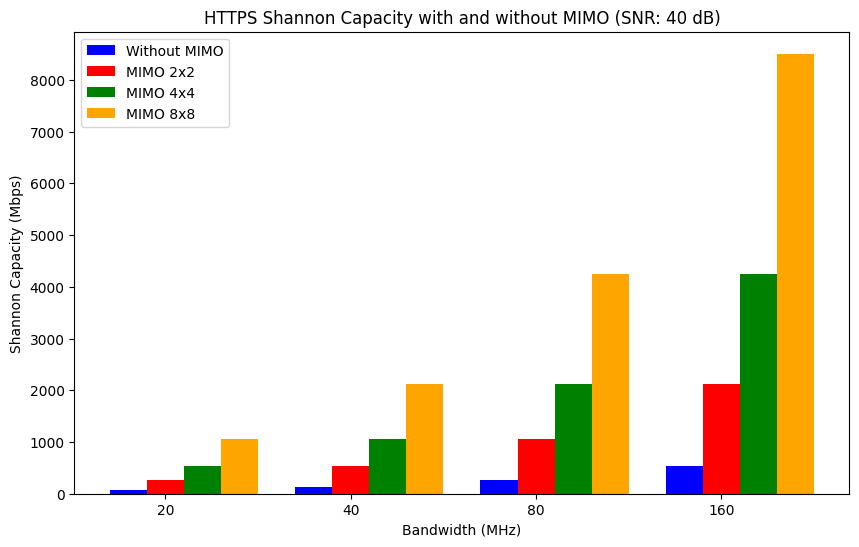

In [114]:
def plot_shannon_capacity(protocol, snr_index, snr):
    capacities_with_mimo_2x2 = [shannon_capacity[protocol][bw][snr_index] for bw in bandwidths]
    capacities_with_mimo_4x4 = [2 * val for val in capacities_with_mimo_2x2]
    capacities_with_mimo_8x8 = [4 * val for val in capacities_with_mimo_2x2]

    capacities_without_mimo = [cap / (snr_index + 1) for cap in capacities_with_mimo_2x2]  # Assuming without MIMO is 1x1

    x = np.arange(len(bandwidths))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width, capacities_without_mimo, width, label='Without MIMO', color='blue')
    bars2 = ax.bar(x, capacities_with_mimo_2x2, width, label='MIMO 2x2', color='red')
    bars3 = ax.bar(x + width, capacities_with_mimo_4x4, width, label='MIMO 4x4', color='green')
    bars4 = ax.bar(x + 2*width, capacities_with_mimo_8x8, width, label='MIMO 8x8', color='orange')

    ax.set_xlabel('Bandwidth (MHz)')
    ax.set_ylabel('Shannon Capacity (Mbps)')
    ax.set_title(f'{protocol} Shannon Capacity with and without MIMO (SNR: {snr} dB)')
    ax.set_xticks(x)
    ax.set_xticklabels(bandwidths)
    ax.legend()

    plt.show()

# Plot for each protocol and SNR
for protocol in protocols:
    for snr_index, snr in enumerate(snrs):
        plot_shannon_capacity(protocol, snr_index, snr)

**Concluding Remarks**
Thus, CoAP being an IoT protocol is successfully utilized to design the MIMO communication system needed to send multiple data of temperature. Mean response times and payload distributions from the simulation give an estimate of the system’s performance, dependability, and extensibility. Due to the low overhead, CoAP is a reliable solution for real-time data delivery in IoT platforms, and, perhaps, the optimization and real-life prototyping can improve the system performances and confirm its effectiveness. Further work could be done in the enhancement of employing real data and comparison with other IoT protocols and analyzing more sophisticated methods and algorithms for enhancing the system’s efficiency and effectiveness.